In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import numpy as np

# Preprocess Data

In [6]:
# Read data
Gold = pd.read_excel("/Users/koensmallegange/Desktop/Research-Practicum/Data/FUT_Option.xlsx")

# Convert to datetime
Gold['date'] = pd.to_datetime(Gold['date'])
Gold['futures_expiration_date'] = pd.to_datetime(Gold['futures_expiration_date'])
Gold['options_expiration_date'] = pd.to_datetime(Gold['options_expiration_date'], errors='coerce')
Gold['TTM'] = (Gold['options_expiration_date'] - Gold['date']).dt.days / 365.25

# Isolate call and put
Gold_call = Gold[Gold['call_put'] == 'C']
Gold_put = Gold[Gold['call_put'] == 'P']

# Sort by date
Gold_call.sort_values('date', inplace=True)
Gold_put.sort_values('date', inplace=True)

/var/folders/8b/t8hf_6ks3xz0jvr9wqs_8q6h0000gn/T/ipykernel_62445/3679638555.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gold_call.sort_values('date', inplace=True)
/var/folders/8b/t8hf_6ks3xz0jvr9wqs_8q6h0000gn/T/ipykernel_62445/3679638555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gold_put.sort_values('date', inplace=True)


In [4]:
# Load the dataset

#Filter so only call options are included, REMEMBER TO TRAIN ON A PUT DATAFRAME AS WELL

# Drop non-numeric columns if there are any
data = Gold_call.select_dtypes(include=[np.number])
mask = data['iv'] > 1000
data = data[~mask]
#data = data.reset_index(drop=True,inplace=True)
data

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,delta,vega,gamma,theta,TTM
0,1483500000,1275000000,0.0,0.0,208600006.0,0.651953,0.651953,0,0,0.995230,1.864800e-02,0.000158,-0.191653,0.008214
7192,1520000000,1675000000,0.0,0.0,64300003.0,0.169054,0.169054,0,0,0.353290,6.596541e+06,0.001239,-0.102311,1.442847
7190,1520000000,1670000000,0.0,0.0,65300003.0,0.168484,0.168484,0,0,0.358061,6.627883e+06,0.001249,-0.102402,1.442847
7188,1520000000,1665000000,0.0,0.0,66300003.0,0.167886,0.167886,0,0,0.362869,6.658375e+06,0.001259,-0.102463,1.442847
7186,1520000000,1660000000,0.0,0.0,67300003.0,0.167254,0.167254,0,0,0.367712,6.687969e+06,0.001269,-0.102478,1.442847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,1500400024,1530000000,54200001.0,55099998.0,54700001.0,0.146148,0.146148,0,81,0.454861,4.602492e+06,0.002336,-0.147159,0.613279
3582,1500400024,1525000000,55700001.0,56599998.0,56200001.0,0.144951,0.144951,0,659,0.465559,4.614900e+06,0.002362,-0.146244,0.613279
3580,1500400024,1520000000,57299999.0,58200001.0,57799999.0,0.143859,0.143859,0,141,0.476550,4.624173e+06,0.002384,-0.145329,0.613279
3596,1500400024,1560000000,46000000.0,46900002.0,46599998.0,0.153054,0.153054,0,505,0.395529,4.472437e+06,0.002167,-0.150250,0.613279


In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# Preprocess the data
#scaler = MinMaxScaler((-1, 1))
#data_scaled = scaler.fit_transform(data)

In [6]:
# Define the generator and discriminator models
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.Dense(data_scaled.shape[1], activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(data_scaled.shape[1],)),
        layers.Dense(1, activation='sigmoid')
    ])
    return model




In [7]:
import tensorflow as tf

# Define batch size and noise dimension
BATCH_SIZE = 128
NOISE_DIM = 100
 
# Define the generator and discriminator models
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(100,)),
        layers.Dense(data_scaled.shape[1], activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(data_scaled.shape[1],)),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

# Define the training loop

@tf.function
def train_step(real_data):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)
        
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = (cross_entropy(tf.ones_like(real_output), real_output) +
                     cross_entropy(tf.zeros_like(fake_output), fake_output))
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for data_batch in dataset:
            train_step(data_batch)
        print(f'Epoch {epoch + 1}/{epochs} completed')  # Print the current epoch count
# Prepare the dataset
BUFFER_SIZE = 5389 
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(data_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train the GAN
train(train_dataset, epochs=50000)


Epoch 1/50000 completed
Epoch 2/50000 completed
Epoch 3/50000 completed
Epoch 4/50000 completed
Epoch 5/50000 completed
Epoch 6/50000 completed
Epoch 7/50000 completed
Epoch 8/50000 completed
Epoch 9/50000 completed
Epoch 10/50000 completed
Epoch 11/50000 completed
Epoch 12/50000 completed
Epoch 13/50000 completed
Epoch 14/50000 completed
Epoch 15/50000 completed
Epoch 16/50000 completed
Epoch 17/50000 completed
Epoch 18/50000 completed
Epoch 19/50000 completed
Epoch 20/50000 completed
Epoch 21/50000 completed
Epoch 22/50000 completed
Epoch 23/50000 completed
Epoch 24/50000 completed
Epoch 25/50000 completed
Epoch 26/50000 completed
Epoch 27/50000 completed
Epoch 28/50000 completed
Epoch 29/50000 completed
Epoch 30/50000 completed
Epoch 31/50000 completed
Epoch 32/50000 completed
Epoch 33/50000 completed
Epoch 34/50000 completed
Epoch 35/50000 completed
Epoch 36/50000 completed
Epoch 37/50000 completed
Epoch 38/50000 completed
Epoch 39/50000 completed
Epoch 40/50000 completed
Epoch 41

Epoch 314/50000 completed
Epoch 315/50000 completed
Epoch 316/50000 completed
Epoch 317/50000 completed
Epoch 318/50000 completed
Epoch 319/50000 completed
Epoch 320/50000 completed
Epoch 321/50000 completed
Epoch 322/50000 completed
Epoch 323/50000 completed
Epoch 324/50000 completed
Epoch 325/50000 completed
Epoch 326/50000 completed
Epoch 327/50000 completed
Epoch 328/50000 completed
Epoch 329/50000 completed
Epoch 330/50000 completed
Epoch 331/50000 completed
Epoch 332/50000 completed
Epoch 333/50000 completed
Epoch 334/50000 completed
Epoch 335/50000 completed
Epoch 336/50000 completed
Epoch 337/50000 completed
Epoch 338/50000 completed
Epoch 339/50000 completed
Epoch 340/50000 completed
Epoch 341/50000 completed
Epoch 342/50000 completed
Epoch 343/50000 completed
Epoch 344/50000 completed
Epoch 345/50000 completed
Epoch 346/50000 completed
Epoch 347/50000 completed
Epoch 348/50000 completed
Epoch 349/50000 completed
Epoch 350/50000 completed
Epoch 351/50000 completed
Epoch 352/50

Epoch 630/50000 completed
Epoch 631/50000 completed
Epoch 632/50000 completed
Epoch 633/50000 completed
Epoch 634/50000 completed
Epoch 635/50000 completed
Epoch 636/50000 completed
Epoch 637/50000 completed
Epoch 638/50000 completed
Epoch 639/50000 completed
Epoch 640/50000 completed
Epoch 641/50000 completed
Epoch 642/50000 completed
Epoch 643/50000 completed
Epoch 644/50000 completed
Epoch 645/50000 completed
Epoch 646/50000 completed
Epoch 647/50000 completed
Epoch 648/50000 completed
Epoch 649/50000 completed
Epoch 650/50000 completed
Epoch 651/50000 completed
Epoch 652/50000 completed
Epoch 653/50000 completed
Epoch 654/50000 completed
Epoch 655/50000 completed
Epoch 656/50000 completed
Epoch 657/50000 completed
Epoch 658/50000 completed
Epoch 659/50000 completed
Epoch 660/50000 completed
Epoch 661/50000 completed
Epoch 662/50000 completed
Epoch 663/50000 completed
Epoch 664/50000 completed
Epoch 665/50000 completed
Epoch 666/50000 completed
Epoch 667/50000 completed
Epoch 668/50

Epoch 946/50000 completed
Epoch 947/50000 completed
Epoch 948/50000 completed
Epoch 949/50000 completed
Epoch 950/50000 completed
Epoch 951/50000 completed
Epoch 952/50000 completed
Epoch 953/50000 completed
Epoch 954/50000 completed
Epoch 955/50000 completed
Epoch 956/50000 completed
Epoch 957/50000 completed
Epoch 958/50000 completed
Epoch 959/50000 completed
Epoch 960/50000 completed
Epoch 961/50000 completed
Epoch 962/50000 completed
Epoch 963/50000 completed
Epoch 964/50000 completed
Epoch 965/50000 completed
Epoch 966/50000 completed
Epoch 967/50000 completed
Epoch 968/50000 completed
Epoch 969/50000 completed
Epoch 970/50000 completed
Epoch 971/50000 completed
Epoch 972/50000 completed
Epoch 973/50000 completed
Epoch 974/50000 completed
Epoch 975/50000 completed
Epoch 976/50000 completed
Epoch 977/50000 completed
Epoch 978/50000 completed
Epoch 979/50000 completed
Epoch 980/50000 completed
Epoch 981/50000 completed
Epoch 982/50000 completed
Epoch 983/50000 completed
Epoch 984/50

Epoch 1254/50000 completed
Epoch 1255/50000 completed
Epoch 1256/50000 completed
Epoch 1257/50000 completed
Epoch 1258/50000 completed
Epoch 1259/50000 completed
Epoch 1260/50000 completed
Epoch 1261/50000 completed
Epoch 1262/50000 completed
Epoch 1263/50000 completed
Epoch 1264/50000 completed
Epoch 1265/50000 completed
Epoch 1266/50000 completed
Epoch 1267/50000 completed
Epoch 1268/50000 completed
Epoch 1269/50000 completed
Epoch 1270/50000 completed
Epoch 1271/50000 completed
Epoch 1272/50000 completed
Epoch 1273/50000 completed
Epoch 1274/50000 completed
Epoch 1275/50000 completed
Epoch 1276/50000 completed
Epoch 1277/50000 completed
Epoch 1278/50000 completed
Epoch 1279/50000 completed
Epoch 1280/50000 completed
Epoch 1281/50000 completed
Epoch 1282/50000 completed
Epoch 1283/50000 completed
Epoch 1284/50000 completed
Epoch 1285/50000 completed
Epoch 1286/50000 completed
Epoch 1287/50000 completed
Epoch 1288/50000 completed
Epoch 1289/50000 completed
Epoch 1290/50000 completed
E

Epoch 1559/50000 completed
Epoch 1560/50000 completed
Epoch 1561/50000 completed
Epoch 1562/50000 completed
Epoch 1563/50000 completed
Epoch 1564/50000 completed
Epoch 1565/50000 completed
Epoch 1566/50000 completed
Epoch 1567/50000 completed
Epoch 1568/50000 completed
Epoch 1569/50000 completed
Epoch 1570/50000 completed
Epoch 1571/50000 completed
Epoch 1572/50000 completed
Epoch 1573/50000 completed
Epoch 1574/50000 completed
Epoch 1575/50000 completed
Epoch 1576/50000 completed
Epoch 1577/50000 completed
Epoch 1578/50000 completed
Epoch 1579/50000 completed
Epoch 1580/50000 completed
Epoch 1581/50000 completed
Epoch 1582/50000 completed
Epoch 1583/50000 completed
Epoch 1584/50000 completed
Epoch 1585/50000 completed
Epoch 1586/50000 completed
Epoch 1587/50000 completed
Epoch 1588/50000 completed
Epoch 1589/50000 completed
Epoch 1590/50000 completed
Epoch 1591/50000 completed
Epoch 1592/50000 completed
Epoch 1593/50000 completed
Epoch 1594/50000 completed
Epoch 1595/50000 completed
E

Epoch 1865/50000 completed
Epoch 1866/50000 completed
Epoch 1867/50000 completed
Epoch 1868/50000 completed
Epoch 1869/50000 completed
Epoch 1870/50000 completed
Epoch 1871/50000 completed
Epoch 1872/50000 completed
Epoch 1873/50000 completed
Epoch 1874/50000 completed
Epoch 1875/50000 completed
Epoch 1876/50000 completed
Epoch 1877/50000 completed
Epoch 1878/50000 completed
Epoch 1879/50000 completed
Epoch 1880/50000 completed
Epoch 1881/50000 completed
Epoch 1882/50000 completed
Epoch 1883/50000 completed
Epoch 1884/50000 completed
Epoch 1885/50000 completed
Epoch 1886/50000 completed
Epoch 1887/50000 completed
Epoch 1888/50000 completed
Epoch 1889/50000 completed
Epoch 1890/50000 completed
Epoch 1891/50000 completed
Epoch 1892/50000 completed
Epoch 1893/50000 completed
Epoch 1894/50000 completed
Epoch 1895/50000 completed
Epoch 1896/50000 completed
Epoch 1897/50000 completed
Epoch 1898/50000 completed
Epoch 1899/50000 completed
Epoch 1900/50000 completed
Epoch 1901/50000 completed
E

Epoch 2169/50000 completed
Epoch 2170/50000 completed
Epoch 2171/50000 completed
Epoch 2172/50000 completed
Epoch 2173/50000 completed
Epoch 2174/50000 completed
Epoch 2175/50000 completed
Epoch 2176/50000 completed
Epoch 2177/50000 completed
Epoch 2178/50000 completed
Epoch 2179/50000 completed
Epoch 2180/50000 completed
Epoch 2181/50000 completed
Epoch 2182/50000 completed
Epoch 2183/50000 completed
Epoch 2184/50000 completed
Epoch 2185/50000 completed
Epoch 2186/50000 completed
Epoch 2187/50000 completed
Epoch 2188/50000 completed
Epoch 2189/50000 completed
Epoch 2190/50000 completed
Epoch 2191/50000 completed
Epoch 2192/50000 completed
Epoch 2193/50000 completed
Epoch 2194/50000 completed
Epoch 2195/50000 completed
Epoch 2196/50000 completed
Epoch 2197/50000 completed
Epoch 2198/50000 completed
Epoch 2199/50000 completed
Epoch 2200/50000 completed
Epoch 2201/50000 completed
Epoch 2202/50000 completed
Epoch 2203/50000 completed
Epoch 2204/50000 completed
Epoch 2205/50000 completed
E

Epoch 2475/50000 completed
Epoch 2476/50000 completed
Epoch 2477/50000 completed
Epoch 2478/50000 completed
Epoch 2479/50000 completed
Epoch 2480/50000 completed
Epoch 2481/50000 completed
Epoch 2482/50000 completed
Epoch 2483/50000 completed
Epoch 2484/50000 completed
Epoch 2485/50000 completed
Epoch 2486/50000 completed
Epoch 2487/50000 completed
Epoch 2488/50000 completed
Epoch 2489/50000 completed
Epoch 2490/50000 completed
Epoch 2491/50000 completed
Epoch 2492/50000 completed
Epoch 2493/50000 completed
Epoch 2494/50000 completed
Epoch 2495/50000 completed
Epoch 2496/50000 completed
Epoch 2497/50000 completed
Epoch 2498/50000 completed
Epoch 2499/50000 completed
Epoch 2500/50000 completed
Epoch 2501/50000 completed
Epoch 2502/50000 completed
Epoch 2503/50000 completed
Epoch 2504/50000 completed
Epoch 2505/50000 completed
Epoch 2506/50000 completed
Epoch 2507/50000 completed
Epoch 2508/50000 completed
Epoch 2509/50000 completed
Epoch 2510/50000 completed
Epoch 2511/50000 completed
E

Epoch 2780/50000 completed
Epoch 2781/50000 completed
Epoch 2782/50000 completed
Epoch 2783/50000 completed
Epoch 2784/50000 completed
Epoch 2785/50000 completed
Epoch 2786/50000 completed
Epoch 2787/50000 completed
Epoch 2788/50000 completed
Epoch 2789/50000 completed
Epoch 2790/50000 completed
Epoch 2791/50000 completed
Epoch 2792/50000 completed
Epoch 2793/50000 completed
Epoch 2794/50000 completed
Epoch 2795/50000 completed
Epoch 2796/50000 completed
Epoch 2797/50000 completed
Epoch 2798/50000 completed
Epoch 2799/50000 completed
Epoch 2800/50000 completed
Epoch 2801/50000 completed
Epoch 2802/50000 completed
Epoch 2803/50000 completed
Epoch 2804/50000 completed
Epoch 2805/50000 completed
Epoch 2806/50000 completed
Epoch 2807/50000 completed
Epoch 2808/50000 completed
Epoch 2809/50000 completed
Epoch 2810/50000 completed
Epoch 2811/50000 completed
Epoch 2812/50000 completed
Epoch 2813/50000 completed
Epoch 2814/50000 completed
Epoch 2815/50000 completed
Epoch 2816/50000 completed
E

Epoch 3085/50000 completed
Epoch 3086/50000 completed
Epoch 3087/50000 completed
Epoch 3088/50000 completed
Epoch 3089/50000 completed
Epoch 3090/50000 completed
Epoch 3091/50000 completed
Epoch 3092/50000 completed
Epoch 3093/50000 completed
Epoch 3094/50000 completed
Epoch 3095/50000 completed
Epoch 3096/50000 completed
Epoch 3097/50000 completed
Epoch 3098/50000 completed
Epoch 3099/50000 completed
Epoch 3100/50000 completed
Epoch 3101/50000 completed
Epoch 3102/50000 completed
Epoch 3103/50000 completed
Epoch 3104/50000 completed
Epoch 3105/50000 completed
Epoch 3106/50000 completed
Epoch 3107/50000 completed
Epoch 3108/50000 completed
Epoch 3109/50000 completed
Epoch 3110/50000 completed
Epoch 3111/50000 completed
Epoch 3112/50000 completed
Epoch 3113/50000 completed
Epoch 3114/50000 completed
Epoch 3115/50000 completed
Epoch 3116/50000 completed
Epoch 3117/50000 completed
Epoch 3118/50000 completed
Epoch 3119/50000 completed
Epoch 3120/50000 completed
Epoch 3121/50000 completed
E

Epoch 3391/50000 completed
Epoch 3392/50000 completed
Epoch 3393/50000 completed
Epoch 3394/50000 completed
Epoch 3395/50000 completed
Epoch 3396/50000 completed
Epoch 3397/50000 completed
Epoch 3398/50000 completed
Epoch 3399/50000 completed
Epoch 3400/50000 completed
Epoch 3401/50000 completed
Epoch 3402/50000 completed
Epoch 3403/50000 completed
Epoch 3404/50000 completed
Epoch 3405/50000 completed
Epoch 3406/50000 completed
Epoch 3407/50000 completed
Epoch 3408/50000 completed
Epoch 3409/50000 completed
Epoch 3410/50000 completed
Epoch 3411/50000 completed
Epoch 3412/50000 completed
Epoch 3413/50000 completed
Epoch 3414/50000 completed
Epoch 3415/50000 completed
Epoch 3416/50000 completed
Epoch 3417/50000 completed
Epoch 3418/50000 completed
Epoch 3419/50000 completed
Epoch 3420/50000 completed
Epoch 3421/50000 completed
Epoch 3422/50000 completed
Epoch 3423/50000 completed
Epoch 3424/50000 completed
Epoch 3425/50000 completed
Epoch 3426/50000 completed
Epoch 3427/50000 completed
E

Epoch 3697/50000 completed
Epoch 3698/50000 completed
Epoch 3699/50000 completed
Epoch 3700/50000 completed
Epoch 3701/50000 completed
Epoch 3702/50000 completed
Epoch 3703/50000 completed
Epoch 3704/50000 completed
Epoch 3705/50000 completed
Epoch 3706/50000 completed
Epoch 3707/50000 completed
Epoch 3708/50000 completed
Epoch 3709/50000 completed
Epoch 3710/50000 completed
Epoch 3711/50000 completed
Epoch 3712/50000 completed
Epoch 3713/50000 completed
Epoch 3714/50000 completed
Epoch 3715/50000 completed
Epoch 3716/50000 completed
Epoch 3717/50000 completed
Epoch 3718/50000 completed
Epoch 3719/50000 completed
Epoch 3720/50000 completed
Epoch 3721/50000 completed
Epoch 3722/50000 completed
Epoch 3723/50000 completed
Epoch 3724/50000 completed
Epoch 3725/50000 completed
Epoch 3726/50000 completed
Epoch 3727/50000 completed
Epoch 3728/50000 completed
Epoch 3729/50000 completed
Epoch 3730/50000 completed
Epoch 3731/50000 completed
Epoch 3732/50000 completed
Epoch 3733/50000 completed
E

Epoch 4001/50000 completed
Epoch 4002/50000 completed
Epoch 4003/50000 completed
Epoch 4004/50000 completed
Epoch 4005/50000 completed
Epoch 4006/50000 completed
Epoch 4007/50000 completed
Epoch 4008/50000 completed
Epoch 4009/50000 completed
Epoch 4010/50000 completed
Epoch 4011/50000 completed
Epoch 4012/50000 completed
Epoch 4013/50000 completed
Epoch 4014/50000 completed
Epoch 4015/50000 completed
Epoch 4016/50000 completed
Epoch 4017/50000 completed
Epoch 4018/50000 completed
Epoch 4019/50000 completed
Epoch 4020/50000 completed
Epoch 4021/50000 completed
Epoch 4022/50000 completed
Epoch 4023/50000 completed
Epoch 4024/50000 completed
Epoch 4025/50000 completed
Epoch 4026/50000 completed
Epoch 4027/50000 completed
Epoch 4028/50000 completed
Epoch 4029/50000 completed
Epoch 4030/50000 completed
Epoch 4031/50000 completed
Epoch 4032/50000 completed
Epoch 4033/50000 completed
Epoch 4034/50000 completed
Epoch 4035/50000 completed
Epoch 4036/50000 completed
Epoch 4037/50000 completed
E

Epoch 4306/50000 completed
Epoch 4307/50000 completed
Epoch 4308/50000 completed
Epoch 4309/50000 completed
Epoch 4310/50000 completed
Epoch 4311/50000 completed
Epoch 4312/50000 completed
Epoch 4313/50000 completed
Epoch 4314/50000 completed
Epoch 4315/50000 completed
Epoch 4316/50000 completed
Epoch 4317/50000 completed
Epoch 4318/50000 completed
Epoch 4319/50000 completed
Epoch 4320/50000 completed
Epoch 4321/50000 completed
Epoch 4322/50000 completed
Epoch 4323/50000 completed
Epoch 4324/50000 completed
Epoch 4325/50000 completed
Epoch 4326/50000 completed
Epoch 4327/50000 completed
Epoch 4328/50000 completed
Epoch 4329/50000 completed
Epoch 4330/50000 completed
Epoch 4331/50000 completed
Epoch 4332/50000 completed
Epoch 4333/50000 completed
Epoch 4334/50000 completed
Epoch 4335/50000 completed
Epoch 4336/50000 completed
Epoch 4337/50000 completed
Epoch 4338/50000 completed
Epoch 4339/50000 completed
Epoch 4340/50000 completed
Epoch 4341/50000 completed
Epoch 4342/50000 completed
E

Epoch 4612/50000 completed
Epoch 4613/50000 completed
Epoch 4614/50000 completed
Epoch 4615/50000 completed
Epoch 4616/50000 completed
Epoch 4617/50000 completed
Epoch 4618/50000 completed
Epoch 4619/50000 completed
Epoch 4620/50000 completed
Epoch 4621/50000 completed
Epoch 4622/50000 completed
Epoch 4623/50000 completed
Epoch 4624/50000 completed
Epoch 4625/50000 completed
Epoch 4626/50000 completed
Epoch 4627/50000 completed
Epoch 4628/50000 completed
Epoch 4629/50000 completed
Epoch 4630/50000 completed
Epoch 4631/50000 completed
Epoch 4632/50000 completed
Epoch 4633/50000 completed
Epoch 4634/50000 completed
Epoch 4635/50000 completed
Epoch 4636/50000 completed
Epoch 4637/50000 completed
Epoch 4638/50000 completed
Epoch 4639/50000 completed
Epoch 4640/50000 completed
Epoch 4641/50000 completed
Epoch 4642/50000 completed
Epoch 4643/50000 completed
Epoch 4644/50000 completed
Epoch 4645/50000 completed
Epoch 4646/50000 completed
Epoch 4647/50000 completed
Epoch 4648/50000 completed
E

Epoch 4918/50000 completed
Epoch 4919/50000 completed
Epoch 4920/50000 completed
Epoch 4921/50000 completed
Epoch 4922/50000 completed
Epoch 4923/50000 completed
Epoch 4924/50000 completed
Epoch 4925/50000 completed
Epoch 4926/50000 completed
Epoch 4927/50000 completed
Epoch 4928/50000 completed
Epoch 4929/50000 completed
Epoch 4930/50000 completed
Epoch 4931/50000 completed
Epoch 4932/50000 completed
Epoch 4933/50000 completed
Epoch 4934/50000 completed
Epoch 4935/50000 completed
Epoch 4936/50000 completed
Epoch 4937/50000 completed
Epoch 4938/50000 completed
Epoch 4939/50000 completed
Epoch 4940/50000 completed
Epoch 4941/50000 completed
Epoch 4942/50000 completed
Epoch 4943/50000 completed
Epoch 4944/50000 completed
Epoch 4945/50000 completed
Epoch 4946/50000 completed
Epoch 4947/50000 completed
Epoch 4948/50000 completed
Epoch 4949/50000 completed
Epoch 4950/50000 completed
Epoch 4951/50000 completed
Epoch 4952/50000 completed
Epoch 4953/50000 completed
Epoch 4954/50000 completed
E

Epoch 5223/50000 completed
Epoch 5224/50000 completed
Epoch 5225/50000 completed
Epoch 5226/50000 completed
Epoch 5227/50000 completed
Epoch 5228/50000 completed
Epoch 5229/50000 completed
Epoch 5230/50000 completed
Epoch 5231/50000 completed
Epoch 5232/50000 completed
Epoch 5233/50000 completed
Epoch 5234/50000 completed
Epoch 5235/50000 completed
Epoch 5236/50000 completed
Epoch 5237/50000 completed
Epoch 5238/50000 completed
Epoch 5239/50000 completed
Epoch 5240/50000 completed
Epoch 5241/50000 completed
Epoch 5242/50000 completed
Epoch 5243/50000 completed
Epoch 5244/50000 completed
Epoch 5245/50000 completed
Epoch 5246/50000 completed
Epoch 5247/50000 completed
Epoch 5248/50000 completed
Epoch 5249/50000 completed
Epoch 5250/50000 completed
Epoch 5251/50000 completed
Epoch 5252/50000 completed
Epoch 5253/50000 completed
Epoch 5254/50000 completed
Epoch 5255/50000 completed
Epoch 5256/50000 completed
Epoch 5257/50000 completed
Epoch 5258/50000 completed
Epoch 5259/50000 completed
E

Epoch 5527/50000 completed
Epoch 5528/50000 completed
Epoch 5529/50000 completed
Epoch 5530/50000 completed
Epoch 5531/50000 completed
Epoch 5532/50000 completed
Epoch 5533/50000 completed
Epoch 5534/50000 completed
Epoch 5535/50000 completed
Epoch 5536/50000 completed
Epoch 5537/50000 completed
Epoch 5538/50000 completed
Epoch 5539/50000 completed
Epoch 5540/50000 completed
Epoch 5541/50000 completed
Epoch 5542/50000 completed
Epoch 5543/50000 completed
Epoch 5544/50000 completed
Epoch 5545/50000 completed
Epoch 5546/50000 completed
Epoch 5547/50000 completed
Epoch 5548/50000 completed
Epoch 5549/50000 completed
Epoch 5550/50000 completed
Epoch 5551/50000 completed
Epoch 5552/50000 completed
Epoch 5553/50000 completed
Epoch 5554/50000 completed
Epoch 5555/50000 completed
Epoch 5556/50000 completed
Epoch 5557/50000 completed
Epoch 5558/50000 completed
Epoch 5559/50000 completed
Epoch 5560/50000 completed
Epoch 5561/50000 completed
Epoch 5562/50000 completed
Epoch 5563/50000 completed
E

Epoch 5832/50000 completed
Epoch 5833/50000 completed
Epoch 5834/50000 completed
Epoch 5835/50000 completed
Epoch 5836/50000 completed
Epoch 5837/50000 completed
Epoch 5838/50000 completed
Epoch 5839/50000 completed
Epoch 5840/50000 completed
Epoch 5841/50000 completed
Epoch 5842/50000 completed
Epoch 5843/50000 completed
Epoch 5844/50000 completed
Epoch 5845/50000 completed
Epoch 5846/50000 completed
Epoch 5847/50000 completed
Epoch 5848/50000 completed
Epoch 5849/50000 completed
Epoch 5850/50000 completed
Epoch 5851/50000 completed
Epoch 5852/50000 completed
Epoch 5853/50000 completed
Epoch 5854/50000 completed
Epoch 5855/50000 completed
Epoch 5856/50000 completed
Epoch 5857/50000 completed
Epoch 5858/50000 completed
Epoch 5859/50000 completed
Epoch 5860/50000 completed
Epoch 5861/50000 completed
Epoch 5862/50000 completed
Epoch 5863/50000 completed
Epoch 5864/50000 completed
Epoch 5865/50000 completed
Epoch 5866/50000 completed
Epoch 5867/50000 completed
Epoch 5868/50000 completed
E

Epoch 6136/50000 completed
Epoch 6137/50000 completed
Epoch 6138/50000 completed
Epoch 6139/50000 completed
Epoch 6140/50000 completed
Epoch 6141/50000 completed
Epoch 6142/50000 completed
Epoch 6143/50000 completed
Epoch 6144/50000 completed
Epoch 6145/50000 completed
Epoch 6146/50000 completed
Epoch 6147/50000 completed
Epoch 6148/50000 completed
Epoch 6149/50000 completed
Epoch 6150/50000 completed
Epoch 6151/50000 completed
Epoch 6152/50000 completed
Epoch 6153/50000 completed
Epoch 6154/50000 completed
Epoch 6155/50000 completed
Epoch 6156/50000 completed
Epoch 6157/50000 completed
Epoch 6158/50000 completed
Epoch 6159/50000 completed
Epoch 6160/50000 completed
Epoch 6161/50000 completed
Epoch 6162/50000 completed
Epoch 6163/50000 completed
Epoch 6164/50000 completed
Epoch 6165/50000 completed
Epoch 6166/50000 completed
Epoch 6167/50000 completed
Epoch 6168/50000 completed
Epoch 6169/50000 completed
Epoch 6170/50000 completed
Epoch 6171/50000 completed
Epoch 6172/50000 completed
E

Epoch 6440/50000 completed
Epoch 6441/50000 completed
Epoch 6442/50000 completed
Epoch 6443/50000 completed
Epoch 6444/50000 completed
Epoch 6445/50000 completed
Epoch 6446/50000 completed
Epoch 6447/50000 completed
Epoch 6448/50000 completed
Epoch 6449/50000 completed
Epoch 6450/50000 completed
Epoch 6451/50000 completed
Epoch 6452/50000 completed
Epoch 6453/50000 completed
Epoch 6454/50000 completed
Epoch 6455/50000 completed
Epoch 6456/50000 completed
Epoch 6457/50000 completed
Epoch 6458/50000 completed
Epoch 6459/50000 completed
Epoch 6460/50000 completed
Epoch 6461/50000 completed
Epoch 6462/50000 completed
Epoch 6463/50000 completed
Epoch 6464/50000 completed
Epoch 6465/50000 completed
Epoch 6466/50000 completed
Epoch 6467/50000 completed
Epoch 6468/50000 completed
Epoch 6469/50000 completed
Epoch 6470/50000 completed
Epoch 6471/50000 completed
Epoch 6472/50000 completed
Epoch 6473/50000 completed
Epoch 6474/50000 completed
Epoch 6475/50000 completed
Epoch 6476/50000 completed
E

Epoch 6744/50000 completed
Epoch 6745/50000 completed
Epoch 6746/50000 completed
Epoch 6747/50000 completed
Epoch 6748/50000 completed
Epoch 6749/50000 completed
Epoch 6750/50000 completed
Epoch 6751/50000 completed
Epoch 6752/50000 completed
Epoch 6753/50000 completed
Epoch 6754/50000 completed
Epoch 6755/50000 completed
Epoch 6756/50000 completed
Epoch 6757/50000 completed
Epoch 6758/50000 completed
Epoch 6759/50000 completed
Epoch 6760/50000 completed
Epoch 6761/50000 completed
Epoch 6762/50000 completed
Epoch 6763/50000 completed
Epoch 6764/50000 completed
Epoch 6765/50000 completed
Epoch 6766/50000 completed
Epoch 6767/50000 completed
Epoch 6768/50000 completed
Epoch 6769/50000 completed
Epoch 6770/50000 completed
Epoch 6771/50000 completed
Epoch 6772/50000 completed
Epoch 6773/50000 completed
Epoch 6774/50000 completed
Epoch 6775/50000 completed
Epoch 6776/50000 completed
Epoch 6777/50000 completed
Epoch 6778/50000 completed
Epoch 6779/50000 completed
Epoch 6780/50000 completed
E

Epoch 7050/50000 completed
Epoch 7051/50000 completed
Epoch 7052/50000 completed
Epoch 7053/50000 completed
Epoch 7054/50000 completed
Epoch 7055/50000 completed
Epoch 7056/50000 completed
Epoch 7057/50000 completed
Epoch 7058/50000 completed
Epoch 7059/50000 completed
Epoch 7060/50000 completed
Epoch 7061/50000 completed
Epoch 7062/50000 completed
Epoch 7063/50000 completed
Epoch 7064/50000 completed
Epoch 7065/50000 completed
Epoch 7066/50000 completed
Epoch 7067/50000 completed
Epoch 7068/50000 completed
Epoch 7069/50000 completed
Epoch 7070/50000 completed
Epoch 7071/50000 completed
Epoch 7072/50000 completed
Epoch 7073/50000 completed
Epoch 7074/50000 completed
Epoch 7075/50000 completed
Epoch 7076/50000 completed
Epoch 7077/50000 completed
Epoch 7078/50000 completed
Epoch 7079/50000 completed
Epoch 7080/50000 completed
Epoch 7081/50000 completed
Epoch 7082/50000 completed
Epoch 7083/50000 completed
Epoch 7084/50000 completed
Epoch 7085/50000 completed
Epoch 7086/50000 completed
E

Epoch 7355/50000 completed
Epoch 7356/50000 completed
Epoch 7357/50000 completed
Epoch 7358/50000 completed
Epoch 7359/50000 completed
Epoch 7360/50000 completed
Epoch 7361/50000 completed
Epoch 7362/50000 completed
Epoch 7363/50000 completed
Epoch 7364/50000 completed
Epoch 7365/50000 completed
Epoch 7366/50000 completed
Epoch 7367/50000 completed
Epoch 7368/50000 completed
Epoch 7369/50000 completed
Epoch 7370/50000 completed
Epoch 7371/50000 completed
Epoch 7372/50000 completed
Epoch 7373/50000 completed
Epoch 7374/50000 completed
Epoch 7375/50000 completed
Epoch 7376/50000 completed
Epoch 7377/50000 completed
Epoch 7378/50000 completed
Epoch 7379/50000 completed
Epoch 7380/50000 completed
Epoch 7381/50000 completed
Epoch 7382/50000 completed
Epoch 7383/50000 completed
Epoch 7384/50000 completed
Epoch 7385/50000 completed
Epoch 7386/50000 completed
Epoch 7387/50000 completed
Epoch 7388/50000 completed
Epoch 7389/50000 completed
Epoch 7390/50000 completed
Epoch 7391/50000 completed
E

Epoch 7659/50000 completed
Epoch 7660/50000 completed
Epoch 7661/50000 completed
Epoch 7662/50000 completed
Epoch 7663/50000 completed
Epoch 7664/50000 completed
Epoch 7665/50000 completed
Epoch 7666/50000 completed
Epoch 7667/50000 completed
Epoch 7668/50000 completed
Epoch 7669/50000 completed
Epoch 7670/50000 completed
Epoch 7671/50000 completed
Epoch 7672/50000 completed
Epoch 7673/50000 completed
Epoch 7674/50000 completed
Epoch 7675/50000 completed
Epoch 7676/50000 completed
Epoch 7677/50000 completed
Epoch 7678/50000 completed
Epoch 7679/50000 completed
Epoch 7680/50000 completed
Epoch 7681/50000 completed
Epoch 7682/50000 completed
Epoch 7683/50000 completed
Epoch 7684/50000 completed
Epoch 7685/50000 completed
Epoch 7686/50000 completed
Epoch 7687/50000 completed
Epoch 7688/50000 completed
Epoch 7689/50000 completed
Epoch 7690/50000 completed
Epoch 7691/50000 completed
Epoch 7692/50000 completed
Epoch 7693/50000 completed
Epoch 7694/50000 completed
Epoch 7695/50000 completed
E

Epoch 7963/50000 completed
Epoch 7964/50000 completed
Epoch 7965/50000 completed
Epoch 7966/50000 completed
Epoch 7967/50000 completed
Epoch 7968/50000 completed
Epoch 7969/50000 completed
Epoch 7970/50000 completed
Epoch 7971/50000 completed
Epoch 7972/50000 completed
Epoch 7973/50000 completed
Epoch 7974/50000 completed
Epoch 7975/50000 completed
Epoch 7976/50000 completed
Epoch 7977/50000 completed
Epoch 7978/50000 completed
Epoch 7979/50000 completed
Epoch 7980/50000 completed
Epoch 7981/50000 completed
Epoch 7982/50000 completed
Epoch 7983/50000 completed
Epoch 7984/50000 completed
Epoch 7985/50000 completed
Epoch 7986/50000 completed
Epoch 7987/50000 completed
Epoch 7988/50000 completed
Epoch 7989/50000 completed
Epoch 7990/50000 completed
Epoch 7991/50000 completed
Epoch 7992/50000 completed
Epoch 7993/50000 completed
Epoch 7994/50000 completed
Epoch 7995/50000 completed
Epoch 7996/50000 completed
Epoch 7997/50000 completed
Epoch 7998/50000 completed
Epoch 7999/50000 completed
E

Epoch 8269/50000 completed
Epoch 8270/50000 completed
Epoch 8271/50000 completed
Epoch 8272/50000 completed
Epoch 8273/50000 completed
Epoch 8274/50000 completed
Epoch 8275/50000 completed
Epoch 8276/50000 completed
Epoch 8277/50000 completed
Epoch 8278/50000 completed
Epoch 8279/50000 completed
Epoch 8280/50000 completed
Epoch 8281/50000 completed
Epoch 8282/50000 completed
Epoch 8283/50000 completed
Epoch 8284/50000 completed
Epoch 8285/50000 completed
Epoch 8286/50000 completed
Epoch 8287/50000 completed
Epoch 8288/50000 completed
Epoch 8289/50000 completed
Epoch 8290/50000 completed
Epoch 8291/50000 completed
Epoch 8292/50000 completed
Epoch 8293/50000 completed
Epoch 8294/50000 completed
Epoch 8295/50000 completed
Epoch 8296/50000 completed
Epoch 8297/50000 completed
Epoch 8298/50000 completed
Epoch 8299/50000 completed
Epoch 8300/50000 completed
Epoch 8301/50000 completed
Epoch 8302/50000 completed
Epoch 8303/50000 completed
Epoch 8304/50000 completed
Epoch 8305/50000 completed
E

Epoch 8573/50000 completed
Epoch 8574/50000 completed
Epoch 8575/50000 completed
Epoch 8576/50000 completed
Epoch 8577/50000 completed
Epoch 8578/50000 completed
Epoch 8579/50000 completed
Epoch 8580/50000 completed
Epoch 8581/50000 completed
Epoch 8582/50000 completed
Epoch 8583/50000 completed
Epoch 8584/50000 completed
Epoch 8585/50000 completed
Epoch 8586/50000 completed
Epoch 8587/50000 completed
Epoch 8588/50000 completed
Epoch 8589/50000 completed
Epoch 8590/50000 completed
Epoch 8591/50000 completed
Epoch 8592/50000 completed
Epoch 8593/50000 completed
Epoch 8594/50000 completed
Epoch 8595/50000 completed
Epoch 8596/50000 completed
Epoch 8597/50000 completed
Epoch 8598/50000 completed
Epoch 8599/50000 completed
Epoch 8600/50000 completed
Epoch 8601/50000 completed
Epoch 8602/50000 completed
Epoch 8603/50000 completed
Epoch 8604/50000 completed
Epoch 8605/50000 completed
Epoch 8606/50000 completed
Epoch 8607/50000 completed
Epoch 8608/50000 completed
Epoch 8609/50000 completed
E

Epoch 8878/50000 completed
Epoch 8879/50000 completed
Epoch 8880/50000 completed
Epoch 8881/50000 completed
Epoch 8882/50000 completed
Epoch 8883/50000 completed
Epoch 8884/50000 completed
Epoch 8885/50000 completed
Epoch 8886/50000 completed
Epoch 8887/50000 completed
Epoch 8888/50000 completed
Epoch 8889/50000 completed
Epoch 8890/50000 completed
Epoch 8891/50000 completed
Epoch 8892/50000 completed
Epoch 8893/50000 completed
Epoch 8894/50000 completed
Epoch 8895/50000 completed
Epoch 8896/50000 completed
Epoch 8897/50000 completed
Epoch 8898/50000 completed
Epoch 8899/50000 completed
Epoch 8900/50000 completed
Epoch 8901/50000 completed
Epoch 8902/50000 completed
Epoch 8903/50000 completed
Epoch 8904/50000 completed
Epoch 8905/50000 completed
Epoch 8906/50000 completed
Epoch 8907/50000 completed
Epoch 8908/50000 completed
Epoch 8909/50000 completed
Epoch 8910/50000 completed
Epoch 8911/50000 completed
Epoch 8912/50000 completed
Epoch 8913/50000 completed
Epoch 8914/50000 completed
E

Epoch 9183/50000 completed
Epoch 9184/50000 completed
Epoch 9185/50000 completed
Epoch 9186/50000 completed
Epoch 9187/50000 completed
Epoch 9188/50000 completed
Epoch 9189/50000 completed
Epoch 9190/50000 completed
Epoch 9191/50000 completed
Epoch 9192/50000 completed
Epoch 9193/50000 completed
Epoch 9194/50000 completed
Epoch 9195/50000 completed
Epoch 9196/50000 completed
Epoch 9197/50000 completed
Epoch 9198/50000 completed
Epoch 9199/50000 completed
Epoch 9200/50000 completed
Epoch 9201/50000 completed
Epoch 9202/50000 completed
Epoch 9203/50000 completed
Epoch 9204/50000 completed
Epoch 9205/50000 completed
Epoch 9206/50000 completed
Epoch 9207/50000 completed
Epoch 9208/50000 completed
Epoch 9209/50000 completed
Epoch 9210/50000 completed
Epoch 9211/50000 completed
Epoch 9212/50000 completed
Epoch 9213/50000 completed
Epoch 9214/50000 completed
Epoch 9215/50000 completed
Epoch 9216/50000 completed
Epoch 9217/50000 completed
Epoch 9218/50000 completed
Epoch 9219/50000 completed
E

Epoch 9487/50000 completed
Epoch 9488/50000 completed
Epoch 9489/50000 completed
Epoch 9490/50000 completed
Epoch 9491/50000 completed
Epoch 9492/50000 completed
Epoch 9493/50000 completed
Epoch 9494/50000 completed
Epoch 9495/50000 completed
Epoch 9496/50000 completed
Epoch 9497/50000 completed
Epoch 9498/50000 completed
Epoch 9499/50000 completed
Epoch 9500/50000 completed
Epoch 9501/50000 completed
Epoch 9502/50000 completed
Epoch 9503/50000 completed
Epoch 9504/50000 completed
Epoch 9505/50000 completed
Epoch 9506/50000 completed
Epoch 9507/50000 completed
Epoch 9508/50000 completed
Epoch 9509/50000 completed
Epoch 9510/50000 completed
Epoch 9511/50000 completed
Epoch 9512/50000 completed
Epoch 9513/50000 completed
Epoch 9514/50000 completed
Epoch 9515/50000 completed
Epoch 9516/50000 completed
Epoch 9517/50000 completed
Epoch 9518/50000 completed
Epoch 9519/50000 completed
Epoch 9520/50000 completed
Epoch 9521/50000 completed
Epoch 9522/50000 completed
Epoch 9523/50000 completed
E

Epoch 9792/50000 completed
Epoch 9793/50000 completed
Epoch 9794/50000 completed
Epoch 9795/50000 completed
Epoch 9796/50000 completed
Epoch 9797/50000 completed
Epoch 9798/50000 completed
Epoch 9799/50000 completed
Epoch 9800/50000 completed
Epoch 9801/50000 completed
Epoch 9802/50000 completed
Epoch 9803/50000 completed
Epoch 9804/50000 completed
Epoch 9805/50000 completed
Epoch 9806/50000 completed
Epoch 9807/50000 completed
Epoch 9808/50000 completed
Epoch 9809/50000 completed
Epoch 9810/50000 completed
Epoch 9811/50000 completed
Epoch 9812/50000 completed
Epoch 9813/50000 completed
Epoch 9814/50000 completed
Epoch 9815/50000 completed
Epoch 9816/50000 completed
Epoch 9817/50000 completed
Epoch 9818/50000 completed
Epoch 9819/50000 completed
Epoch 9820/50000 completed
Epoch 9821/50000 completed
Epoch 9822/50000 completed
Epoch 9823/50000 completed
Epoch 9824/50000 completed
Epoch 9825/50000 completed
Epoch 9826/50000 completed
Epoch 9827/50000 completed
Epoch 9828/50000 completed
E

Epoch 10095/50000 completed
Epoch 10096/50000 completed
Epoch 10097/50000 completed
Epoch 10098/50000 completed
Epoch 10099/50000 completed
Epoch 10100/50000 completed
Epoch 10101/50000 completed
Epoch 10102/50000 completed
Epoch 10103/50000 completed
Epoch 10104/50000 completed
Epoch 10105/50000 completed
Epoch 10106/50000 completed
Epoch 10107/50000 completed
Epoch 10108/50000 completed
Epoch 10109/50000 completed
Epoch 10110/50000 completed
Epoch 10111/50000 completed
Epoch 10112/50000 completed
Epoch 10113/50000 completed
Epoch 10114/50000 completed
Epoch 10115/50000 completed
Epoch 10116/50000 completed
Epoch 10117/50000 completed
Epoch 10118/50000 completed
Epoch 10119/50000 completed
Epoch 10120/50000 completed
Epoch 10121/50000 completed
Epoch 10122/50000 completed
Epoch 10123/50000 completed
Epoch 10124/50000 completed
Epoch 10125/50000 completed
Epoch 10126/50000 completed
Epoch 10127/50000 completed
Epoch 10128/50000 completed
Epoch 10129/50000 completed
Epoch 10130/50000 co

Epoch 10389/50000 completed
Epoch 10390/50000 completed
Epoch 10391/50000 completed
Epoch 10392/50000 completed
Epoch 10393/50000 completed
Epoch 10394/50000 completed
Epoch 10395/50000 completed
Epoch 10396/50000 completed
Epoch 10397/50000 completed
Epoch 10398/50000 completed
Epoch 10399/50000 completed
Epoch 10400/50000 completed
Epoch 10401/50000 completed
Epoch 10402/50000 completed
Epoch 10403/50000 completed
Epoch 10404/50000 completed
Epoch 10405/50000 completed
Epoch 10406/50000 completed
Epoch 10407/50000 completed
Epoch 10408/50000 completed
Epoch 10409/50000 completed
Epoch 10410/50000 completed
Epoch 10411/50000 completed
Epoch 10412/50000 completed
Epoch 10413/50000 completed
Epoch 10414/50000 completed
Epoch 10415/50000 completed
Epoch 10416/50000 completed
Epoch 10417/50000 completed
Epoch 10418/50000 completed
Epoch 10419/50000 completed
Epoch 10420/50000 completed
Epoch 10421/50000 completed
Epoch 10422/50000 completed
Epoch 10423/50000 completed
Epoch 10424/50000 co

Epoch 10683/50000 completed
Epoch 10684/50000 completed
Epoch 10685/50000 completed
Epoch 10686/50000 completed
Epoch 10687/50000 completed
Epoch 10688/50000 completed
Epoch 10689/50000 completed
Epoch 10690/50000 completed
Epoch 10691/50000 completed
Epoch 10692/50000 completed
Epoch 10693/50000 completed
Epoch 10694/50000 completed
Epoch 10695/50000 completed
Epoch 10696/50000 completed
Epoch 10697/50000 completed
Epoch 10698/50000 completed
Epoch 10699/50000 completed
Epoch 10700/50000 completed
Epoch 10701/50000 completed
Epoch 10702/50000 completed
Epoch 10703/50000 completed
Epoch 10704/50000 completed
Epoch 10705/50000 completed
Epoch 10706/50000 completed
Epoch 10707/50000 completed
Epoch 10708/50000 completed
Epoch 10709/50000 completed
Epoch 10710/50000 completed
Epoch 10711/50000 completed
Epoch 10712/50000 completed
Epoch 10713/50000 completed
Epoch 10714/50000 completed
Epoch 10715/50000 completed
Epoch 10716/50000 completed
Epoch 10717/50000 completed
Epoch 10718/50000 co

Epoch 10976/50000 completed
Epoch 10977/50000 completed
Epoch 10978/50000 completed
Epoch 10979/50000 completed
Epoch 10980/50000 completed
Epoch 10981/50000 completed
Epoch 10982/50000 completed
Epoch 10983/50000 completed
Epoch 10984/50000 completed
Epoch 10985/50000 completed
Epoch 10986/50000 completed
Epoch 10987/50000 completed
Epoch 10988/50000 completed
Epoch 10989/50000 completed
Epoch 10990/50000 completed
Epoch 10991/50000 completed
Epoch 10992/50000 completed
Epoch 10993/50000 completed
Epoch 10994/50000 completed
Epoch 10995/50000 completed
Epoch 10996/50000 completed
Epoch 10997/50000 completed
Epoch 10998/50000 completed
Epoch 10999/50000 completed
Epoch 11000/50000 completed
Epoch 11001/50000 completed
Epoch 11002/50000 completed
Epoch 11003/50000 completed
Epoch 11004/50000 completed
Epoch 11005/50000 completed
Epoch 11006/50000 completed
Epoch 11007/50000 completed
Epoch 11008/50000 completed
Epoch 11009/50000 completed
Epoch 11010/50000 completed
Epoch 11011/50000 co

Epoch 11270/50000 completed
Epoch 11271/50000 completed
Epoch 11272/50000 completed
Epoch 11273/50000 completed
Epoch 11274/50000 completed
Epoch 11275/50000 completed
Epoch 11276/50000 completed
Epoch 11277/50000 completed
Epoch 11278/50000 completed
Epoch 11279/50000 completed
Epoch 11280/50000 completed
Epoch 11281/50000 completed
Epoch 11282/50000 completed
Epoch 11283/50000 completed
Epoch 11284/50000 completed
Epoch 11285/50000 completed
Epoch 11286/50000 completed
Epoch 11287/50000 completed
Epoch 11288/50000 completed
Epoch 11289/50000 completed
Epoch 11290/50000 completed
Epoch 11291/50000 completed
Epoch 11292/50000 completed
Epoch 11293/50000 completed
Epoch 11294/50000 completed
Epoch 11295/50000 completed
Epoch 11296/50000 completed
Epoch 11297/50000 completed
Epoch 11298/50000 completed
Epoch 11299/50000 completed
Epoch 11300/50000 completed
Epoch 11301/50000 completed
Epoch 11302/50000 completed
Epoch 11303/50000 completed
Epoch 11304/50000 completed
Epoch 11305/50000 co

Epoch 11563/50000 completed
Epoch 11564/50000 completed
Epoch 11565/50000 completed
Epoch 11566/50000 completed
Epoch 11567/50000 completed
Epoch 11568/50000 completed
Epoch 11569/50000 completed
Epoch 11570/50000 completed
Epoch 11571/50000 completed
Epoch 11572/50000 completed
Epoch 11573/50000 completed
Epoch 11574/50000 completed
Epoch 11575/50000 completed
Epoch 11576/50000 completed
Epoch 11577/50000 completed
Epoch 11578/50000 completed
Epoch 11579/50000 completed
Epoch 11580/50000 completed
Epoch 11581/50000 completed
Epoch 11582/50000 completed
Epoch 11583/50000 completed
Epoch 11584/50000 completed
Epoch 11585/50000 completed
Epoch 11586/50000 completed
Epoch 11587/50000 completed
Epoch 11588/50000 completed
Epoch 11589/50000 completed
Epoch 11590/50000 completed
Epoch 11591/50000 completed
Epoch 11592/50000 completed
Epoch 11593/50000 completed
Epoch 11594/50000 completed
Epoch 11595/50000 completed
Epoch 11596/50000 completed
Epoch 11597/50000 completed
Epoch 11598/50000 co

Epoch 11857/50000 completed
Epoch 11858/50000 completed
Epoch 11859/50000 completed
Epoch 11860/50000 completed
Epoch 11861/50000 completed
Epoch 11862/50000 completed
Epoch 11863/50000 completed
Epoch 11864/50000 completed
Epoch 11865/50000 completed
Epoch 11866/50000 completed
Epoch 11867/50000 completed
Epoch 11868/50000 completed
Epoch 11869/50000 completed
Epoch 11870/50000 completed
Epoch 11871/50000 completed
Epoch 11872/50000 completed
Epoch 11873/50000 completed
Epoch 11874/50000 completed
Epoch 11875/50000 completed
Epoch 11876/50000 completed
Epoch 11877/50000 completed
Epoch 11878/50000 completed
Epoch 11879/50000 completed
Epoch 11880/50000 completed
Epoch 11881/50000 completed
Epoch 11882/50000 completed
Epoch 11883/50000 completed
Epoch 11884/50000 completed
Epoch 11885/50000 completed
Epoch 11886/50000 completed
Epoch 11887/50000 completed
Epoch 11888/50000 completed
Epoch 11889/50000 completed
Epoch 11890/50000 completed
Epoch 11891/50000 completed
Epoch 11892/50000 co

Epoch 12151/50000 completed
Epoch 12152/50000 completed
Epoch 12153/50000 completed
Epoch 12154/50000 completed
Epoch 12155/50000 completed
Epoch 12156/50000 completed
Epoch 12157/50000 completed
Epoch 12158/50000 completed
Epoch 12159/50000 completed
Epoch 12160/50000 completed
Epoch 12161/50000 completed
Epoch 12162/50000 completed
Epoch 12163/50000 completed
Epoch 12164/50000 completed
Epoch 12165/50000 completed
Epoch 12166/50000 completed
Epoch 12167/50000 completed
Epoch 12168/50000 completed
Epoch 12169/50000 completed
Epoch 12170/50000 completed
Epoch 12171/50000 completed
Epoch 12172/50000 completed
Epoch 12173/50000 completed
Epoch 12174/50000 completed
Epoch 12175/50000 completed
Epoch 12176/50000 completed
Epoch 12177/50000 completed
Epoch 12178/50000 completed
Epoch 12179/50000 completed
Epoch 12180/50000 completed
Epoch 12181/50000 completed
Epoch 12182/50000 completed
Epoch 12183/50000 completed
Epoch 12184/50000 completed
Epoch 12185/50000 completed
Epoch 12186/50000 co

Epoch 12446/50000 completed
Epoch 12447/50000 completed
Epoch 12448/50000 completed
Epoch 12449/50000 completed
Epoch 12450/50000 completed
Epoch 12451/50000 completed
Epoch 12452/50000 completed
Epoch 12453/50000 completed
Epoch 12454/50000 completed
Epoch 12455/50000 completed
Epoch 12456/50000 completed
Epoch 12457/50000 completed
Epoch 12458/50000 completed
Epoch 12459/50000 completed
Epoch 12460/50000 completed
Epoch 12461/50000 completed
Epoch 12462/50000 completed
Epoch 12463/50000 completed
Epoch 12464/50000 completed
Epoch 12465/50000 completed
Epoch 12466/50000 completed
Epoch 12467/50000 completed
Epoch 12468/50000 completed
Epoch 12469/50000 completed
Epoch 12470/50000 completed
Epoch 12471/50000 completed
Epoch 12472/50000 completed
Epoch 12473/50000 completed
Epoch 12474/50000 completed
Epoch 12475/50000 completed
Epoch 12476/50000 completed
Epoch 12477/50000 completed
Epoch 12478/50000 completed
Epoch 12479/50000 completed
Epoch 12480/50000 completed
Epoch 12481/50000 co

Epoch 12739/50000 completed
Epoch 12740/50000 completed
Epoch 12741/50000 completed
Epoch 12742/50000 completed
Epoch 12743/50000 completed
Epoch 12744/50000 completed
Epoch 12745/50000 completed
Epoch 12746/50000 completed
Epoch 12747/50000 completed
Epoch 12748/50000 completed
Epoch 12749/50000 completed
Epoch 12750/50000 completed
Epoch 12751/50000 completed
Epoch 12752/50000 completed
Epoch 12753/50000 completed
Epoch 12754/50000 completed
Epoch 12755/50000 completed
Epoch 12756/50000 completed
Epoch 12757/50000 completed
Epoch 12758/50000 completed
Epoch 12759/50000 completed
Epoch 12760/50000 completed
Epoch 12761/50000 completed
Epoch 12762/50000 completed
Epoch 12763/50000 completed
Epoch 12764/50000 completed
Epoch 12765/50000 completed
Epoch 12766/50000 completed
Epoch 12767/50000 completed
Epoch 12768/50000 completed
Epoch 12769/50000 completed
Epoch 12770/50000 completed
Epoch 12771/50000 completed
Epoch 12772/50000 completed
Epoch 12773/50000 completed
Epoch 12774/50000 co

Epoch 13033/50000 completed
Epoch 13034/50000 completed
Epoch 13035/50000 completed
Epoch 13036/50000 completed
Epoch 13037/50000 completed
Epoch 13038/50000 completed
Epoch 13039/50000 completed
Epoch 13040/50000 completed
Epoch 13041/50000 completed
Epoch 13042/50000 completed
Epoch 13043/50000 completed
Epoch 13044/50000 completed
Epoch 13045/50000 completed
Epoch 13046/50000 completed
Epoch 13047/50000 completed
Epoch 13048/50000 completed
Epoch 13049/50000 completed
Epoch 13050/50000 completed
Epoch 13051/50000 completed
Epoch 13052/50000 completed
Epoch 13053/50000 completed
Epoch 13054/50000 completed
Epoch 13055/50000 completed
Epoch 13056/50000 completed
Epoch 13057/50000 completed
Epoch 13058/50000 completed
Epoch 13059/50000 completed
Epoch 13060/50000 completed
Epoch 13061/50000 completed
Epoch 13062/50000 completed
Epoch 13063/50000 completed
Epoch 13064/50000 completed
Epoch 13065/50000 completed
Epoch 13066/50000 completed
Epoch 13067/50000 completed
Epoch 13068/50000 co

Epoch 13326/50000 completed
Epoch 13327/50000 completed
Epoch 13328/50000 completed
Epoch 13329/50000 completed
Epoch 13330/50000 completed
Epoch 13331/50000 completed
Epoch 13332/50000 completed
Epoch 13333/50000 completed
Epoch 13334/50000 completed
Epoch 13335/50000 completed
Epoch 13336/50000 completed
Epoch 13337/50000 completed
Epoch 13338/50000 completed
Epoch 13339/50000 completed
Epoch 13340/50000 completed
Epoch 13341/50000 completed
Epoch 13342/50000 completed
Epoch 13343/50000 completed
Epoch 13344/50000 completed
Epoch 13345/50000 completed
Epoch 13346/50000 completed
Epoch 13347/50000 completed
Epoch 13348/50000 completed
Epoch 13349/50000 completed
Epoch 13350/50000 completed
Epoch 13351/50000 completed
Epoch 13352/50000 completed
Epoch 13353/50000 completed
Epoch 13354/50000 completed
Epoch 13355/50000 completed
Epoch 13356/50000 completed
Epoch 13357/50000 completed
Epoch 13358/50000 completed
Epoch 13359/50000 completed
Epoch 13360/50000 completed
Epoch 13361/50000 co

Epoch 13619/50000 completed
Epoch 13620/50000 completed
Epoch 13621/50000 completed
Epoch 13622/50000 completed
Epoch 13623/50000 completed
Epoch 13624/50000 completed
Epoch 13625/50000 completed
Epoch 13626/50000 completed
Epoch 13627/50000 completed
Epoch 13628/50000 completed
Epoch 13629/50000 completed
Epoch 13630/50000 completed
Epoch 13631/50000 completed
Epoch 13632/50000 completed
Epoch 13633/50000 completed
Epoch 13634/50000 completed
Epoch 13635/50000 completed
Epoch 13636/50000 completed
Epoch 13637/50000 completed
Epoch 13638/50000 completed
Epoch 13639/50000 completed
Epoch 13640/50000 completed
Epoch 13641/50000 completed
Epoch 13642/50000 completed
Epoch 13643/50000 completed
Epoch 13644/50000 completed
Epoch 13645/50000 completed
Epoch 13646/50000 completed
Epoch 13647/50000 completed
Epoch 13648/50000 completed
Epoch 13649/50000 completed
Epoch 13650/50000 completed
Epoch 13651/50000 completed
Epoch 13652/50000 completed
Epoch 13653/50000 completed
Epoch 13654/50000 co

Epoch 13913/50000 completed
Epoch 13914/50000 completed
Epoch 13915/50000 completed
Epoch 13916/50000 completed
Epoch 13917/50000 completed
Epoch 13918/50000 completed
Epoch 13919/50000 completed
Epoch 13920/50000 completed
Epoch 13921/50000 completed
Epoch 13922/50000 completed
Epoch 13923/50000 completed
Epoch 13924/50000 completed
Epoch 13925/50000 completed
Epoch 13926/50000 completed
Epoch 13927/50000 completed
Epoch 13928/50000 completed
Epoch 13929/50000 completed
Epoch 13930/50000 completed
Epoch 13931/50000 completed
Epoch 13932/50000 completed
Epoch 13933/50000 completed
Epoch 13934/50000 completed
Epoch 13935/50000 completed
Epoch 13936/50000 completed
Epoch 13937/50000 completed
Epoch 13938/50000 completed
Epoch 13939/50000 completed
Epoch 13940/50000 completed
Epoch 13941/50000 completed
Epoch 13942/50000 completed
Epoch 13943/50000 completed
Epoch 13944/50000 completed
Epoch 13945/50000 completed
Epoch 13946/50000 completed
Epoch 13947/50000 completed
Epoch 13948/50000 co

Epoch 14207/50000 completed
Epoch 14208/50000 completed
Epoch 14209/50000 completed
Epoch 14210/50000 completed
Epoch 14211/50000 completed
Epoch 14212/50000 completed
Epoch 14213/50000 completed
Epoch 14214/50000 completed
Epoch 14215/50000 completed
Epoch 14216/50000 completed
Epoch 14217/50000 completed
Epoch 14218/50000 completed
Epoch 14219/50000 completed
Epoch 14220/50000 completed
Epoch 14221/50000 completed
Epoch 14222/50000 completed
Epoch 14223/50000 completed
Epoch 14224/50000 completed
Epoch 14225/50000 completed
Epoch 14226/50000 completed
Epoch 14227/50000 completed
Epoch 14228/50000 completed
Epoch 14229/50000 completed
Epoch 14230/50000 completed
Epoch 14231/50000 completed
Epoch 14232/50000 completed
Epoch 14233/50000 completed
Epoch 14234/50000 completed
Epoch 14235/50000 completed
Epoch 14236/50000 completed
Epoch 14237/50000 completed
Epoch 14238/50000 completed
Epoch 14239/50000 completed
Epoch 14240/50000 completed
Epoch 14241/50000 completed
Epoch 14242/50000 co

Epoch 14501/50000 completed
Epoch 14502/50000 completed
Epoch 14503/50000 completed
Epoch 14504/50000 completed
Epoch 14505/50000 completed
Epoch 14506/50000 completed
Epoch 14507/50000 completed
Epoch 14508/50000 completed
Epoch 14509/50000 completed
Epoch 14510/50000 completed
Epoch 14511/50000 completed
Epoch 14512/50000 completed
Epoch 14513/50000 completed
Epoch 14514/50000 completed
Epoch 14515/50000 completed
Epoch 14516/50000 completed
Epoch 14517/50000 completed
Epoch 14518/50000 completed
Epoch 14519/50000 completed
Epoch 14520/50000 completed
Epoch 14521/50000 completed
Epoch 14522/50000 completed
Epoch 14523/50000 completed
Epoch 14524/50000 completed
Epoch 14525/50000 completed
Epoch 14526/50000 completed
Epoch 14527/50000 completed
Epoch 14528/50000 completed
Epoch 14529/50000 completed
Epoch 14530/50000 completed
Epoch 14531/50000 completed
Epoch 14532/50000 completed
Epoch 14533/50000 completed
Epoch 14534/50000 completed
Epoch 14535/50000 completed
Epoch 14536/50000 co

Epoch 14795/50000 completed
Epoch 14796/50000 completed
Epoch 14797/50000 completed
Epoch 14798/50000 completed
Epoch 14799/50000 completed
Epoch 14800/50000 completed
Epoch 14801/50000 completed
Epoch 14802/50000 completed
Epoch 14803/50000 completed
Epoch 14804/50000 completed
Epoch 14805/50000 completed
Epoch 14806/50000 completed
Epoch 14807/50000 completed
Epoch 14808/50000 completed
Epoch 14809/50000 completed
Epoch 14810/50000 completed
Epoch 14811/50000 completed
Epoch 14812/50000 completed
Epoch 14813/50000 completed
Epoch 14814/50000 completed
Epoch 14815/50000 completed
Epoch 14816/50000 completed
Epoch 14817/50000 completed
Epoch 14818/50000 completed
Epoch 14819/50000 completed
Epoch 14820/50000 completed
Epoch 14821/50000 completed
Epoch 14822/50000 completed
Epoch 14823/50000 completed
Epoch 14824/50000 completed
Epoch 14825/50000 completed
Epoch 14826/50000 completed
Epoch 14827/50000 completed
Epoch 14828/50000 completed
Epoch 14829/50000 completed
Epoch 14830/50000 co

Epoch 15088/50000 completed
Epoch 15089/50000 completed
Epoch 15090/50000 completed
Epoch 15091/50000 completed
Epoch 15092/50000 completed
Epoch 15093/50000 completed
Epoch 15094/50000 completed
Epoch 15095/50000 completed
Epoch 15096/50000 completed
Epoch 15097/50000 completed
Epoch 15098/50000 completed
Epoch 15099/50000 completed
Epoch 15100/50000 completed
Epoch 15101/50000 completed
Epoch 15102/50000 completed
Epoch 15103/50000 completed
Epoch 15104/50000 completed
Epoch 15105/50000 completed
Epoch 15106/50000 completed
Epoch 15107/50000 completed
Epoch 15108/50000 completed
Epoch 15109/50000 completed
Epoch 15110/50000 completed
Epoch 15111/50000 completed
Epoch 15112/50000 completed
Epoch 15113/50000 completed
Epoch 15114/50000 completed
Epoch 15115/50000 completed
Epoch 15116/50000 completed
Epoch 15117/50000 completed
Epoch 15118/50000 completed
Epoch 15119/50000 completed
Epoch 15120/50000 completed
Epoch 15121/50000 completed
Epoch 15122/50000 completed
Epoch 15123/50000 co

Epoch 15382/50000 completed
Epoch 15383/50000 completed
Epoch 15384/50000 completed
Epoch 15385/50000 completed
Epoch 15386/50000 completed
Epoch 15387/50000 completed
Epoch 15388/50000 completed
Epoch 15389/50000 completed
Epoch 15390/50000 completed
Epoch 15391/50000 completed
Epoch 15392/50000 completed
Epoch 15393/50000 completed
Epoch 15394/50000 completed
Epoch 15395/50000 completed
Epoch 15396/50000 completed
Epoch 15397/50000 completed
Epoch 15398/50000 completed
Epoch 15399/50000 completed
Epoch 15400/50000 completed
Epoch 15401/50000 completed
Epoch 15402/50000 completed
Epoch 15403/50000 completed
Epoch 15404/50000 completed
Epoch 15405/50000 completed
Epoch 15406/50000 completed
Epoch 15407/50000 completed
Epoch 15408/50000 completed
Epoch 15409/50000 completed
Epoch 15410/50000 completed
Epoch 15411/50000 completed
Epoch 15412/50000 completed
Epoch 15413/50000 completed
Epoch 15414/50000 completed
Epoch 15415/50000 completed
Epoch 15416/50000 completed
Epoch 15417/50000 co

Epoch 15676/50000 completed
Epoch 15677/50000 completed
Epoch 15678/50000 completed
Epoch 15679/50000 completed
Epoch 15680/50000 completed
Epoch 15681/50000 completed
Epoch 15682/50000 completed
Epoch 15683/50000 completed
Epoch 15684/50000 completed
Epoch 15685/50000 completed
Epoch 15686/50000 completed
Epoch 15687/50000 completed
Epoch 15688/50000 completed
Epoch 15689/50000 completed
Epoch 15690/50000 completed
Epoch 15691/50000 completed
Epoch 15692/50000 completed
Epoch 15693/50000 completed
Epoch 15694/50000 completed
Epoch 15695/50000 completed
Epoch 15696/50000 completed
Epoch 15697/50000 completed
Epoch 15698/50000 completed
Epoch 15699/50000 completed
Epoch 15700/50000 completed
Epoch 15701/50000 completed
Epoch 15702/50000 completed
Epoch 15703/50000 completed
Epoch 15704/50000 completed
Epoch 15705/50000 completed
Epoch 15706/50000 completed
Epoch 15707/50000 completed
Epoch 15708/50000 completed
Epoch 15709/50000 completed
Epoch 15710/50000 completed
Epoch 15711/50000 co

Epoch 15971/50000 completed
Epoch 15972/50000 completed
Epoch 15973/50000 completed
Epoch 15974/50000 completed
Epoch 15975/50000 completed
Epoch 15976/50000 completed
Epoch 15977/50000 completed
Epoch 15978/50000 completed
Epoch 15979/50000 completed
Epoch 15980/50000 completed
Epoch 15981/50000 completed
Epoch 15982/50000 completed
Epoch 15983/50000 completed
Epoch 15984/50000 completed
Epoch 15985/50000 completed
Epoch 15986/50000 completed
Epoch 15987/50000 completed
Epoch 15988/50000 completed
Epoch 15989/50000 completed
Epoch 15990/50000 completed
Epoch 15991/50000 completed
Epoch 15992/50000 completed
Epoch 15993/50000 completed
Epoch 15994/50000 completed
Epoch 15995/50000 completed
Epoch 15996/50000 completed
Epoch 15997/50000 completed
Epoch 15998/50000 completed
Epoch 15999/50000 completed
Epoch 16000/50000 completed
Epoch 16001/50000 completed
Epoch 16002/50000 completed
Epoch 16003/50000 completed
Epoch 16004/50000 completed
Epoch 16005/50000 completed
Epoch 16006/50000 co

Epoch 16265/50000 completed
Epoch 16266/50000 completed
Epoch 16267/50000 completed
Epoch 16268/50000 completed
Epoch 16269/50000 completed
Epoch 16270/50000 completed
Epoch 16271/50000 completed
Epoch 16272/50000 completed
Epoch 16273/50000 completed
Epoch 16274/50000 completed
Epoch 16275/50000 completed
Epoch 16276/50000 completed
Epoch 16277/50000 completed
Epoch 16278/50000 completed
Epoch 16279/50000 completed
Epoch 16280/50000 completed
Epoch 16281/50000 completed
Epoch 16282/50000 completed
Epoch 16283/50000 completed
Epoch 16284/50000 completed
Epoch 16285/50000 completed
Epoch 16286/50000 completed
Epoch 16287/50000 completed
Epoch 16288/50000 completed
Epoch 16289/50000 completed
Epoch 16290/50000 completed
Epoch 16291/50000 completed
Epoch 16292/50000 completed
Epoch 16293/50000 completed
Epoch 16294/50000 completed
Epoch 16295/50000 completed
Epoch 16296/50000 completed
Epoch 16297/50000 completed
Epoch 16298/50000 completed
Epoch 16299/50000 completed
Epoch 16300/50000 co

Epoch 16559/50000 completed
Epoch 16560/50000 completed
Epoch 16561/50000 completed
Epoch 16562/50000 completed
Epoch 16563/50000 completed
Epoch 16564/50000 completed
Epoch 16565/50000 completed
Epoch 16566/50000 completed
Epoch 16567/50000 completed
Epoch 16568/50000 completed
Epoch 16569/50000 completed
Epoch 16570/50000 completed
Epoch 16571/50000 completed
Epoch 16572/50000 completed
Epoch 16573/50000 completed
Epoch 16574/50000 completed
Epoch 16575/50000 completed
Epoch 16576/50000 completed
Epoch 16577/50000 completed
Epoch 16578/50000 completed
Epoch 16579/50000 completed
Epoch 16580/50000 completed
Epoch 16581/50000 completed
Epoch 16582/50000 completed
Epoch 16583/50000 completed
Epoch 16584/50000 completed
Epoch 16585/50000 completed
Epoch 16586/50000 completed
Epoch 16587/50000 completed
Epoch 16588/50000 completed
Epoch 16589/50000 completed
Epoch 16590/50000 completed
Epoch 16591/50000 completed
Epoch 16592/50000 completed
Epoch 16593/50000 completed
Epoch 16594/50000 co

Epoch 16852/50000 completed
Epoch 16853/50000 completed
Epoch 16854/50000 completed
Epoch 16855/50000 completed
Epoch 16856/50000 completed
Epoch 16857/50000 completed
Epoch 16858/50000 completed
Epoch 16859/50000 completed
Epoch 16860/50000 completed
Epoch 16861/50000 completed
Epoch 16862/50000 completed
Epoch 16863/50000 completed
Epoch 16864/50000 completed
Epoch 16865/50000 completed
Epoch 16866/50000 completed
Epoch 16867/50000 completed
Epoch 16868/50000 completed
Epoch 16869/50000 completed
Epoch 16870/50000 completed
Epoch 16871/50000 completed
Epoch 16872/50000 completed
Epoch 16873/50000 completed
Epoch 16874/50000 completed
Epoch 16875/50000 completed
Epoch 16876/50000 completed
Epoch 16877/50000 completed
Epoch 16878/50000 completed
Epoch 16879/50000 completed
Epoch 16880/50000 completed
Epoch 16881/50000 completed
Epoch 16882/50000 completed
Epoch 16883/50000 completed
Epoch 16884/50000 completed
Epoch 16885/50000 completed
Epoch 16886/50000 completed
Epoch 16887/50000 co

Epoch 17146/50000 completed
Epoch 17147/50000 completed
Epoch 17148/50000 completed
Epoch 17149/50000 completed
Epoch 17150/50000 completed
Epoch 17151/50000 completed
Epoch 17152/50000 completed
Epoch 17153/50000 completed
Epoch 17154/50000 completed
Epoch 17155/50000 completed
Epoch 17156/50000 completed
Epoch 17157/50000 completed
Epoch 17158/50000 completed
Epoch 17159/50000 completed
Epoch 17160/50000 completed
Epoch 17161/50000 completed
Epoch 17162/50000 completed
Epoch 17163/50000 completed
Epoch 17164/50000 completed
Epoch 17165/50000 completed
Epoch 17166/50000 completed
Epoch 17167/50000 completed
Epoch 17168/50000 completed
Epoch 17169/50000 completed
Epoch 17170/50000 completed
Epoch 17171/50000 completed
Epoch 17172/50000 completed
Epoch 17173/50000 completed
Epoch 17174/50000 completed
Epoch 17175/50000 completed
Epoch 17176/50000 completed
Epoch 17177/50000 completed
Epoch 17178/50000 completed
Epoch 17179/50000 completed
Epoch 17180/50000 completed
Epoch 17181/50000 co

Epoch 17440/50000 completed
Epoch 17441/50000 completed
Epoch 17442/50000 completed
Epoch 17443/50000 completed
Epoch 17444/50000 completed
Epoch 17445/50000 completed
Epoch 17446/50000 completed
Epoch 17447/50000 completed
Epoch 17448/50000 completed
Epoch 17449/50000 completed
Epoch 17450/50000 completed
Epoch 17451/50000 completed
Epoch 17452/50000 completed
Epoch 17453/50000 completed
Epoch 17454/50000 completed
Epoch 17455/50000 completed
Epoch 17456/50000 completed
Epoch 17457/50000 completed
Epoch 17458/50000 completed
Epoch 17459/50000 completed
Epoch 17460/50000 completed
Epoch 17461/50000 completed
Epoch 17462/50000 completed
Epoch 17463/50000 completed
Epoch 17464/50000 completed
Epoch 17465/50000 completed
Epoch 17466/50000 completed
Epoch 17467/50000 completed
Epoch 17468/50000 completed
Epoch 17469/50000 completed
Epoch 17470/50000 completed
Epoch 17471/50000 completed
Epoch 17472/50000 completed
Epoch 17473/50000 completed
Epoch 17474/50000 completed
Epoch 17475/50000 co

Epoch 17734/50000 completed
Epoch 17735/50000 completed
Epoch 17736/50000 completed
Epoch 17737/50000 completed
Epoch 17738/50000 completed
Epoch 17739/50000 completed
Epoch 17740/50000 completed
Epoch 17741/50000 completed
Epoch 17742/50000 completed
Epoch 17743/50000 completed
Epoch 17744/50000 completed
Epoch 17745/50000 completed
Epoch 17746/50000 completed
Epoch 17747/50000 completed
Epoch 17748/50000 completed
Epoch 17749/50000 completed
Epoch 17750/50000 completed
Epoch 17751/50000 completed
Epoch 17752/50000 completed
Epoch 17753/50000 completed
Epoch 17754/50000 completed
Epoch 17755/50000 completed
Epoch 17756/50000 completed
Epoch 17757/50000 completed
Epoch 17758/50000 completed
Epoch 17759/50000 completed
Epoch 17760/50000 completed
Epoch 17761/50000 completed
Epoch 17762/50000 completed
Epoch 17763/50000 completed
Epoch 17764/50000 completed
Epoch 17765/50000 completed
Epoch 17766/50000 completed
Epoch 17767/50000 completed
Epoch 17768/50000 completed
Epoch 17769/50000 co

Epoch 18028/50000 completed
Epoch 18029/50000 completed
Epoch 18030/50000 completed
Epoch 18031/50000 completed
Epoch 18032/50000 completed
Epoch 18033/50000 completed
Epoch 18034/50000 completed
Epoch 18035/50000 completed
Epoch 18036/50000 completed
Epoch 18037/50000 completed
Epoch 18038/50000 completed
Epoch 18039/50000 completed
Epoch 18040/50000 completed
Epoch 18041/50000 completed
Epoch 18042/50000 completed
Epoch 18043/50000 completed
Epoch 18044/50000 completed
Epoch 18045/50000 completed
Epoch 18046/50000 completed
Epoch 18047/50000 completed
Epoch 18048/50000 completed
Epoch 18049/50000 completed
Epoch 18050/50000 completed
Epoch 18051/50000 completed
Epoch 18052/50000 completed
Epoch 18053/50000 completed
Epoch 18054/50000 completed
Epoch 18055/50000 completed
Epoch 18056/50000 completed
Epoch 18057/50000 completed
Epoch 18058/50000 completed
Epoch 18059/50000 completed
Epoch 18060/50000 completed
Epoch 18061/50000 completed
Epoch 18062/50000 completed
Epoch 18063/50000 co

Epoch 18321/50000 completed
Epoch 18322/50000 completed
Epoch 18323/50000 completed
Epoch 18324/50000 completed
Epoch 18325/50000 completed
Epoch 18326/50000 completed
Epoch 18327/50000 completed
Epoch 18328/50000 completed
Epoch 18329/50000 completed
Epoch 18330/50000 completed
Epoch 18331/50000 completed
Epoch 18332/50000 completed
Epoch 18333/50000 completed
Epoch 18334/50000 completed
Epoch 18335/50000 completed
Epoch 18336/50000 completed
Epoch 18337/50000 completed
Epoch 18338/50000 completed
Epoch 18339/50000 completed
Epoch 18340/50000 completed
Epoch 18341/50000 completed
Epoch 18342/50000 completed
Epoch 18343/50000 completed
Epoch 18344/50000 completed
Epoch 18345/50000 completed
Epoch 18346/50000 completed
Epoch 18347/50000 completed
Epoch 18348/50000 completed
Epoch 18349/50000 completed
Epoch 18350/50000 completed
Epoch 18351/50000 completed
Epoch 18352/50000 completed
Epoch 18353/50000 completed
Epoch 18354/50000 completed
Epoch 18355/50000 completed
Epoch 18356/50000 co

Epoch 18615/50000 completed
Epoch 18616/50000 completed
Epoch 18617/50000 completed
Epoch 18618/50000 completed
Epoch 18619/50000 completed
Epoch 18620/50000 completed
Epoch 18621/50000 completed
Epoch 18622/50000 completed
Epoch 18623/50000 completed
Epoch 18624/50000 completed
Epoch 18625/50000 completed
Epoch 18626/50000 completed
Epoch 18627/50000 completed
Epoch 18628/50000 completed
Epoch 18629/50000 completed
Epoch 18630/50000 completed
Epoch 18631/50000 completed
Epoch 18632/50000 completed
Epoch 18633/50000 completed
Epoch 18634/50000 completed
Epoch 18635/50000 completed
Epoch 18636/50000 completed
Epoch 18637/50000 completed
Epoch 18638/50000 completed
Epoch 18639/50000 completed
Epoch 18640/50000 completed
Epoch 18641/50000 completed
Epoch 18642/50000 completed
Epoch 18643/50000 completed
Epoch 18644/50000 completed
Epoch 18645/50000 completed
Epoch 18646/50000 completed
Epoch 18647/50000 completed
Epoch 18648/50000 completed
Epoch 18649/50000 completed
Epoch 18650/50000 co

Epoch 18910/50000 completed
Epoch 18911/50000 completed
Epoch 18912/50000 completed
Epoch 18913/50000 completed
Epoch 18914/50000 completed
Epoch 18915/50000 completed
Epoch 18916/50000 completed
Epoch 18917/50000 completed
Epoch 18918/50000 completed
Epoch 18919/50000 completed
Epoch 18920/50000 completed
Epoch 18921/50000 completed
Epoch 18922/50000 completed
Epoch 18923/50000 completed
Epoch 18924/50000 completed
Epoch 18925/50000 completed
Epoch 18926/50000 completed
Epoch 18927/50000 completed
Epoch 18928/50000 completed
Epoch 18929/50000 completed
Epoch 18930/50000 completed
Epoch 18931/50000 completed
Epoch 18932/50000 completed
Epoch 18933/50000 completed
Epoch 18934/50000 completed
Epoch 18935/50000 completed
Epoch 18936/50000 completed
Epoch 18937/50000 completed
Epoch 18938/50000 completed
Epoch 18939/50000 completed
Epoch 18940/50000 completed
Epoch 18941/50000 completed
Epoch 18942/50000 completed
Epoch 18943/50000 completed
Epoch 18944/50000 completed
Epoch 18945/50000 co

Epoch 19204/50000 completed
Epoch 19205/50000 completed
Epoch 19206/50000 completed
Epoch 19207/50000 completed
Epoch 19208/50000 completed
Epoch 19209/50000 completed
Epoch 19210/50000 completed
Epoch 19211/50000 completed
Epoch 19212/50000 completed
Epoch 19213/50000 completed
Epoch 19214/50000 completed
Epoch 19215/50000 completed
Epoch 19216/50000 completed
Epoch 19217/50000 completed
Epoch 19218/50000 completed
Epoch 19219/50000 completed
Epoch 19220/50000 completed
Epoch 19221/50000 completed
Epoch 19222/50000 completed
Epoch 19223/50000 completed
Epoch 19224/50000 completed
Epoch 19225/50000 completed
Epoch 19226/50000 completed
Epoch 19227/50000 completed
Epoch 19228/50000 completed
Epoch 19229/50000 completed
Epoch 19230/50000 completed
Epoch 19231/50000 completed
Epoch 19232/50000 completed
Epoch 19233/50000 completed
Epoch 19234/50000 completed
Epoch 19235/50000 completed
Epoch 19236/50000 completed
Epoch 19237/50000 completed
Epoch 19238/50000 completed
Epoch 19239/50000 co

Epoch 19498/50000 completed
Epoch 19499/50000 completed
Epoch 19500/50000 completed
Epoch 19501/50000 completed
Epoch 19502/50000 completed
Epoch 19503/50000 completed
Epoch 19504/50000 completed
Epoch 19505/50000 completed
Epoch 19506/50000 completed
Epoch 19507/50000 completed
Epoch 19508/50000 completed
Epoch 19509/50000 completed
Epoch 19510/50000 completed
Epoch 19511/50000 completed
Epoch 19512/50000 completed
Epoch 19513/50000 completed
Epoch 19514/50000 completed
Epoch 19515/50000 completed
Epoch 19516/50000 completed
Epoch 19517/50000 completed
Epoch 19518/50000 completed
Epoch 19519/50000 completed
Epoch 19520/50000 completed
Epoch 19521/50000 completed
Epoch 19522/50000 completed
Epoch 19523/50000 completed
Epoch 19524/50000 completed
Epoch 19525/50000 completed
Epoch 19526/50000 completed
Epoch 19527/50000 completed
Epoch 19528/50000 completed
Epoch 19529/50000 completed
Epoch 19530/50000 completed
Epoch 19531/50000 completed
Epoch 19532/50000 completed
Epoch 19533/50000 co

Epoch 19792/50000 completed
Epoch 19793/50000 completed
Epoch 19794/50000 completed
Epoch 19795/50000 completed
Epoch 19796/50000 completed
Epoch 19797/50000 completed
Epoch 19798/50000 completed
Epoch 19799/50000 completed
Epoch 19800/50000 completed
Epoch 19801/50000 completed
Epoch 19802/50000 completed
Epoch 19803/50000 completed
Epoch 19804/50000 completed
Epoch 19805/50000 completed
Epoch 19806/50000 completed
Epoch 19807/50000 completed
Epoch 19808/50000 completed
Epoch 19809/50000 completed
Epoch 19810/50000 completed
Epoch 19811/50000 completed
Epoch 19812/50000 completed
Epoch 19813/50000 completed
Epoch 19814/50000 completed
Epoch 19815/50000 completed
Epoch 19816/50000 completed
Epoch 19817/50000 completed
Epoch 19818/50000 completed
Epoch 19819/50000 completed
Epoch 19820/50000 completed
Epoch 19821/50000 completed
Epoch 19822/50000 completed
Epoch 19823/50000 completed
Epoch 19824/50000 completed
Epoch 19825/50000 completed
Epoch 19826/50000 completed
Epoch 19827/50000 co

Epoch 20085/50000 completed
Epoch 20086/50000 completed
Epoch 20087/50000 completed
Epoch 20088/50000 completed
Epoch 20089/50000 completed
Epoch 20090/50000 completed
Epoch 20091/50000 completed
Epoch 20092/50000 completed
Epoch 20093/50000 completed
Epoch 20094/50000 completed
Epoch 20095/50000 completed
Epoch 20096/50000 completed
Epoch 20097/50000 completed
Epoch 20098/50000 completed
Epoch 20099/50000 completed
Epoch 20100/50000 completed
Epoch 20101/50000 completed
Epoch 20102/50000 completed
Epoch 20103/50000 completed
Epoch 20104/50000 completed
Epoch 20105/50000 completed
Epoch 20106/50000 completed
Epoch 20107/50000 completed
Epoch 20108/50000 completed
Epoch 20109/50000 completed
Epoch 20110/50000 completed
Epoch 20111/50000 completed
Epoch 20112/50000 completed
Epoch 20113/50000 completed
Epoch 20114/50000 completed
Epoch 20115/50000 completed
Epoch 20116/50000 completed
Epoch 20117/50000 completed
Epoch 20118/50000 completed
Epoch 20119/50000 completed
Epoch 20120/50000 co

Epoch 20380/50000 completed
Epoch 20381/50000 completed
Epoch 20382/50000 completed
Epoch 20383/50000 completed
Epoch 20384/50000 completed
Epoch 20385/50000 completed
Epoch 20386/50000 completed
Epoch 20387/50000 completed
Epoch 20388/50000 completed
Epoch 20389/50000 completed
Epoch 20390/50000 completed
Epoch 20391/50000 completed
Epoch 20392/50000 completed
Epoch 20393/50000 completed
Epoch 20394/50000 completed
Epoch 20395/50000 completed
Epoch 20396/50000 completed
Epoch 20397/50000 completed
Epoch 20398/50000 completed
Epoch 20399/50000 completed
Epoch 20400/50000 completed
Epoch 20401/50000 completed
Epoch 20402/50000 completed
Epoch 20403/50000 completed
Epoch 20404/50000 completed
Epoch 20405/50000 completed
Epoch 20406/50000 completed
Epoch 20407/50000 completed
Epoch 20408/50000 completed
Epoch 20409/50000 completed
Epoch 20410/50000 completed
Epoch 20411/50000 completed
Epoch 20412/50000 completed
Epoch 20413/50000 completed
Epoch 20414/50000 completed
Epoch 20415/50000 co

Epoch 20675/50000 completed
Epoch 20676/50000 completed
Epoch 20677/50000 completed
Epoch 20678/50000 completed
Epoch 20679/50000 completed
Epoch 20680/50000 completed
Epoch 20681/50000 completed
Epoch 20682/50000 completed
Epoch 20683/50000 completed
Epoch 20684/50000 completed
Epoch 20685/50000 completed
Epoch 20686/50000 completed
Epoch 20687/50000 completed
Epoch 20688/50000 completed
Epoch 20689/50000 completed
Epoch 20690/50000 completed
Epoch 20691/50000 completed
Epoch 20692/50000 completed
Epoch 20693/50000 completed
Epoch 20694/50000 completed
Epoch 20695/50000 completed
Epoch 20696/50000 completed
Epoch 20697/50000 completed
Epoch 20698/50000 completed
Epoch 20699/50000 completed
Epoch 20700/50000 completed
Epoch 20701/50000 completed
Epoch 20702/50000 completed
Epoch 20703/50000 completed
Epoch 20704/50000 completed
Epoch 20705/50000 completed
Epoch 20706/50000 completed
Epoch 20707/50000 completed
Epoch 20708/50000 completed
Epoch 20709/50000 completed
Epoch 20710/50000 co

Epoch 20969/50000 completed
Epoch 20970/50000 completed
Epoch 20971/50000 completed
Epoch 20972/50000 completed
Epoch 20973/50000 completed
Epoch 20974/50000 completed
Epoch 20975/50000 completed
Epoch 20976/50000 completed
Epoch 20977/50000 completed
Epoch 20978/50000 completed
Epoch 20979/50000 completed
Epoch 20980/50000 completed
Epoch 20981/50000 completed
Epoch 20982/50000 completed
Epoch 20983/50000 completed
Epoch 20984/50000 completed
Epoch 20985/50000 completed
Epoch 20986/50000 completed
Epoch 20987/50000 completed
Epoch 20988/50000 completed
Epoch 20989/50000 completed
Epoch 20990/50000 completed
Epoch 20991/50000 completed
Epoch 20992/50000 completed
Epoch 20993/50000 completed
Epoch 20994/50000 completed
Epoch 20995/50000 completed
Epoch 20996/50000 completed
Epoch 20997/50000 completed
Epoch 20998/50000 completed
Epoch 20999/50000 completed
Epoch 21000/50000 completed
Epoch 21001/50000 completed
Epoch 21002/50000 completed
Epoch 21003/50000 completed
Epoch 21004/50000 co

Epoch 21263/50000 completed
Epoch 21264/50000 completed
Epoch 21265/50000 completed
Epoch 21266/50000 completed
Epoch 21267/50000 completed
Epoch 21268/50000 completed
Epoch 21269/50000 completed
Epoch 21270/50000 completed
Epoch 21271/50000 completed
Epoch 21272/50000 completed
Epoch 21273/50000 completed
Epoch 21274/50000 completed
Epoch 21275/50000 completed
Epoch 21276/50000 completed
Epoch 21277/50000 completed
Epoch 21278/50000 completed
Epoch 21279/50000 completed
Epoch 21280/50000 completed
Epoch 21281/50000 completed
Epoch 21282/50000 completed
Epoch 21283/50000 completed
Epoch 21284/50000 completed
Epoch 21285/50000 completed
Epoch 21286/50000 completed
Epoch 21287/50000 completed
Epoch 21288/50000 completed
Epoch 21289/50000 completed
Epoch 21290/50000 completed
Epoch 21291/50000 completed
Epoch 21292/50000 completed
Epoch 21293/50000 completed
Epoch 21294/50000 completed
Epoch 21295/50000 completed
Epoch 21296/50000 completed
Epoch 21297/50000 completed
Epoch 21298/50000 co

Epoch 21556/50000 completed
Epoch 21557/50000 completed
Epoch 21558/50000 completed
Epoch 21559/50000 completed
Epoch 21560/50000 completed
Epoch 21561/50000 completed
Epoch 21562/50000 completed
Epoch 21563/50000 completed
Epoch 21564/50000 completed
Epoch 21565/50000 completed
Epoch 21566/50000 completed
Epoch 21567/50000 completed
Epoch 21568/50000 completed
Epoch 21569/50000 completed
Epoch 21570/50000 completed
Epoch 21571/50000 completed
Epoch 21572/50000 completed
Epoch 21573/50000 completed
Epoch 21574/50000 completed
Epoch 21575/50000 completed
Epoch 21576/50000 completed
Epoch 21577/50000 completed
Epoch 21578/50000 completed
Epoch 21579/50000 completed
Epoch 21580/50000 completed
Epoch 21581/50000 completed
Epoch 21582/50000 completed
Epoch 21583/50000 completed
Epoch 21584/50000 completed
Epoch 21585/50000 completed
Epoch 21586/50000 completed
Epoch 21587/50000 completed
Epoch 21588/50000 completed
Epoch 21589/50000 completed
Epoch 21590/50000 completed
Epoch 21591/50000 co

Epoch 21851/50000 completed
Epoch 21852/50000 completed
Epoch 21853/50000 completed
Epoch 21854/50000 completed
Epoch 21855/50000 completed
Epoch 21856/50000 completed
Epoch 21857/50000 completed
Epoch 21858/50000 completed
Epoch 21859/50000 completed
Epoch 21860/50000 completed
Epoch 21861/50000 completed
Epoch 21862/50000 completed
Epoch 21863/50000 completed
Epoch 21864/50000 completed
Epoch 21865/50000 completed
Epoch 21866/50000 completed
Epoch 21867/50000 completed
Epoch 21868/50000 completed
Epoch 21869/50000 completed
Epoch 21870/50000 completed
Epoch 21871/50000 completed
Epoch 21872/50000 completed
Epoch 21873/50000 completed
Epoch 21874/50000 completed
Epoch 21875/50000 completed
Epoch 21876/50000 completed
Epoch 21877/50000 completed
Epoch 21878/50000 completed
Epoch 21879/50000 completed
Epoch 21880/50000 completed
Epoch 21881/50000 completed
Epoch 21882/50000 completed
Epoch 21883/50000 completed
Epoch 21884/50000 completed
Epoch 21885/50000 completed
Epoch 21886/50000 co

Epoch 22145/50000 completed
Epoch 22146/50000 completed
Epoch 22147/50000 completed
Epoch 22148/50000 completed
Epoch 22149/50000 completed
Epoch 22150/50000 completed
Epoch 22151/50000 completed
Epoch 22152/50000 completed
Epoch 22153/50000 completed
Epoch 22154/50000 completed
Epoch 22155/50000 completed
Epoch 22156/50000 completed
Epoch 22157/50000 completed
Epoch 22158/50000 completed
Epoch 22159/50000 completed
Epoch 22160/50000 completed
Epoch 22161/50000 completed
Epoch 22162/50000 completed
Epoch 22163/50000 completed
Epoch 22164/50000 completed
Epoch 22165/50000 completed
Epoch 22166/50000 completed
Epoch 22167/50000 completed
Epoch 22168/50000 completed
Epoch 22169/50000 completed
Epoch 22170/50000 completed
Epoch 22171/50000 completed
Epoch 22172/50000 completed
Epoch 22173/50000 completed
Epoch 22174/50000 completed
Epoch 22175/50000 completed
Epoch 22176/50000 completed
Epoch 22177/50000 completed
Epoch 22178/50000 completed
Epoch 22179/50000 completed
Epoch 22180/50000 co

Epoch 22439/50000 completed
Epoch 22440/50000 completed
Epoch 22441/50000 completed
Epoch 22442/50000 completed
Epoch 22443/50000 completed
Epoch 22444/50000 completed
Epoch 22445/50000 completed
Epoch 22446/50000 completed
Epoch 22447/50000 completed
Epoch 22448/50000 completed
Epoch 22449/50000 completed
Epoch 22450/50000 completed
Epoch 22451/50000 completed
Epoch 22452/50000 completed
Epoch 22453/50000 completed
Epoch 22454/50000 completed
Epoch 22455/50000 completed
Epoch 22456/50000 completed
Epoch 22457/50000 completed
Epoch 22458/50000 completed
Epoch 22459/50000 completed
Epoch 22460/50000 completed
Epoch 22461/50000 completed
Epoch 22462/50000 completed
Epoch 22463/50000 completed
Epoch 22464/50000 completed
Epoch 22465/50000 completed
Epoch 22466/50000 completed
Epoch 22467/50000 completed
Epoch 22468/50000 completed
Epoch 22469/50000 completed
Epoch 22470/50000 completed
Epoch 22471/50000 completed
Epoch 22472/50000 completed
Epoch 22473/50000 completed
Epoch 22474/50000 co

Epoch 22733/50000 completed
Epoch 22734/50000 completed
Epoch 22735/50000 completed
Epoch 22736/50000 completed
Epoch 22737/50000 completed
Epoch 22738/50000 completed
Epoch 22739/50000 completed
Epoch 22740/50000 completed
Epoch 22741/50000 completed
Epoch 22742/50000 completed
Epoch 22743/50000 completed
Epoch 22744/50000 completed
Epoch 22745/50000 completed
Epoch 22746/50000 completed
Epoch 22747/50000 completed
Epoch 22748/50000 completed
Epoch 22749/50000 completed
Epoch 22750/50000 completed
Epoch 22751/50000 completed
Epoch 22752/50000 completed
Epoch 22753/50000 completed
Epoch 22754/50000 completed
Epoch 22755/50000 completed
Epoch 22756/50000 completed
Epoch 22757/50000 completed
Epoch 22758/50000 completed
Epoch 22759/50000 completed
Epoch 22760/50000 completed
Epoch 22761/50000 completed
Epoch 22762/50000 completed
Epoch 22763/50000 completed
Epoch 22764/50000 completed
Epoch 22765/50000 completed
Epoch 22766/50000 completed
Epoch 22767/50000 completed
Epoch 22768/50000 co

Epoch 23028/50000 completed
Epoch 23029/50000 completed
Epoch 23030/50000 completed
Epoch 23031/50000 completed
Epoch 23032/50000 completed
Epoch 23033/50000 completed
Epoch 23034/50000 completed
Epoch 23035/50000 completed
Epoch 23036/50000 completed
Epoch 23037/50000 completed
Epoch 23038/50000 completed
Epoch 23039/50000 completed
Epoch 23040/50000 completed
Epoch 23041/50000 completed
Epoch 23042/50000 completed
Epoch 23043/50000 completed
Epoch 23044/50000 completed
Epoch 23045/50000 completed
Epoch 23046/50000 completed
Epoch 23047/50000 completed
Epoch 23048/50000 completed
Epoch 23049/50000 completed
Epoch 23050/50000 completed
Epoch 23051/50000 completed
Epoch 23052/50000 completed
Epoch 23053/50000 completed
Epoch 23054/50000 completed
Epoch 23055/50000 completed
Epoch 23056/50000 completed
Epoch 23057/50000 completed
Epoch 23058/50000 completed
Epoch 23059/50000 completed
Epoch 23060/50000 completed
Epoch 23061/50000 completed
Epoch 23062/50000 completed
Epoch 23063/50000 co

Epoch 23321/50000 completed
Epoch 23322/50000 completed
Epoch 23323/50000 completed
Epoch 23324/50000 completed
Epoch 23325/50000 completed
Epoch 23326/50000 completed
Epoch 23327/50000 completed
Epoch 23328/50000 completed
Epoch 23329/50000 completed
Epoch 23330/50000 completed
Epoch 23331/50000 completed
Epoch 23332/50000 completed
Epoch 23333/50000 completed
Epoch 23334/50000 completed
Epoch 23335/50000 completed
Epoch 23336/50000 completed
Epoch 23337/50000 completed
Epoch 23338/50000 completed
Epoch 23339/50000 completed
Epoch 23340/50000 completed
Epoch 23341/50000 completed
Epoch 23342/50000 completed
Epoch 23343/50000 completed
Epoch 23344/50000 completed
Epoch 23345/50000 completed
Epoch 23346/50000 completed
Epoch 23347/50000 completed
Epoch 23348/50000 completed
Epoch 23349/50000 completed
Epoch 23350/50000 completed
Epoch 23351/50000 completed
Epoch 23352/50000 completed
Epoch 23353/50000 completed
Epoch 23354/50000 completed
Epoch 23355/50000 completed
Epoch 23356/50000 co

Epoch 23615/50000 completed
Epoch 23616/50000 completed
Epoch 23617/50000 completed
Epoch 23618/50000 completed
Epoch 23619/50000 completed
Epoch 23620/50000 completed
Epoch 23621/50000 completed
Epoch 23622/50000 completed
Epoch 23623/50000 completed
Epoch 23624/50000 completed
Epoch 23625/50000 completed
Epoch 23626/50000 completed
Epoch 23627/50000 completed
Epoch 23628/50000 completed
Epoch 23629/50000 completed
Epoch 23630/50000 completed
Epoch 23631/50000 completed
Epoch 23632/50000 completed
Epoch 23633/50000 completed
Epoch 23634/50000 completed
Epoch 23635/50000 completed
Epoch 23636/50000 completed
Epoch 23637/50000 completed
Epoch 23638/50000 completed
Epoch 23639/50000 completed
Epoch 23640/50000 completed
Epoch 23641/50000 completed
Epoch 23642/50000 completed
Epoch 23643/50000 completed
Epoch 23644/50000 completed
Epoch 23645/50000 completed
Epoch 23646/50000 completed
Epoch 23647/50000 completed
Epoch 23648/50000 completed
Epoch 23649/50000 completed
Epoch 23650/50000 co

Epoch 23909/50000 completed
Epoch 23910/50000 completed
Epoch 23911/50000 completed
Epoch 23912/50000 completed
Epoch 23913/50000 completed
Epoch 23914/50000 completed
Epoch 23915/50000 completed
Epoch 23916/50000 completed
Epoch 23917/50000 completed
Epoch 23918/50000 completed
Epoch 23919/50000 completed
Epoch 23920/50000 completed
Epoch 23921/50000 completed
Epoch 23922/50000 completed
Epoch 23923/50000 completed
Epoch 23924/50000 completed
Epoch 23925/50000 completed
Epoch 23926/50000 completed
Epoch 23927/50000 completed
Epoch 23928/50000 completed
Epoch 23929/50000 completed
Epoch 23930/50000 completed
Epoch 23931/50000 completed
Epoch 23932/50000 completed
Epoch 23933/50000 completed
Epoch 23934/50000 completed
Epoch 23935/50000 completed
Epoch 23936/50000 completed
Epoch 23937/50000 completed
Epoch 23938/50000 completed
Epoch 23939/50000 completed
Epoch 23940/50000 completed
Epoch 23941/50000 completed
Epoch 23942/50000 completed
Epoch 23943/50000 completed
Epoch 23944/50000 co

Epoch 24202/50000 completed
Epoch 24203/50000 completed
Epoch 24204/50000 completed
Epoch 24205/50000 completed
Epoch 24206/50000 completed
Epoch 24207/50000 completed
Epoch 24208/50000 completed
Epoch 24209/50000 completed
Epoch 24210/50000 completed
Epoch 24211/50000 completed
Epoch 24212/50000 completed
Epoch 24213/50000 completed
Epoch 24214/50000 completed
Epoch 24215/50000 completed
Epoch 24216/50000 completed
Epoch 24217/50000 completed
Epoch 24218/50000 completed
Epoch 24219/50000 completed
Epoch 24220/50000 completed
Epoch 24221/50000 completed
Epoch 24222/50000 completed
Epoch 24223/50000 completed
Epoch 24224/50000 completed
Epoch 24225/50000 completed
Epoch 24226/50000 completed
Epoch 24227/50000 completed
Epoch 24228/50000 completed
Epoch 24229/50000 completed
Epoch 24230/50000 completed
Epoch 24231/50000 completed
Epoch 24232/50000 completed
Epoch 24233/50000 completed
Epoch 24234/50000 completed
Epoch 24235/50000 completed
Epoch 24236/50000 completed
Epoch 24237/50000 co

Epoch 24495/50000 completed
Epoch 24496/50000 completed
Epoch 24497/50000 completed
Epoch 24498/50000 completed
Epoch 24499/50000 completed
Epoch 24500/50000 completed
Epoch 24501/50000 completed
Epoch 24502/50000 completed
Epoch 24503/50000 completed
Epoch 24504/50000 completed
Epoch 24505/50000 completed
Epoch 24506/50000 completed
Epoch 24507/50000 completed
Epoch 24508/50000 completed
Epoch 24509/50000 completed
Epoch 24510/50000 completed
Epoch 24511/50000 completed
Epoch 24512/50000 completed
Epoch 24513/50000 completed
Epoch 24514/50000 completed
Epoch 24515/50000 completed
Epoch 24516/50000 completed
Epoch 24517/50000 completed
Epoch 24518/50000 completed
Epoch 24519/50000 completed
Epoch 24520/50000 completed
Epoch 24521/50000 completed
Epoch 24522/50000 completed
Epoch 24523/50000 completed
Epoch 24524/50000 completed
Epoch 24525/50000 completed
Epoch 24526/50000 completed
Epoch 24527/50000 completed
Epoch 24528/50000 completed
Epoch 24529/50000 completed
Epoch 24530/50000 co

Epoch 24790/50000 completed
Epoch 24791/50000 completed
Epoch 24792/50000 completed
Epoch 24793/50000 completed
Epoch 24794/50000 completed
Epoch 24795/50000 completed
Epoch 24796/50000 completed
Epoch 24797/50000 completed
Epoch 24798/50000 completed
Epoch 24799/50000 completed
Epoch 24800/50000 completed
Epoch 24801/50000 completed
Epoch 24802/50000 completed
Epoch 24803/50000 completed
Epoch 24804/50000 completed
Epoch 24805/50000 completed
Epoch 24806/50000 completed
Epoch 24807/50000 completed
Epoch 24808/50000 completed
Epoch 24809/50000 completed
Epoch 24810/50000 completed
Epoch 24811/50000 completed
Epoch 24812/50000 completed
Epoch 24813/50000 completed
Epoch 24814/50000 completed
Epoch 24815/50000 completed
Epoch 24816/50000 completed
Epoch 24817/50000 completed
Epoch 24818/50000 completed
Epoch 24819/50000 completed
Epoch 24820/50000 completed
Epoch 24821/50000 completed
Epoch 24822/50000 completed
Epoch 24823/50000 completed
Epoch 24824/50000 completed
Epoch 24825/50000 co

Epoch 25084/50000 completed
Epoch 25085/50000 completed
Epoch 25086/50000 completed
Epoch 25087/50000 completed
Epoch 25088/50000 completed
Epoch 25089/50000 completed
Epoch 25090/50000 completed
Epoch 25091/50000 completed
Epoch 25092/50000 completed
Epoch 25093/50000 completed
Epoch 25094/50000 completed
Epoch 25095/50000 completed
Epoch 25096/50000 completed
Epoch 25097/50000 completed
Epoch 25098/50000 completed
Epoch 25099/50000 completed
Epoch 25100/50000 completed
Epoch 25101/50000 completed
Epoch 25102/50000 completed
Epoch 25103/50000 completed
Epoch 25104/50000 completed
Epoch 25105/50000 completed
Epoch 25106/50000 completed
Epoch 25107/50000 completed
Epoch 25108/50000 completed
Epoch 25109/50000 completed
Epoch 25110/50000 completed
Epoch 25111/50000 completed
Epoch 25112/50000 completed
Epoch 25113/50000 completed
Epoch 25114/50000 completed
Epoch 25115/50000 completed
Epoch 25116/50000 completed
Epoch 25117/50000 completed
Epoch 25118/50000 completed
Epoch 25119/50000 co

Epoch 25377/50000 completed
Epoch 25378/50000 completed
Epoch 25379/50000 completed
Epoch 25380/50000 completed
Epoch 25381/50000 completed
Epoch 25382/50000 completed
Epoch 25383/50000 completed
Epoch 25384/50000 completed
Epoch 25385/50000 completed
Epoch 25386/50000 completed
Epoch 25387/50000 completed
Epoch 25388/50000 completed
Epoch 25389/50000 completed
Epoch 25390/50000 completed
Epoch 25391/50000 completed
Epoch 25392/50000 completed
Epoch 25393/50000 completed
Epoch 25394/50000 completed
Epoch 25395/50000 completed
Epoch 25396/50000 completed
Epoch 25397/50000 completed
Epoch 25398/50000 completed
Epoch 25399/50000 completed
Epoch 25400/50000 completed
Epoch 25401/50000 completed
Epoch 25402/50000 completed
Epoch 25403/50000 completed
Epoch 25404/50000 completed
Epoch 25405/50000 completed
Epoch 25406/50000 completed
Epoch 25407/50000 completed
Epoch 25408/50000 completed
Epoch 25409/50000 completed
Epoch 25410/50000 completed
Epoch 25411/50000 completed
Epoch 25412/50000 co

Epoch 25671/50000 completed
Epoch 25672/50000 completed
Epoch 25673/50000 completed
Epoch 25674/50000 completed
Epoch 25675/50000 completed
Epoch 25676/50000 completed
Epoch 25677/50000 completed
Epoch 25678/50000 completed
Epoch 25679/50000 completed
Epoch 25680/50000 completed
Epoch 25681/50000 completed
Epoch 25682/50000 completed
Epoch 25683/50000 completed
Epoch 25684/50000 completed
Epoch 25685/50000 completed
Epoch 25686/50000 completed
Epoch 25687/50000 completed
Epoch 25688/50000 completed
Epoch 25689/50000 completed
Epoch 25690/50000 completed
Epoch 25691/50000 completed
Epoch 25692/50000 completed
Epoch 25693/50000 completed
Epoch 25694/50000 completed
Epoch 25695/50000 completed
Epoch 25696/50000 completed
Epoch 25697/50000 completed
Epoch 25698/50000 completed
Epoch 25699/50000 completed
Epoch 25700/50000 completed
Epoch 25701/50000 completed
Epoch 25702/50000 completed
Epoch 25703/50000 completed
Epoch 25704/50000 completed
Epoch 25705/50000 completed
Epoch 25706/50000 co

Epoch 25965/50000 completed
Epoch 25966/50000 completed
Epoch 25967/50000 completed
Epoch 25968/50000 completed
Epoch 25969/50000 completed
Epoch 25970/50000 completed
Epoch 25971/50000 completed
Epoch 25972/50000 completed
Epoch 25973/50000 completed
Epoch 25974/50000 completed
Epoch 25975/50000 completed
Epoch 25976/50000 completed
Epoch 25977/50000 completed
Epoch 25978/50000 completed
Epoch 25979/50000 completed
Epoch 25980/50000 completed
Epoch 25981/50000 completed
Epoch 25982/50000 completed
Epoch 25983/50000 completed
Epoch 25984/50000 completed
Epoch 25985/50000 completed
Epoch 25986/50000 completed
Epoch 25987/50000 completed
Epoch 25988/50000 completed
Epoch 25989/50000 completed
Epoch 25990/50000 completed
Epoch 25991/50000 completed
Epoch 25992/50000 completed
Epoch 25993/50000 completed
Epoch 25994/50000 completed
Epoch 25995/50000 completed
Epoch 25996/50000 completed
Epoch 25997/50000 completed
Epoch 25998/50000 completed
Epoch 25999/50000 completed
Epoch 26000/50000 co

Epoch 26260/50000 completed
Epoch 26261/50000 completed
Epoch 26262/50000 completed
Epoch 26263/50000 completed
Epoch 26264/50000 completed
Epoch 26265/50000 completed
Epoch 26266/50000 completed
Epoch 26267/50000 completed
Epoch 26268/50000 completed
Epoch 26269/50000 completed
Epoch 26270/50000 completed
Epoch 26271/50000 completed
Epoch 26272/50000 completed
Epoch 26273/50000 completed
Epoch 26274/50000 completed
Epoch 26275/50000 completed
Epoch 26276/50000 completed
Epoch 26277/50000 completed
Epoch 26278/50000 completed
Epoch 26279/50000 completed
Epoch 26280/50000 completed
Epoch 26281/50000 completed
Epoch 26282/50000 completed
Epoch 26283/50000 completed
Epoch 26284/50000 completed
Epoch 26285/50000 completed
Epoch 26286/50000 completed
Epoch 26287/50000 completed
Epoch 26288/50000 completed
Epoch 26289/50000 completed
Epoch 26290/50000 completed
Epoch 26291/50000 completed
Epoch 26292/50000 completed
Epoch 26293/50000 completed
Epoch 26294/50000 completed
Epoch 26295/50000 co

Epoch 26554/50000 completed
Epoch 26555/50000 completed
Epoch 26556/50000 completed
Epoch 26557/50000 completed
Epoch 26558/50000 completed
Epoch 26559/50000 completed
Epoch 26560/50000 completed
Epoch 26561/50000 completed
Epoch 26562/50000 completed
Epoch 26563/50000 completed
Epoch 26564/50000 completed
Epoch 26565/50000 completed
Epoch 26566/50000 completed
Epoch 26567/50000 completed
Epoch 26568/50000 completed
Epoch 26569/50000 completed
Epoch 26570/50000 completed
Epoch 26571/50000 completed
Epoch 26572/50000 completed
Epoch 26573/50000 completed
Epoch 26574/50000 completed
Epoch 26575/50000 completed
Epoch 26576/50000 completed
Epoch 26577/50000 completed
Epoch 26578/50000 completed
Epoch 26579/50000 completed
Epoch 26580/50000 completed
Epoch 26581/50000 completed
Epoch 26582/50000 completed
Epoch 26583/50000 completed
Epoch 26584/50000 completed
Epoch 26585/50000 completed
Epoch 26586/50000 completed
Epoch 26587/50000 completed
Epoch 26588/50000 completed
Epoch 26589/50000 co

Epoch 26847/50000 completed
Epoch 26848/50000 completed
Epoch 26849/50000 completed
Epoch 26850/50000 completed
Epoch 26851/50000 completed
Epoch 26852/50000 completed
Epoch 26853/50000 completed
Epoch 26854/50000 completed
Epoch 26855/50000 completed
Epoch 26856/50000 completed
Epoch 26857/50000 completed
Epoch 26858/50000 completed
Epoch 26859/50000 completed
Epoch 26860/50000 completed
Epoch 26861/50000 completed
Epoch 26862/50000 completed
Epoch 26863/50000 completed
Epoch 26864/50000 completed
Epoch 26865/50000 completed
Epoch 26866/50000 completed
Epoch 26867/50000 completed
Epoch 26868/50000 completed
Epoch 26869/50000 completed
Epoch 26870/50000 completed
Epoch 26871/50000 completed
Epoch 26872/50000 completed
Epoch 26873/50000 completed
Epoch 26874/50000 completed
Epoch 26875/50000 completed
Epoch 26876/50000 completed
Epoch 26877/50000 completed
Epoch 26878/50000 completed
Epoch 26879/50000 completed
Epoch 26880/50000 completed
Epoch 26881/50000 completed
Epoch 26882/50000 co

Epoch 27141/50000 completed
Epoch 27142/50000 completed
Epoch 27143/50000 completed
Epoch 27144/50000 completed
Epoch 27145/50000 completed
Epoch 27146/50000 completed
Epoch 27147/50000 completed
Epoch 27148/50000 completed
Epoch 27149/50000 completed
Epoch 27150/50000 completed
Epoch 27151/50000 completed
Epoch 27152/50000 completed
Epoch 27153/50000 completed
Epoch 27154/50000 completed
Epoch 27155/50000 completed
Epoch 27156/50000 completed
Epoch 27157/50000 completed
Epoch 27158/50000 completed
Epoch 27159/50000 completed
Epoch 27160/50000 completed
Epoch 27161/50000 completed
Epoch 27162/50000 completed
Epoch 27163/50000 completed
Epoch 27164/50000 completed
Epoch 27165/50000 completed
Epoch 27166/50000 completed
Epoch 27167/50000 completed
Epoch 27168/50000 completed
Epoch 27169/50000 completed
Epoch 27170/50000 completed
Epoch 27171/50000 completed
Epoch 27172/50000 completed
Epoch 27173/50000 completed
Epoch 27174/50000 completed
Epoch 27175/50000 completed
Epoch 27176/50000 co

Epoch 27436/50000 completed
Epoch 27437/50000 completed
Epoch 27438/50000 completed
Epoch 27439/50000 completed
Epoch 27440/50000 completed
Epoch 27441/50000 completed
Epoch 27442/50000 completed
Epoch 27443/50000 completed
Epoch 27444/50000 completed
Epoch 27445/50000 completed
Epoch 27446/50000 completed
Epoch 27447/50000 completed
Epoch 27448/50000 completed
Epoch 27449/50000 completed
Epoch 27450/50000 completed
Epoch 27451/50000 completed
Epoch 27452/50000 completed
Epoch 27453/50000 completed
Epoch 27454/50000 completed
Epoch 27455/50000 completed
Epoch 27456/50000 completed
Epoch 27457/50000 completed
Epoch 27458/50000 completed
Epoch 27459/50000 completed
Epoch 27460/50000 completed
Epoch 27461/50000 completed
Epoch 27462/50000 completed
Epoch 27463/50000 completed
Epoch 27464/50000 completed
Epoch 27465/50000 completed
Epoch 27466/50000 completed
Epoch 27467/50000 completed
Epoch 27468/50000 completed
Epoch 27469/50000 completed
Epoch 27470/50000 completed
Epoch 27471/50000 co

Epoch 27729/50000 completed
Epoch 27730/50000 completed
Epoch 27731/50000 completed
Epoch 27732/50000 completed
Epoch 27733/50000 completed
Epoch 27734/50000 completed
Epoch 27735/50000 completed
Epoch 27736/50000 completed
Epoch 27737/50000 completed
Epoch 27738/50000 completed
Epoch 27739/50000 completed
Epoch 27740/50000 completed
Epoch 27741/50000 completed
Epoch 27742/50000 completed
Epoch 27743/50000 completed
Epoch 27744/50000 completed
Epoch 27745/50000 completed
Epoch 27746/50000 completed
Epoch 27747/50000 completed
Epoch 27748/50000 completed
Epoch 27749/50000 completed
Epoch 27750/50000 completed
Epoch 27751/50000 completed
Epoch 27752/50000 completed
Epoch 27753/50000 completed
Epoch 27754/50000 completed
Epoch 27755/50000 completed
Epoch 27756/50000 completed
Epoch 27757/50000 completed
Epoch 27758/50000 completed
Epoch 27759/50000 completed
Epoch 27760/50000 completed
Epoch 27761/50000 completed
Epoch 27762/50000 completed
Epoch 27763/50000 completed
Epoch 27764/50000 co

Epoch 28023/50000 completed
Epoch 28024/50000 completed
Epoch 28025/50000 completed
Epoch 28026/50000 completed
Epoch 28027/50000 completed
Epoch 28028/50000 completed
Epoch 28029/50000 completed
Epoch 28030/50000 completed
Epoch 28031/50000 completed
Epoch 28032/50000 completed
Epoch 28033/50000 completed
Epoch 28034/50000 completed
Epoch 28035/50000 completed
Epoch 28036/50000 completed
Epoch 28037/50000 completed
Epoch 28038/50000 completed
Epoch 28039/50000 completed
Epoch 28040/50000 completed
Epoch 28041/50000 completed
Epoch 28042/50000 completed
Epoch 28043/50000 completed
Epoch 28044/50000 completed
Epoch 28045/50000 completed
Epoch 28046/50000 completed
Epoch 28047/50000 completed
Epoch 28048/50000 completed
Epoch 28049/50000 completed
Epoch 28050/50000 completed
Epoch 28051/50000 completed
Epoch 28052/50000 completed
Epoch 28053/50000 completed
Epoch 28054/50000 completed
Epoch 28055/50000 completed
Epoch 28056/50000 completed
Epoch 28057/50000 completed
Epoch 28058/50000 co

Epoch 28317/50000 completed
Epoch 28318/50000 completed
Epoch 28319/50000 completed
Epoch 28320/50000 completed
Epoch 28321/50000 completed
Epoch 28322/50000 completed
Epoch 28323/50000 completed
Epoch 28324/50000 completed
Epoch 28325/50000 completed
Epoch 28326/50000 completed
Epoch 28327/50000 completed
Epoch 28328/50000 completed
Epoch 28329/50000 completed
Epoch 28330/50000 completed
Epoch 28331/50000 completed
Epoch 28332/50000 completed
Epoch 28333/50000 completed
Epoch 28334/50000 completed
Epoch 28335/50000 completed
Epoch 28336/50000 completed
Epoch 28337/50000 completed
Epoch 28338/50000 completed
Epoch 28339/50000 completed
Epoch 28340/50000 completed
Epoch 28341/50000 completed
Epoch 28342/50000 completed
Epoch 28343/50000 completed
Epoch 28344/50000 completed
Epoch 28345/50000 completed
Epoch 28346/50000 completed
Epoch 28347/50000 completed
Epoch 28348/50000 completed
Epoch 28349/50000 completed
Epoch 28350/50000 completed
Epoch 28351/50000 completed
Epoch 28352/50000 co

Epoch 28611/50000 completed
Epoch 28612/50000 completed
Epoch 28613/50000 completed
Epoch 28614/50000 completed
Epoch 28615/50000 completed
Epoch 28616/50000 completed
Epoch 28617/50000 completed
Epoch 28618/50000 completed
Epoch 28619/50000 completed
Epoch 28620/50000 completed
Epoch 28621/50000 completed
Epoch 28622/50000 completed
Epoch 28623/50000 completed
Epoch 28624/50000 completed
Epoch 28625/50000 completed
Epoch 28626/50000 completed
Epoch 28627/50000 completed
Epoch 28628/50000 completed
Epoch 28629/50000 completed
Epoch 28630/50000 completed
Epoch 28631/50000 completed
Epoch 28632/50000 completed
Epoch 28633/50000 completed
Epoch 28634/50000 completed
Epoch 28635/50000 completed
Epoch 28636/50000 completed
Epoch 28637/50000 completed
Epoch 28638/50000 completed
Epoch 28639/50000 completed
Epoch 28640/50000 completed
Epoch 28641/50000 completed
Epoch 28642/50000 completed
Epoch 28643/50000 completed
Epoch 28644/50000 completed
Epoch 28645/50000 completed
Epoch 28646/50000 co

Epoch 28905/50000 completed
Epoch 28906/50000 completed
Epoch 28907/50000 completed
Epoch 28908/50000 completed
Epoch 28909/50000 completed
Epoch 28910/50000 completed
Epoch 28911/50000 completed
Epoch 28912/50000 completed
Epoch 28913/50000 completed
Epoch 28914/50000 completed
Epoch 28915/50000 completed
Epoch 28916/50000 completed
Epoch 28917/50000 completed
Epoch 28918/50000 completed
Epoch 28919/50000 completed
Epoch 28920/50000 completed
Epoch 28921/50000 completed
Epoch 28922/50000 completed
Epoch 28923/50000 completed
Epoch 28924/50000 completed
Epoch 28925/50000 completed
Epoch 28926/50000 completed
Epoch 28927/50000 completed
Epoch 28928/50000 completed
Epoch 28929/50000 completed
Epoch 28930/50000 completed
Epoch 28931/50000 completed
Epoch 28932/50000 completed
Epoch 28933/50000 completed
Epoch 28934/50000 completed
Epoch 28935/50000 completed
Epoch 28936/50000 completed
Epoch 28937/50000 completed
Epoch 28938/50000 completed
Epoch 28939/50000 completed
Epoch 28940/50000 co

Epoch 29198/50000 completed
Epoch 29199/50000 completed
Epoch 29200/50000 completed
Epoch 29201/50000 completed
Epoch 29202/50000 completed
Epoch 29203/50000 completed
Epoch 29204/50000 completed
Epoch 29205/50000 completed
Epoch 29206/50000 completed
Epoch 29207/50000 completed
Epoch 29208/50000 completed
Epoch 29209/50000 completed
Epoch 29210/50000 completed
Epoch 29211/50000 completed
Epoch 29212/50000 completed
Epoch 29213/50000 completed
Epoch 29214/50000 completed
Epoch 29215/50000 completed
Epoch 29216/50000 completed
Epoch 29217/50000 completed
Epoch 29218/50000 completed
Epoch 29219/50000 completed
Epoch 29220/50000 completed
Epoch 29221/50000 completed
Epoch 29222/50000 completed
Epoch 29223/50000 completed
Epoch 29224/50000 completed
Epoch 29225/50000 completed
Epoch 29226/50000 completed
Epoch 29227/50000 completed
Epoch 29228/50000 completed
Epoch 29229/50000 completed
Epoch 29230/50000 completed
Epoch 29231/50000 completed
Epoch 29232/50000 completed
Epoch 29233/50000 co

Epoch 29493/50000 completed
Epoch 29494/50000 completed
Epoch 29495/50000 completed
Epoch 29496/50000 completed
Epoch 29497/50000 completed
Epoch 29498/50000 completed
Epoch 29499/50000 completed
Epoch 29500/50000 completed
Epoch 29501/50000 completed
Epoch 29502/50000 completed
Epoch 29503/50000 completed
Epoch 29504/50000 completed
Epoch 29505/50000 completed
Epoch 29506/50000 completed
Epoch 29507/50000 completed
Epoch 29508/50000 completed
Epoch 29509/50000 completed
Epoch 29510/50000 completed
Epoch 29511/50000 completed
Epoch 29512/50000 completed
Epoch 29513/50000 completed
Epoch 29514/50000 completed
Epoch 29515/50000 completed
Epoch 29516/50000 completed
Epoch 29517/50000 completed
Epoch 29518/50000 completed
Epoch 29519/50000 completed
Epoch 29520/50000 completed
Epoch 29521/50000 completed
Epoch 29522/50000 completed
Epoch 29523/50000 completed
Epoch 29524/50000 completed
Epoch 29525/50000 completed
Epoch 29526/50000 completed
Epoch 29527/50000 completed
Epoch 29528/50000 co

Epoch 29787/50000 completed
Epoch 29788/50000 completed
Epoch 29789/50000 completed
Epoch 29790/50000 completed
Epoch 29791/50000 completed
Epoch 29792/50000 completed
Epoch 29793/50000 completed
Epoch 29794/50000 completed
Epoch 29795/50000 completed
Epoch 29796/50000 completed
Epoch 29797/50000 completed
Epoch 29798/50000 completed
Epoch 29799/50000 completed
Epoch 29800/50000 completed
Epoch 29801/50000 completed
Epoch 29802/50000 completed
Epoch 29803/50000 completed
Epoch 29804/50000 completed
Epoch 29805/50000 completed
Epoch 29806/50000 completed
Epoch 29807/50000 completed
Epoch 29808/50000 completed
Epoch 29809/50000 completed
Epoch 29810/50000 completed
Epoch 29811/50000 completed
Epoch 29812/50000 completed
Epoch 29813/50000 completed
Epoch 29814/50000 completed
Epoch 29815/50000 completed
Epoch 29816/50000 completed
Epoch 29817/50000 completed
Epoch 29818/50000 completed
Epoch 29819/50000 completed
Epoch 29820/50000 completed
Epoch 29821/50000 completed
Epoch 29822/50000 co

Epoch 30080/50000 completed
Epoch 30081/50000 completed
Epoch 30082/50000 completed
Epoch 30083/50000 completed
Epoch 30084/50000 completed
Epoch 30085/50000 completed
Epoch 30086/50000 completed
Epoch 30087/50000 completed
Epoch 30088/50000 completed
Epoch 30089/50000 completed
Epoch 30090/50000 completed
Epoch 30091/50000 completed
Epoch 30092/50000 completed
Epoch 30093/50000 completed
Epoch 30094/50000 completed
Epoch 30095/50000 completed
Epoch 30096/50000 completed
Epoch 30097/50000 completed
Epoch 30098/50000 completed
Epoch 30099/50000 completed
Epoch 30100/50000 completed
Epoch 30101/50000 completed
Epoch 30102/50000 completed
Epoch 30103/50000 completed
Epoch 30104/50000 completed
Epoch 30105/50000 completed
Epoch 30106/50000 completed
Epoch 30107/50000 completed
Epoch 30108/50000 completed
Epoch 30109/50000 completed
Epoch 30110/50000 completed
Epoch 30111/50000 completed
Epoch 30112/50000 completed
Epoch 30113/50000 completed
Epoch 30114/50000 completed
Epoch 30115/50000 co

Epoch 30373/50000 completed
Epoch 30374/50000 completed
Epoch 30375/50000 completed
Epoch 30376/50000 completed
Epoch 30377/50000 completed
Epoch 30378/50000 completed
Epoch 30379/50000 completed
Epoch 30380/50000 completed
Epoch 30381/50000 completed
Epoch 30382/50000 completed
Epoch 30383/50000 completed
Epoch 30384/50000 completed
Epoch 30385/50000 completed
Epoch 30386/50000 completed
Epoch 30387/50000 completed
Epoch 30388/50000 completed
Epoch 30389/50000 completed
Epoch 30390/50000 completed
Epoch 30391/50000 completed
Epoch 30392/50000 completed
Epoch 30393/50000 completed
Epoch 30394/50000 completed
Epoch 30395/50000 completed
Epoch 30396/50000 completed
Epoch 30397/50000 completed
Epoch 30398/50000 completed
Epoch 30399/50000 completed
Epoch 30400/50000 completed
Epoch 30401/50000 completed
Epoch 30402/50000 completed
Epoch 30403/50000 completed
Epoch 30404/50000 completed
Epoch 30405/50000 completed
Epoch 30406/50000 completed
Epoch 30407/50000 completed
Epoch 30408/50000 co

Epoch 30668/50000 completed
Epoch 30669/50000 completed
Epoch 30670/50000 completed
Epoch 30671/50000 completed
Epoch 30672/50000 completed
Epoch 30673/50000 completed
Epoch 30674/50000 completed
Epoch 30675/50000 completed
Epoch 30676/50000 completed
Epoch 30677/50000 completed
Epoch 30678/50000 completed
Epoch 30679/50000 completed
Epoch 30680/50000 completed
Epoch 30681/50000 completed
Epoch 30682/50000 completed
Epoch 30683/50000 completed
Epoch 30684/50000 completed
Epoch 30685/50000 completed
Epoch 30686/50000 completed
Epoch 30687/50000 completed
Epoch 30688/50000 completed
Epoch 30689/50000 completed
Epoch 30690/50000 completed
Epoch 30691/50000 completed
Epoch 30692/50000 completed
Epoch 30693/50000 completed
Epoch 30694/50000 completed
Epoch 30695/50000 completed
Epoch 30696/50000 completed
Epoch 30697/50000 completed
Epoch 30698/50000 completed
Epoch 30699/50000 completed
Epoch 30700/50000 completed
Epoch 30701/50000 completed
Epoch 30702/50000 completed
Epoch 30703/50000 co

Epoch 30961/50000 completed
Epoch 30962/50000 completed
Epoch 30963/50000 completed
Epoch 30964/50000 completed
Epoch 30965/50000 completed
Epoch 30966/50000 completed
Epoch 30967/50000 completed
Epoch 30968/50000 completed
Epoch 30969/50000 completed
Epoch 30970/50000 completed
Epoch 30971/50000 completed
Epoch 30972/50000 completed
Epoch 30973/50000 completed
Epoch 30974/50000 completed
Epoch 30975/50000 completed
Epoch 30976/50000 completed
Epoch 30977/50000 completed
Epoch 30978/50000 completed
Epoch 30979/50000 completed
Epoch 30980/50000 completed
Epoch 30981/50000 completed
Epoch 30982/50000 completed
Epoch 30983/50000 completed
Epoch 30984/50000 completed
Epoch 30985/50000 completed
Epoch 30986/50000 completed
Epoch 30987/50000 completed
Epoch 30988/50000 completed
Epoch 30989/50000 completed
Epoch 30990/50000 completed
Epoch 30991/50000 completed
Epoch 30992/50000 completed
Epoch 30993/50000 completed
Epoch 30994/50000 completed
Epoch 30995/50000 completed
Epoch 30996/50000 co

Epoch 31256/50000 completed
Epoch 31257/50000 completed
Epoch 31258/50000 completed
Epoch 31259/50000 completed
Epoch 31260/50000 completed
Epoch 31261/50000 completed
Epoch 31262/50000 completed
Epoch 31263/50000 completed
Epoch 31264/50000 completed
Epoch 31265/50000 completed
Epoch 31266/50000 completed
Epoch 31267/50000 completed
Epoch 31268/50000 completed
Epoch 31269/50000 completed
Epoch 31270/50000 completed
Epoch 31271/50000 completed
Epoch 31272/50000 completed
Epoch 31273/50000 completed
Epoch 31274/50000 completed
Epoch 31275/50000 completed
Epoch 31276/50000 completed
Epoch 31277/50000 completed
Epoch 31278/50000 completed
Epoch 31279/50000 completed
Epoch 31280/50000 completed
Epoch 31281/50000 completed
Epoch 31282/50000 completed
Epoch 31283/50000 completed
Epoch 31284/50000 completed
Epoch 31285/50000 completed
Epoch 31286/50000 completed
Epoch 31287/50000 completed
Epoch 31288/50000 completed
Epoch 31289/50000 completed
Epoch 31290/50000 completed
Epoch 31291/50000 co

Epoch 31549/50000 completed
Epoch 31550/50000 completed
Epoch 31551/50000 completed
Epoch 31552/50000 completed
Epoch 31553/50000 completed
Epoch 31554/50000 completed
Epoch 31555/50000 completed
Epoch 31556/50000 completed
Epoch 31557/50000 completed
Epoch 31558/50000 completed
Epoch 31559/50000 completed
Epoch 31560/50000 completed
Epoch 31561/50000 completed
Epoch 31562/50000 completed
Epoch 31563/50000 completed
Epoch 31564/50000 completed
Epoch 31565/50000 completed
Epoch 31566/50000 completed
Epoch 31567/50000 completed
Epoch 31568/50000 completed
Epoch 31569/50000 completed
Epoch 31570/50000 completed
Epoch 31571/50000 completed
Epoch 31572/50000 completed
Epoch 31573/50000 completed
Epoch 31574/50000 completed
Epoch 31575/50000 completed
Epoch 31576/50000 completed
Epoch 31577/50000 completed
Epoch 31578/50000 completed
Epoch 31579/50000 completed
Epoch 31580/50000 completed
Epoch 31581/50000 completed
Epoch 31582/50000 completed
Epoch 31583/50000 completed
Epoch 31584/50000 co

Epoch 31843/50000 completed
Epoch 31844/50000 completed
Epoch 31845/50000 completed
Epoch 31846/50000 completed
Epoch 31847/50000 completed
Epoch 31848/50000 completed
Epoch 31849/50000 completed
Epoch 31850/50000 completed
Epoch 31851/50000 completed
Epoch 31852/50000 completed
Epoch 31853/50000 completed
Epoch 31854/50000 completed
Epoch 31855/50000 completed
Epoch 31856/50000 completed
Epoch 31857/50000 completed
Epoch 31858/50000 completed
Epoch 31859/50000 completed
Epoch 31860/50000 completed
Epoch 31861/50000 completed
Epoch 31862/50000 completed
Epoch 31863/50000 completed
Epoch 31864/50000 completed
Epoch 31865/50000 completed
Epoch 31866/50000 completed
Epoch 31867/50000 completed
Epoch 31868/50000 completed
Epoch 31869/50000 completed
Epoch 31870/50000 completed
Epoch 31871/50000 completed
Epoch 31872/50000 completed
Epoch 31873/50000 completed
Epoch 31874/50000 completed
Epoch 31875/50000 completed
Epoch 31876/50000 completed
Epoch 31877/50000 completed
Epoch 31878/50000 co

Epoch 32136/50000 completed
Epoch 32137/50000 completed
Epoch 32138/50000 completed
Epoch 32139/50000 completed
Epoch 32140/50000 completed
Epoch 32141/50000 completed
Epoch 32142/50000 completed
Epoch 32143/50000 completed
Epoch 32144/50000 completed
Epoch 32145/50000 completed
Epoch 32146/50000 completed
Epoch 32147/50000 completed
Epoch 32148/50000 completed
Epoch 32149/50000 completed
Epoch 32150/50000 completed
Epoch 32151/50000 completed
Epoch 32152/50000 completed
Epoch 32153/50000 completed
Epoch 32154/50000 completed
Epoch 32155/50000 completed
Epoch 32156/50000 completed
Epoch 32157/50000 completed
Epoch 32158/50000 completed
Epoch 32159/50000 completed
Epoch 32160/50000 completed
Epoch 32161/50000 completed
Epoch 32162/50000 completed
Epoch 32163/50000 completed
Epoch 32164/50000 completed
Epoch 32165/50000 completed
Epoch 32166/50000 completed
Epoch 32167/50000 completed
Epoch 32168/50000 completed
Epoch 32169/50000 completed
Epoch 32170/50000 completed
Epoch 32171/50000 co

Epoch 32431/50000 completed
Epoch 32432/50000 completed
Epoch 32433/50000 completed
Epoch 32434/50000 completed
Epoch 32435/50000 completed
Epoch 32436/50000 completed
Epoch 32437/50000 completed
Epoch 32438/50000 completed
Epoch 32439/50000 completed
Epoch 32440/50000 completed
Epoch 32441/50000 completed
Epoch 32442/50000 completed
Epoch 32443/50000 completed
Epoch 32444/50000 completed
Epoch 32445/50000 completed
Epoch 32446/50000 completed
Epoch 32447/50000 completed
Epoch 32448/50000 completed
Epoch 32449/50000 completed
Epoch 32450/50000 completed
Epoch 32451/50000 completed
Epoch 32452/50000 completed
Epoch 32453/50000 completed
Epoch 32454/50000 completed
Epoch 32455/50000 completed
Epoch 32456/50000 completed
Epoch 32457/50000 completed
Epoch 32458/50000 completed
Epoch 32459/50000 completed
Epoch 32460/50000 completed
Epoch 32461/50000 completed
Epoch 32462/50000 completed
Epoch 32463/50000 completed
Epoch 32464/50000 completed
Epoch 32465/50000 completed
Epoch 32466/50000 co

Epoch 32725/50000 completed
Epoch 32726/50000 completed
Epoch 32727/50000 completed
Epoch 32728/50000 completed
Epoch 32729/50000 completed
Epoch 32730/50000 completed
Epoch 32731/50000 completed
Epoch 32732/50000 completed
Epoch 32733/50000 completed
Epoch 32734/50000 completed
Epoch 32735/50000 completed
Epoch 32736/50000 completed
Epoch 32737/50000 completed
Epoch 32738/50000 completed
Epoch 32739/50000 completed
Epoch 32740/50000 completed
Epoch 32741/50000 completed
Epoch 32742/50000 completed
Epoch 32743/50000 completed
Epoch 32744/50000 completed
Epoch 32745/50000 completed
Epoch 32746/50000 completed
Epoch 32747/50000 completed
Epoch 32748/50000 completed
Epoch 32749/50000 completed
Epoch 32750/50000 completed
Epoch 32751/50000 completed
Epoch 32752/50000 completed
Epoch 32753/50000 completed
Epoch 32754/50000 completed
Epoch 32755/50000 completed
Epoch 32756/50000 completed
Epoch 32757/50000 completed
Epoch 32758/50000 completed
Epoch 32759/50000 completed
Epoch 32760/50000 co

Epoch 33019/50000 completed
Epoch 33020/50000 completed
Epoch 33021/50000 completed
Epoch 33022/50000 completed
Epoch 33023/50000 completed
Epoch 33024/50000 completed
Epoch 33025/50000 completed
Epoch 33026/50000 completed
Epoch 33027/50000 completed
Epoch 33028/50000 completed
Epoch 33029/50000 completed
Epoch 33030/50000 completed
Epoch 33031/50000 completed
Epoch 33032/50000 completed
Epoch 33033/50000 completed
Epoch 33034/50000 completed
Epoch 33035/50000 completed
Epoch 33036/50000 completed
Epoch 33037/50000 completed
Epoch 33038/50000 completed
Epoch 33039/50000 completed
Epoch 33040/50000 completed
Epoch 33041/50000 completed
Epoch 33042/50000 completed
Epoch 33043/50000 completed
Epoch 33044/50000 completed
Epoch 33045/50000 completed
Epoch 33046/50000 completed
Epoch 33047/50000 completed
Epoch 33048/50000 completed
Epoch 33049/50000 completed
Epoch 33050/50000 completed
Epoch 33051/50000 completed
Epoch 33052/50000 completed
Epoch 33053/50000 completed
Epoch 33054/50000 co

Epoch 33314/50000 completed
Epoch 33315/50000 completed
Epoch 33316/50000 completed
Epoch 33317/50000 completed
Epoch 33318/50000 completed
Epoch 33319/50000 completed
Epoch 33320/50000 completed
Epoch 33321/50000 completed
Epoch 33322/50000 completed
Epoch 33323/50000 completed
Epoch 33324/50000 completed
Epoch 33325/50000 completed
Epoch 33326/50000 completed
Epoch 33327/50000 completed
Epoch 33328/50000 completed
Epoch 33329/50000 completed
Epoch 33330/50000 completed
Epoch 33331/50000 completed
Epoch 33332/50000 completed
Epoch 33333/50000 completed
Epoch 33334/50000 completed
Epoch 33335/50000 completed
Epoch 33336/50000 completed
Epoch 33337/50000 completed
Epoch 33338/50000 completed
Epoch 33339/50000 completed
Epoch 33340/50000 completed
Epoch 33341/50000 completed
Epoch 33342/50000 completed
Epoch 33343/50000 completed
Epoch 33344/50000 completed
Epoch 33345/50000 completed
Epoch 33346/50000 completed
Epoch 33347/50000 completed
Epoch 33348/50000 completed
Epoch 33349/50000 co

Epoch 33608/50000 completed
Epoch 33609/50000 completed
Epoch 33610/50000 completed
Epoch 33611/50000 completed
Epoch 33612/50000 completed
Epoch 33613/50000 completed
Epoch 33614/50000 completed
Epoch 33615/50000 completed
Epoch 33616/50000 completed
Epoch 33617/50000 completed
Epoch 33618/50000 completed
Epoch 33619/50000 completed
Epoch 33620/50000 completed
Epoch 33621/50000 completed
Epoch 33622/50000 completed
Epoch 33623/50000 completed
Epoch 33624/50000 completed
Epoch 33625/50000 completed
Epoch 33626/50000 completed
Epoch 33627/50000 completed
Epoch 33628/50000 completed
Epoch 33629/50000 completed
Epoch 33630/50000 completed
Epoch 33631/50000 completed
Epoch 33632/50000 completed
Epoch 33633/50000 completed
Epoch 33634/50000 completed
Epoch 33635/50000 completed
Epoch 33636/50000 completed
Epoch 33637/50000 completed
Epoch 33638/50000 completed
Epoch 33639/50000 completed
Epoch 33640/50000 completed
Epoch 33641/50000 completed
Epoch 33642/50000 completed
Epoch 33643/50000 co

Epoch 33902/50000 completed
Epoch 33903/50000 completed
Epoch 33904/50000 completed
Epoch 33905/50000 completed
Epoch 33906/50000 completed
Epoch 33907/50000 completed
Epoch 33908/50000 completed
Epoch 33909/50000 completed
Epoch 33910/50000 completed
Epoch 33911/50000 completed
Epoch 33912/50000 completed
Epoch 33913/50000 completed
Epoch 33914/50000 completed
Epoch 33915/50000 completed
Epoch 33916/50000 completed
Epoch 33917/50000 completed
Epoch 33918/50000 completed
Epoch 33919/50000 completed
Epoch 33920/50000 completed
Epoch 33921/50000 completed
Epoch 33922/50000 completed
Epoch 33923/50000 completed
Epoch 33924/50000 completed
Epoch 33925/50000 completed
Epoch 33926/50000 completed
Epoch 33927/50000 completed
Epoch 33928/50000 completed
Epoch 33929/50000 completed
Epoch 33930/50000 completed
Epoch 33931/50000 completed
Epoch 33932/50000 completed
Epoch 33933/50000 completed
Epoch 33934/50000 completed
Epoch 33935/50000 completed
Epoch 33936/50000 completed
Epoch 33937/50000 co

Epoch 34197/50000 completed
Epoch 34198/50000 completed
Epoch 34199/50000 completed
Epoch 34200/50000 completed
Epoch 34201/50000 completed
Epoch 34202/50000 completed
Epoch 34203/50000 completed
Epoch 34204/50000 completed
Epoch 34205/50000 completed
Epoch 34206/50000 completed
Epoch 34207/50000 completed
Epoch 34208/50000 completed
Epoch 34209/50000 completed
Epoch 34210/50000 completed
Epoch 34211/50000 completed
Epoch 34212/50000 completed
Epoch 34213/50000 completed
Epoch 34214/50000 completed
Epoch 34215/50000 completed
Epoch 34216/50000 completed
Epoch 34217/50000 completed
Epoch 34218/50000 completed
Epoch 34219/50000 completed
Epoch 34220/50000 completed
Epoch 34221/50000 completed
Epoch 34222/50000 completed
Epoch 34223/50000 completed
Epoch 34224/50000 completed
Epoch 34225/50000 completed
Epoch 34226/50000 completed
Epoch 34227/50000 completed
Epoch 34228/50000 completed
Epoch 34229/50000 completed
Epoch 34230/50000 completed
Epoch 34231/50000 completed
Epoch 34232/50000 co

Epoch 34491/50000 completed
Epoch 34492/50000 completed
Epoch 34493/50000 completed
Epoch 34494/50000 completed
Epoch 34495/50000 completed
Epoch 34496/50000 completed
Epoch 34497/50000 completed
Epoch 34498/50000 completed
Epoch 34499/50000 completed
Epoch 34500/50000 completed
Epoch 34501/50000 completed
Epoch 34502/50000 completed
Epoch 34503/50000 completed
Epoch 34504/50000 completed
Epoch 34505/50000 completed
Epoch 34506/50000 completed
Epoch 34507/50000 completed
Epoch 34508/50000 completed
Epoch 34509/50000 completed
Epoch 34510/50000 completed
Epoch 34511/50000 completed
Epoch 34512/50000 completed
Epoch 34513/50000 completed
Epoch 34514/50000 completed
Epoch 34515/50000 completed
Epoch 34516/50000 completed
Epoch 34517/50000 completed
Epoch 34518/50000 completed
Epoch 34519/50000 completed
Epoch 34520/50000 completed
Epoch 34521/50000 completed
Epoch 34522/50000 completed
Epoch 34523/50000 completed
Epoch 34524/50000 completed
Epoch 34525/50000 completed
Epoch 34526/50000 co

Epoch 34785/50000 completed
Epoch 34786/50000 completed
Epoch 34787/50000 completed
Epoch 34788/50000 completed
Epoch 34789/50000 completed
Epoch 34790/50000 completed
Epoch 34791/50000 completed
Epoch 34792/50000 completed
Epoch 34793/50000 completed
Epoch 34794/50000 completed
Epoch 34795/50000 completed
Epoch 34796/50000 completed
Epoch 34797/50000 completed
Epoch 34798/50000 completed
Epoch 34799/50000 completed
Epoch 34800/50000 completed
Epoch 34801/50000 completed
Epoch 34802/50000 completed
Epoch 34803/50000 completed
Epoch 34804/50000 completed
Epoch 34805/50000 completed
Epoch 34806/50000 completed
Epoch 34807/50000 completed
Epoch 34808/50000 completed
Epoch 34809/50000 completed
Epoch 34810/50000 completed
Epoch 34811/50000 completed
Epoch 34812/50000 completed
Epoch 34813/50000 completed
Epoch 34814/50000 completed
Epoch 34815/50000 completed
Epoch 34816/50000 completed
Epoch 34817/50000 completed
Epoch 34818/50000 completed
Epoch 34819/50000 completed
Epoch 34820/50000 co

Epoch 35079/50000 completed
Epoch 35080/50000 completed
Epoch 35081/50000 completed
Epoch 35082/50000 completed
Epoch 35083/50000 completed
Epoch 35084/50000 completed
Epoch 35085/50000 completed
Epoch 35086/50000 completed
Epoch 35087/50000 completed
Epoch 35088/50000 completed
Epoch 35089/50000 completed
Epoch 35090/50000 completed
Epoch 35091/50000 completed
Epoch 35092/50000 completed
Epoch 35093/50000 completed
Epoch 35094/50000 completed
Epoch 35095/50000 completed
Epoch 35096/50000 completed
Epoch 35097/50000 completed
Epoch 35098/50000 completed
Epoch 35099/50000 completed
Epoch 35100/50000 completed
Epoch 35101/50000 completed
Epoch 35102/50000 completed
Epoch 35103/50000 completed
Epoch 35104/50000 completed
Epoch 35105/50000 completed
Epoch 35106/50000 completed
Epoch 35107/50000 completed
Epoch 35108/50000 completed
Epoch 35109/50000 completed
Epoch 35110/50000 completed
Epoch 35111/50000 completed
Epoch 35112/50000 completed
Epoch 35113/50000 completed
Epoch 35114/50000 co

Epoch 35372/50000 completed
Epoch 35373/50000 completed
Epoch 35374/50000 completed
Epoch 35375/50000 completed
Epoch 35376/50000 completed
Epoch 35377/50000 completed
Epoch 35378/50000 completed
Epoch 35379/50000 completed
Epoch 35380/50000 completed
Epoch 35381/50000 completed
Epoch 35382/50000 completed
Epoch 35383/50000 completed
Epoch 35384/50000 completed
Epoch 35385/50000 completed
Epoch 35386/50000 completed
Epoch 35387/50000 completed
Epoch 35388/50000 completed
Epoch 35389/50000 completed
Epoch 35390/50000 completed
Epoch 35391/50000 completed
Epoch 35392/50000 completed
Epoch 35393/50000 completed
Epoch 35394/50000 completed
Epoch 35395/50000 completed
Epoch 35396/50000 completed
Epoch 35397/50000 completed
Epoch 35398/50000 completed
Epoch 35399/50000 completed
Epoch 35400/50000 completed
Epoch 35401/50000 completed
Epoch 35402/50000 completed
Epoch 35403/50000 completed
Epoch 35404/50000 completed
Epoch 35405/50000 completed
Epoch 35406/50000 completed
Epoch 35407/50000 co

Epoch 35667/50000 completed
Epoch 35668/50000 completed
Epoch 35669/50000 completed
Epoch 35670/50000 completed
Epoch 35671/50000 completed
Epoch 35672/50000 completed
Epoch 35673/50000 completed
Epoch 35674/50000 completed
Epoch 35675/50000 completed
Epoch 35676/50000 completed
Epoch 35677/50000 completed
Epoch 35678/50000 completed
Epoch 35679/50000 completed
Epoch 35680/50000 completed
Epoch 35681/50000 completed
Epoch 35682/50000 completed
Epoch 35683/50000 completed
Epoch 35684/50000 completed
Epoch 35685/50000 completed
Epoch 35686/50000 completed
Epoch 35687/50000 completed
Epoch 35688/50000 completed
Epoch 35689/50000 completed
Epoch 35690/50000 completed
Epoch 35691/50000 completed
Epoch 35692/50000 completed
Epoch 35693/50000 completed
Epoch 35694/50000 completed
Epoch 35695/50000 completed
Epoch 35696/50000 completed
Epoch 35697/50000 completed
Epoch 35698/50000 completed
Epoch 35699/50000 completed
Epoch 35700/50000 completed
Epoch 35701/50000 completed
Epoch 35702/50000 co

Epoch 35962/50000 completed
Epoch 35963/50000 completed
Epoch 35964/50000 completed
Epoch 35965/50000 completed
Epoch 35966/50000 completed
Epoch 35967/50000 completed
Epoch 35968/50000 completed
Epoch 35969/50000 completed
Epoch 35970/50000 completed
Epoch 35971/50000 completed
Epoch 35972/50000 completed
Epoch 35973/50000 completed
Epoch 35974/50000 completed
Epoch 35975/50000 completed
Epoch 35976/50000 completed
Epoch 35977/50000 completed
Epoch 35978/50000 completed
Epoch 35979/50000 completed
Epoch 35980/50000 completed
Epoch 35981/50000 completed
Epoch 35982/50000 completed
Epoch 35983/50000 completed
Epoch 35984/50000 completed
Epoch 35985/50000 completed
Epoch 35986/50000 completed
Epoch 35987/50000 completed
Epoch 35988/50000 completed
Epoch 35989/50000 completed
Epoch 35990/50000 completed
Epoch 35991/50000 completed
Epoch 35992/50000 completed
Epoch 35993/50000 completed
Epoch 35994/50000 completed
Epoch 35995/50000 completed
Epoch 35996/50000 completed
Epoch 35997/50000 co

Epoch 36256/50000 completed
Epoch 36257/50000 completed
Epoch 36258/50000 completed
Epoch 36259/50000 completed
Epoch 36260/50000 completed
Epoch 36261/50000 completed
Epoch 36262/50000 completed
Epoch 36263/50000 completed
Epoch 36264/50000 completed
Epoch 36265/50000 completed
Epoch 36266/50000 completed
Epoch 36267/50000 completed
Epoch 36268/50000 completed
Epoch 36269/50000 completed
Epoch 36270/50000 completed
Epoch 36271/50000 completed
Epoch 36272/50000 completed
Epoch 36273/50000 completed
Epoch 36274/50000 completed
Epoch 36275/50000 completed
Epoch 36276/50000 completed
Epoch 36277/50000 completed
Epoch 36278/50000 completed
Epoch 36279/50000 completed
Epoch 36280/50000 completed
Epoch 36281/50000 completed
Epoch 36282/50000 completed
Epoch 36283/50000 completed
Epoch 36284/50000 completed
Epoch 36285/50000 completed
Epoch 36286/50000 completed
Epoch 36287/50000 completed
Epoch 36288/50000 completed
Epoch 36289/50000 completed
Epoch 36290/50000 completed
Epoch 36291/50000 co

Epoch 36550/50000 completed
Epoch 36551/50000 completed
Epoch 36552/50000 completed
Epoch 36553/50000 completed
Epoch 36554/50000 completed
Epoch 36555/50000 completed
Epoch 36556/50000 completed
Epoch 36557/50000 completed
Epoch 36558/50000 completed
Epoch 36559/50000 completed
Epoch 36560/50000 completed
Epoch 36561/50000 completed
Epoch 36562/50000 completed
Epoch 36563/50000 completed
Epoch 36564/50000 completed
Epoch 36565/50000 completed
Epoch 36566/50000 completed
Epoch 36567/50000 completed
Epoch 36568/50000 completed
Epoch 36569/50000 completed
Epoch 36570/50000 completed
Epoch 36571/50000 completed
Epoch 36572/50000 completed
Epoch 36573/50000 completed
Epoch 36574/50000 completed
Epoch 36575/50000 completed
Epoch 36576/50000 completed
Epoch 36577/50000 completed
Epoch 36578/50000 completed
Epoch 36579/50000 completed
Epoch 36580/50000 completed
Epoch 36581/50000 completed
Epoch 36582/50000 completed
Epoch 36583/50000 completed
Epoch 36584/50000 completed
Epoch 36585/50000 co

Epoch 36845/50000 completed
Epoch 36846/50000 completed
Epoch 36847/50000 completed
Epoch 36848/50000 completed
Epoch 36849/50000 completed
Epoch 36850/50000 completed
Epoch 36851/50000 completed
Epoch 36852/50000 completed
Epoch 36853/50000 completed
Epoch 36854/50000 completed
Epoch 36855/50000 completed
Epoch 36856/50000 completed
Epoch 36857/50000 completed
Epoch 36858/50000 completed
Epoch 36859/50000 completed
Epoch 36860/50000 completed
Epoch 36861/50000 completed
Epoch 36862/50000 completed
Epoch 36863/50000 completed
Epoch 36864/50000 completed
Epoch 36865/50000 completed
Epoch 36866/50000 completed
Epoch 36867/50000 completed
Epoch 36868/50000 completed
Epoch 36869/50000 completed
Epoch 36870/50000 completed
Epoch 36871/50000 completed
Epoch 36872/50000 completed
Epoch 36873/50000 completed
Epoch 36874/50000 completed
Epoch 36875/50000 completed
Epoch 36876/50000 completed
Epoch 36877/50000 completed
Epoch 36878/50000 completed
Epoch 36879/50000 completed
Epoch 36880/50000 co

Epoch 37139/50000 completed
Epoch 37140/50000 completed
Epoch 37141/50000 completed
Epoch 37142/50000 completed
Epoch 37143/50000 completed
Epoch 37144/50000 completed
Epoch 37145/50000 completed
Epoch 37146/50000 completed
Epoch 37147/50000 completed
Epoch 37148/50000 completed
Epoch 37149/50000 completed
Epoch 37150/50000 completed
Epoch 37151/50000 completed
Epoch 37152/50000 completed
Epoch 37153/50000 completed
Epoch 37154/50000 completed
Epoch 37155/50000 completed
Epoch 37156/50000 completed
Epoch 37157/50000 completed
Epoch 37158/50000 completed
Epoch 37159/50000 completed
Epoch 37160/50000 completed
Epoch 37161/50000 completed
Epoch 37162/50000 completed
Epoch 37163/50000 completed
Epoch 37164/50000 completed
Epoch 37165/50000 completed
Epoch 37166/50000 completed
Epoch 37167/50000 completed
Epoch 37168/50000 completed
Epoch 37169/50000 completed
Epoch 37170/50000 completed
Epoch 37171/50000 completed
Epoch 37172/50000 completed
Epoch 37173/50000 completed
Epoch 37174/50000 co

Epoch 37433/50000 completed
Epoch 37434/50000 completed
Epoch 37435/50000 completed
Epoch 37436/50000 completed
Epoch 37437/50000 completed
Epoch 37438/50000 completed
Epoch 37439/50000 completed
Epoch 37440/50000 completed
Epoch 37441/50000 completed
Epoch 37442/50000 completed
Epoch 37443/50000 completed
Epoch 37444/50000 completed
Epoch 37445/50000 completed
Epoch 37446/50000 completed
Epoch 37447/50000 completed
Epoch 37448/50000 completed
Epoch 37449/50000 completed
Epoch 37450/50000 completed
Epoch 37451/50000 completed
Epoch 37452/50000 completed
Epoch 37453/50000 completed
Epoch 37454/50000 completed
Epoch 37455/50000 completed
Epoch 37456/50000 completed
Epoch 37457/50000 completed
Epoch 37458/50000 completed
Epoch 37459/50000 completed
Epoch 37460/50000 completed
Epoch 37461/50000 completed
Epoch 37462/50000 completed
Epoch 37463/50000 completed
Epoch 37464/50000 completed
Epoch 37465/50000 completed
Epoch 37466/50000 completed
Epoch 37467/50000 completed
Epoch 37468/50000 co

Epoch 37727/50000 completed
Epoch 37728/50000 completed
Epoch 37729/50000 completed
Epoch 37730/50000 completed
Epoch 37731/50000 completed
Epoch 37732/50000 completed
Epoch 37733/50000 completed
Epoch 37734/50000 completed
Epoch 37735/50000 completed
Epoch 37736/50000 completed
Epoch 37737/50000 completed
Epoch 37738/50000 completed
Epoch 37739/50000 completed
Epoch 37740/50000 completed
Epoch 37741/50000 completed
Epoch 37742/50000 completed
Epoch 37743/50000 completed
Epoch 37744/50000 completed
Epoch 37745/50000 completed
Epoch 37746/50000 completed
Epoch 37747/50000 completed
Epoch 37748/50000 completed
Epoch 37749/50000 completed
Epoch 37750/50000 completed
Epoch 37751/50000 completed
Epoch 37752/50000 completed
Epoch 37753/50000 completed
Epoch 37754/50000 completed
Epoch 37755/50000 completed
Epoch 37756/50000 completed
Epoch 37757/50000 completed
Epoch 37758/50000 completed
Epoch 37759/50000 completed
Epoch 37760/50000 completed
Epoch 37761/50000 completed
Epoch 37762/50000 co

Epoch 38022/50000 completed
Epoch 38023/50000 completed
Epoch 38024/50000 completed
Epoch 38025/50000 completed
Epoch 38026/50000 completed
Epoch 38027/50000 completed
Epoch 38028/50000 completed
Epoch 38029/50000 completed
Epoch 38030/50000 completed
Epoch 38031/50000 completed
Epoch 38032/50000 completed
Epoch 38033/50000 completed
Epoch 38034/50000 completed
Epoch 38035/50000 completed
Epoch 38036/50000 completed
Epoch 38037/50000 completed
Epoch 38038/50000 completed
Epoch 38039/50000 completed
Epoch 38040/50000 completed
Epoch 38041/50000 completed
Epoch 38042/50000 completed
Epoch 38043/50000 completed
Epoch 38044/50000 completed
Epoch 38045/50000 completed
Epoch 38046/50000 completed
Epoch 38047/50000 completed
Epoch 38048/50000 completed
Epoch 38049/50000 completed
Epoch 38050/50000 completed
Epoch 38051/50000 completed
Epoch 38052/50000 completed
Epoch 38053/50000 completed
Epoch 38054/50000 completed
Epoch 38055/50000 completed
Epoch 38056/50000 completed
Epoch 38057/50000 co

Epoch 38316/50000 completed
Epoch 38317/50000 completed
Epoch 38318/50000 completed
Epoch 38319/50000 completed
Epoch 38320/50000 completed
Epoch 38321/50000 completed
Epoch 38322/50000 completed
Epoch 38323/50000 completed
Epoch 38324/50000 completed
Epoch 38325/50000 completed
Epoch 38326/50000 completed
Epoch 38327/50000 completed
Epoch 38328/50000 completed
Epoch 38329/50000 completed
Epoch 38330/50000 completed
Epoch 38331/50000 completed
Epoch 38332/50000 completed
Epoch 38333/50000 completed
Epoch 38334/50000 completed
Epoch 38335/50000 completed
Epoch 38336/50000 completed
Epoch 38337/50000 completed
Epoch 38338/50000 completed
Epoch 38339/50000 completed
Epoch 38340/50000 completed
Epoch 38341/50000 completed
Epoch 38342/50000 completed
Epoch 38343/50000 completed
Epoch 38344/50000 completed
Epoch 38345/50000 completed
Epoch 38346/50000 completed
Epoch 38347/50000 completed
Epoch 38348/50000 completed
Epoch 38349/50000 completed
Epoch 38350/50000 completed
Epoch 38351/50000 co

Epoch 38610/50000 completed
Epoch 38611/50000 completed
Epoch 38612/50000 completed
Epoch 38613/50000 completed
Epoch 38614/50000 completed
Epoch 38615/50000 completed
Epoch 38616/50000 completed
Epoch 38617/50000 completed
Epoch 38618/50000 completed
Epoch 38619/50000 completed
Epoch 38620/50000 completed
Epoch 38621/50000 completed
Epoch 38622/50000 completed
Epoch 38623/50000 completed
Epoch 38624/50000 completed
Epoch 38625/50000 completed
Epoch 38626/50000 completed
Epoch 38627/50000 completed
Epoch 38628/50000 completed
Epoch 38629/50000 completed
Epoch 38630/50000 completed
Epoch 38631/50000 completed
Epoch 38632/50000 completed
Epoch 38633/50000 completed
Epoch 38634/50000 completed
Epoch 38635/50000 completed
Epoch 38636/50000 completed
Epoch 38637/50000 completed
Epoch 38638/50000 completed
Epoch 38639/50000 completed
Epoch 38640/50000 completed
Epoch 38641/50000 completed
Epoch 38642/50000 completed
Epoch 38643/50000 completed
Epoch 38644/50000 completed
Epoch 38645/50000 co

Epoch 38903/50000 completed
Epoch 38904/50000 completed
Epoch 38905/50000 completed
Epoch 38906/50000 completed
Epoch 38907/50000 completed
Epoch 38908/50000 completed
Epoch 38909/50000 completed
Epoch 38910/50000 completed
Epoch 38911/50000 completed
Epoch 38912/50000 completed
Epoch 38913/50000 completed
Epoch 38914/50000 completed
Epoch 38915/50000 completed
Epoch 38916/50000 completed
Epoch 38917/50000 completed
Epoch 38918/50000 completed
Epoch 38919/50000 completed
Epoch 38920/50000 completed
Epoch 38921/50000 completed
Epoch 38922/50000 completed
Epoch 38923/50000 completed
Epoch 38924/50000 completed
Epoch 38925/50000 completed
Epoch 38926/50000 completed
Epoch 38927/50000 completed
Epoch 38928/50000 completed
Epoch 38929/50000 completed
Epoch 38930/50000 completed
Epoch 38931/50000 completed
Epoch 38932/50000 completed
Epoch 38933/50000 completed
Epoch 38934/50000 completed
Epoch 38935/50000 completed
Epoch 38936/50000 completed
Epoch 38937/50000 completed
Epoch 38938/50000 co

Epoch 39196/50000 completed
Epoch 39197/50000 completed
Epoch 39198/50000 completed
Epoch 39199/50000 completed
Epoch 39200/50000 completed
Epoch 39201/50000 completed
Epoch 39202/50000 completed
Epoch 39203/50000 completed
Epoch 39204/50000 completed
Epoch 39205/50000 completed
Epoch 39206/50000 completed
Epoch 39207/50000 completed
Epoch 39208/50000 completed
Epoch 39209/50000 completed
Epoch 39210/50000 completed
Epoch 39211/50000 completed
Epoch 39212/50000 completed
Epoch 39213/50000 completed
Epoch 39214/50000 completed
Epoch 39215/50000 completed
Epoch 39216/50000 completed
Epoch 39217/50000 completed
Epoch 39218/50000 completed
Epoch 39219/50000 completed
Epoch 39220/50000 completed
Epoch 39221/50000 completed
Epoch 39222/50000 completed
Epoch 39223/50000 completed
Epoch 39224/50000 completed
Epoch 39225/50000 completed
Epoch 39226/50000 completed
Epoch 39227/50000 completed
Epoch 39228/50000 completed
Epoch 39229/50000 completed
Epoch 39230/50000 completed
Epoch 39231/50000 co

Epoch 39489/50000 completed
Epoch 39490/50000 completed
Epoch 39491/50000 completed
Epoch 39492/50000 completed
Epoch 39493/50000 completed
Epoch 39494/50000 completed
Epoch 39495/50000 completed
Epoch 39496/50000 completed
Epoch 39497/50000 completed
Epoch 39498/50000 completed
Epoch 39499/50000 completed
Epoch 39500/50000 completed
Epoch 39501/50000 completed
Epoch 39502/50000 completed
Epoch 39503/50000 completed
Epoch 39504/50000 completed
Epoch 39505/50000 completed
Epoch 39506/50000 completed
Epoch 39507/50000 completed
Epoch 39508/50000 completed
Epoch 39509/50000 completed
Epoch 39510/50000 completed
Epoch 39511/50000 completed
Epoch 39512/50000 completed
Epoch 39513/50000 completed
Epoch 39514/50000 completed
Epoch 39515/50000 completed
Epoch 39516/50000 completed
Epoch 39517/50000 completed
Epoch 39518/50000 completed
Epoch 39519/50000 completed
Epoch 39520/50000 completed
Epoch 39521/50000 completed
Epoch 39522/50000 completed
Epoch 39523/50000 completed
Epoch 39524/50000 co

Epoch 39783/50000 completed
Epoch 39784/50000 completed
Epoch 39785/50000 completed
Epoch 39786/50000 completed
Epoch 39787/50000 completed
Epoch 39788/50000 completed
Epoch 39789/50000 completed
Epoch 39790/50000 completed
Epoch 39791/50000 completed
Epoch 39792/50000 completed
Epoch 39793/50000 completed
Epoch 39794/50000 completed
Epoch 39795/50000 completed
Epoch 39796/50000 completed
Epoch 39797/50000 completed
Epoch 39798/50000 completed
Epoch 39799/50000 completed
Epoch 39800/50000 completed
Epoch 39801/50000 completed
Epoch 39802/50000 completed
Epoch 39803/50000 completed
Epoch 39804/50000 completed
Epoch 39805/50000 completed
Epoch 39806/50000 completed
Epoch 39807/50000 completed
Epoch 39808/50000 completed
Epoch 39809/50000 completed
Epoch 39810/50000 completed
Epoch 39811/50000 completed
Epoch 39812/50000 completed
Epoch 39813/50000 completed
Epoch 39814/50000 completed
Epoch 39815/50000 completed
Epoch 39816/50000 completed
Epoch 39817/50000 completed
Epoch 39818/50000 co

Epoch 40076/50000 completed
Epoch 40077/50000 completed
Epoch 40078/50000 completed
Epoch 40079/50000 completed
Epoch 40080/50000 completed
Epoch 40081/50000 completed
Epoch 40082/50000 completed
Epoch 40083/50000 completed
Epoch 40084/50000 completed
Epoch 40085/50000 completed
Epoch 40086/50000 completed
Epoch 40087/50000 completed
Epoch 40088/50000 completed
Epoch 40089/50000 completed
Epoch 40090/50000 completed
Epoch 40091/50000 completed
Epoch 40092/50000 completed
Epoch 40093/50000 completed
Epoch 40094/50000 completed
Epoch 40095/50000 completed
Epoch 40096/50000 completed
Epoch 40097/50000 completed
Epoch 40098/50000 completed
Epoch 40099/50000 completed
Epoch 40100/50000 completed
Epoch 40101/50000 completed
Epoch 40102/50000 completed
Epoch 40103/50000 completed
Epoch 40104/50000 completed
Epoch 40105/50000 completed
Epoch 40106/50000 completed
Epoch 40107/50000 completed
Epoch 40108/50000 completed
Epoch 40109/50000 completed
Epoch 40110/50000 completed
Epoch 40111/50000 co

Epoch 40371/50000 completed
Epoch 40372/50000 completed
Epoch 40373/50000 completed
Epoch 40374/50000 completed
Epoch 40375/50000 completed
Epoch 40376/50000 completed
Epoch 40377/50000 completed
Epoch 40378/50000 completed
Epoch 40379/50000 completed
Epoch 40380/50000 completed
Epoch 40381/50000 completed
Epoch 40382/50000 completed
Epoch 40383/50000 completed
Epoch 40384/50000 completed
Epoch 40385/50000 completed
Epoch 40386/50000 completed
Epoch 40387/50000 completed
Epoch 40388/50000 completed
Epoch 40389/50000 completed
Epoch 40390/50000 completed
Epoch 40391/50000 completed
Epoch 40392/50000 completed
Epoch 40393/50000 completed
Epoch 40394/50000 completed
Epoch 40395/50000 completed
Epoch 40396/50000 completed
Epoch 40397/50000 completed
Epoch 40398/50000 completed
Epoch 40399/50000 completed
Epoch 40400/50000 completed
Epoch 40401/50000 completed
Epoch 40402/50000 completed
Epoch 40403/50000 completed
Epoch 40404/50000 completed
Epoch 40405/50000 completed
Epoch 40406/50000 co

Epoch 40666/50000 completed
Epoch 40667/50000 completed
Epoch 40668/50000 completed
Epoch 40669/50000 completed
Epoch 40670/50000 completed
Epoch 40671/50000 completed
Epoch 40672/50000 completed
Epoch 40673/50000 completed
Epoch 40674/50000 completed
Epoch 40675/50000 completed
Epoch 40676/50000 completed
Epoch 40677/50000 completed
Epoch 40678/50000 completed
Epoch 40679/50000 completed
Epoch 40680/50000 completed
Epoch 40681/50000 completed
Epoch 40682/50000 completed
Epoch 40683/50000 completed
Epoch 40684/50000 completed
Epoch 40685/50000 completed
Epoch 40686/50000 completed
Epoch 40687/50000 completed
Epoch 40688/50000 completed
Epoch 40689/50000 completed
Epoch 40690/50000 completed
Epoch 40691/50000 completed
Epoch 40692/50000 completed
Epoch 40693/50000 completed
Epoch 40694/50000 completed
Epoch 40695/50000 completed
Epoch 40696/50000 completed
Epoch 40697/50000 completed
Epoch 40698/50000 completed
Epoch 40699/50000 completed
Epoch 40700/50000 completed
Epoch 40701/50000 co

Epoch 40960/50000 completed
Epoch 40961/50000 completed
Epoch 40962/50000 completed
Epoch 40963/50000 completed
Epoch 40964/50000 completed
Epoch 40965/50000 completed
Epoch 40966/50000 completed
Epoch 40967/50000 completed
Epoch 40968/50000 completed
Epoch 40969/50000 completed
Epoch 40970/50000 completed
Epoch 40971/50000 completed
Epoch 40972/50000 completed
Epoch 40973/50000 completed
Epoch 40974/50000 completed
Epoch 40975/50000 completed
Epoch 40976/50000 completed
Epoch 40977/50000 completed
Epoch 40978/50000 completed
Epoch 40979/50000 completed
Epoch 40980/50000 completed
Epoch 40981/50000 completed
Epoch 40982/50000 completed
Epoch 40983/50000 completed
Epoch 40984/50000 completed
Epoch 40985/50000 completed
Epoch 40986/50000 completed
Epoch 40987/50000 completed
Epoch 40988/50000 completed
Epoch 40989/50000 completed
Epoch 40990/50000 completed
Epoch 40991/50000 completed
Epoch 40992/50000 completed
Epoch 40993/50000 completed
Epoch 40994/50000 completed
Epoch 40995/50000 co

Epoch 41255/50000 completed
Epoch 41256/50000 completed
Epoch 41257/50000 completed
Epoch 41258/50000 completed
Epoch 41259/50000 completed
Epoch 41260/50000 completed
Epoch 41261/50000 completed
Epoch 41262/50000 completed
Epoch 41263/50000 completed
Epoch 41264/50000 completed
Epoch 41265/50000 completed
Epoch 41266/50000 completed
Epoch 41267/50000 completed
Epoch 41268/50000 completed
Epoch 41269/50000 completed
Epoch 41270/50000 completed
Epoch 41271/50000 completed
Epoch 41272/50000 completed
Epoch 41273/50000 completed
Epoch 41274/50000 completed
Epoch 41275/50000 completed
Epoch 41276/50000 completed
Epoch 41277/50000 completed
Epoch 41278/50000 completed
Epoch 41279/50000 completed
Epoch 41280/50000 completed
Epoch 41281/50000 completed
Epoch 41282/50000 completed
Epoch 41283/50000 completed
Epoch 41284/50000 completed
Epoch 41285/50000 completed
Epoch 41286/50000 completed
Epoch 41287/50000 completed
Epoch 41288/50000 completed
Epoch 41289/50000 completed
Epoch 41290/50000 co

Epoch 41550/50000 completed
Epoch 41551/50000 completed
Epoch 41552/50000 completed
Epoch 41553/50000 completed
Epoch 41554/50000 completed
Epoch 41555/50000 completed
Epoch 41556/50000 completed
Epoch 41557/50000 completed
Epoch 41558/50000 completed
Epoch 41559/50000 completed
Epoch 41560/50000 completed
Epoch 41561/50000 completed
Epoch 41562/50000 completed
Epoch 41563/50000 completed
Epoch 41564/50000 completed
Epoch 41565/50000 completed
Epoch 41566/50000 completed
Epoch 41567/50000 completed
Epoch 41568/50000 completed
Epoch 41569/50000 completed
Epoch 41570/50000 completed
Epoch 41571/50000 completed
Epoch 41572/50000 completed
Epoch 41573/50000 completed
Epoch 41574/50000 completed
Epoch 41575/50000 completed
Epoch 41576/50000 completed
Epoch 41577/50000 completed
Epoch 41578/50000 completed
Epoch 41579/50000 completed
Epoch 41580/50000 completed
Epoch 41581/50000 completed
Epoch 41582/50000 completed
Epoch 41583/50000 completed
Epoch 41584/50000 completed
Epoch 41585/50000 co

Epoch 41843/50000 completed
Epoch 41844/50000 completed
Epoch 41845/50000 completed
Epoch 41846/50000 completed
Epoch 41847/50000 completed
Epoch 41848/50000 completed
Epoch 41849/50000 completed
Epoch 41850/50000 completed
Epoch 41851/50000 completed
Epoch 41852/50000 completed
Epoch 41853/50000 completed
Epoch 41854/50000 completed
Epoch 41855/50000 completed
Epoch 41856/50000 completed
Epoch 41857/50000 completed
Epoch 41858/50000 completed
Epoch 41859/50000 completed
Epoch 41860/50000 completed
Epoch 41861/50000 completed
Epoch 41862/50000 completed
Epoch 41863/50000 completed
Epoch 41864/50000 completed
Epoch 41865/50000 completed
Epoch 41866/50000 completed
Epoch 41867/50000 completed
Epoch 41868/50000 completed
Epoch 41869/50000 completed
Epoch 41870/50000 completed
Epoch 41871/50000 completed
Epoch 41872/50000 completed
Epoch 41873/50000 completed
Epoch 41874/50000 completed
Epoch 41875/50000 completed
Epoch 41876/50000 completed
Epoch 41877/50000 completed
Epoch 41878/50000 co

Epoch 42136/50000 completed
Epoch 42137/50000 completed
Epoch 42138/50000 completed
Epoch 42139/50000 completed
Epoch 42140/50000 completed
Epoch 42141/50000 completed
Epoch 42142/50000 completed
Epoch 42143/50000 completed
Epoch 42144/50000 completed
Epoch 42145/50000 completed
Epoch 42146/50000 completed
Epoch 42147/50000 completed
Epoch 42148/50000 completed
Epoch 42149/50000 completed
Epoch 42150/50000 completed
Epoch 42151/50000 completed
Epoch 42152/50000 completed
Epoch 42153/50000 completed
Epoch 42154/50000 completed
Epoch 42155/50000 completed
Epoch 42156/50000 completed
Epoch 42157/50000 completed
Epoch 42158/50000 completed
Epoch 42159/50000 completed
Epoch 42160/50000 completed
Epoch 42161/50000 completed
Epoch 42162/50000 completed
Epoch 42163/50000 completed
Epoch 42164/50000 completed
Epoch 42165/50000 completed
Epoch 42166/50000 completed
Epoch 42167/50000 completed
Epoch 42168/50000 completed
Epoch 42169/50000 completed
Epoch 42170/50000 completed
Epoch 42171/50000 co

Epoch 42430/50000 completed
Epoch 42431/50000 completed
Epoch 42432/50000 completed
Epoch 42433/50000 completed
Epoch 42434/50000 completed
Epoch 42435/50000 completed
Epoch 42436/50000 completed
Epoch 42437/50000 completed
Epoch 42438/50000 completed
Epoch 42439/50000 completed
Epoch 42440/50000 completed
Epoch 42441/50000 completed
Epoch 42442/50000 completed
Epoch 42443/50000 completed
Epoch 42444/50000 completed
Epoch 42445/50000 completed
Epoch 42446/50000 completed
Epoch 42447/50000 completed
Epoch 42448/50000 completed
Epoch 42449/50000 completed
Epoch 42450/50000 completed
Epoch 42451/50000 completed
Epoch 42452/50000 completed
Epoch 42453/50000 completed
Epoch 42454/50000 completed
Epoch 42455/50000 completed
Epoch 42456/50000 completed
Epoch 42457/50000 completed
Epoch 42458/50000 completed
Epoch 42459/50000 completed
Epoch 42460/50000 completed
Epoch 42461/50000 completed
Epoch 42462/50000 completed
Epoch 42463/50000 completed
Epoch 42464/50000 completed
Epoch 42465/50000 co

Epoch 42723/50000 completed
Epoch 42724/50000 completed
Epoch 42725/50000 completed
Epoch 42726/50000 completed
Epoch 42727/50000 completed
Epoch 42728/50000 completed
Epoch 42729/50000 completed
Epoch 42730/50000 completed
Epoch 42731/50000 completed
Epoch 42732/50000 completed
Epoch 42733/50000 completed
Epoch 42734/50000 completed
Epoch 42735/50000 completed
Epoch 42736/50000 completed
Epoch 42737/50000 completed
Epoch 42738/50000 completed
Epoch 42739/50000 completed
Epoch 42740/50000 completed
Epoch 42741/50000 completed
Epoch 42742/50000 completed
Epoch 42743/50000 completed
Epoch 42744/50000 completed
Epoch 42745/50000 completed
Epoch 42746/50000 completed
Epoch 42747/50000 completed
Epoch 42748/50000 completed
Epoch 42749/50000 completed
Epoch 42750/50000 completed
Epoch 42751/50000 completed
Epoch 42752/50000 completed
Epoch 42753/50000 completed
Epoch 42754/50000 completed
Epoch 42755/50000 completed
Epoch 42756/50000 completed
Epoch 42757/50000 completed
Epoch 42758/50000 co

Epoch 43018/50000 completed
Epoch 43019/50000 completed
Epoch 43020/50000 completed
Epoch 43021/50000 completed
Epoch 43022/50000 completed
Epoch 43023/50000 completed
Epoch 43024/50000 completed
Epoch 43025/50000 completed
Epoch 43026/50000 completed
Epoch 43027/50000 completed
Epoch 43028/50000 completed
Epoch 43029/50000 completed
Epoch 43030/50000 completed
Epoch 43031/50000 completed
Epoch 43032/50000 completed
Epoch 43033/50000 completed
Epoch 43034/50000 completed
Epoch 43035/50000 completed
Epoch 43036/50000 completed
Epoch 43037/50000 completed
Epoch 43038/50000 completed
Epoch 43039/50000 completed
Epoch 43040/50000 completed
Epoch 43041/50000 completed
Epoch 43042/50000 completed
Epoch 43043/50000 completed
Epoch 43044/50000 completed
Epoch 43045/50000 completed
Epoch 43046/50000 completed
Epoch 43047/50000 completed
Epoch 43048/50000 completed
Epoch 43049/50000 completed
Epoch 43050/50000 completed
Epoch 43051/50000 completed
Epoch 43052/50000 completed
Epoch 43053/50000 co

Epoch 43312/50000 completed
Epoch 43313/50000 completed
Epoch 43314/50000 completed
Epoch 43315/50000 completed
Epoch 43316/50000 completed
Epoch 43317/50000 completed
Epoch 43318/50000 completed
Epoch 43319/50000 completed
Epoch 43320/50000 completed
Epoch 43321/50000 completed
Epoch 43322/50000 completed
Epoch 43323/50000 completed
Epoch 43324/50000 completed
Epoch 43325/50000 completed
Epoch 43326/50000 completed
Epoch 43327/50000 completed
Epoch 43328/50000 completed
Epoch 43329/50000 completed
Epoch 43330/50000 completed
Epoch 43331/50000 completed
Epoch 43332/50000 completed
Epoch 43333/50000 completed
Epoch 43334/50000 completed
Epoch 43335/50000 completed
Epoch 43336/50000 completed
Epoch 43337/50000 completed
Epoch 43338/50000 completed
Epoch 43339/50000 completed
Epoch 43340/50000 completed
Epoch 43341/50000 completed
Epoch 43342/50000 completed
Epoch 43343/50000 completed
Epoch 43344/50000 completed
Epoch 43345/50000 completed
Epoch 43346/50000 completed
Epoch 43347/50000 co

Epoch 43606/50000 completed
Epoch 43607/50000 completed
Epoch 43608/50000 completed
Epoch 43609/50000 completed
Epoch 43610/50000 completed
Epoch 43611/50000 completed
Epoch 43612/50000 completed
Epoch 43613/50000 completed
Epoch 43614/50000 completed
Epoch 43615/50000 completed
Epoch 43616/50000 completed
Epoch 43617/50000 completed
Epoch 43618/50000 completed
Epoch 43619/50000 completed
Epoch 43620/50000 completed
Epoch 43621/50000 completed
Epoch 43622/50000 completed
Epoch 43623/50000 completed
Epoch 43624/50000 completed
Epoch 43625/50000 completed
Epoch 43626/50000 completed
Epoch 43627/50000 completed
Epoch 43628/50000 completed
Epoch 43629/50000 completed
Epoch 43630/50000 completed
Epoch 43631/50000 completed
Epoch 43632/50000 completed
Epoch 43633/50000 completed
Epoch 43634/50000 completed
Epoch 43635/50000 completed
Epoch 43636/50000 completed
Epoch 43637/50000 completed
Epoch 43638/50000 completed
Epoch 43639/50000 completed
Epoch 43640/50000 completed
Epoch 43641/50000 co

Epoch 43900/50000 completed
Epoch 43901/50000 completed
Epoch 43902/50000 completed
Epoch 43903/50000 completed
Epoch 43904/50000 completed
Epoch 43905/50000 completed
Epoch 43906/50000 completed
Epoch 43907/50000 completed
Epoch 43908/50000 completed
Epoch 43909/50000 completed
Epoch 43910/50000 completed
Epoch 43911/50000 completed
Epoch 43912/50000 completed
Epoch 43913/50000 completed
Epoch 43914/50000 completed
Epoch 43915/50000 completed
Epoch 43916/50000 completed
Epoch 43917/50000 completed
Epoch 43918/50000 completed
Epoch 43919/50000 completed
Epoch 43920/50000 completed
Epoch 43921/50000 completed
Epoch 43922/50000 completed
Epoch 43923/50000 completed
Epoch 43924/50000 completed
Epoch 43925/50000 completed
Epoch 43926/50000 completed
Epoch 43927/50000 completed
Epoch 43928/50000 completed
Epoch 43929/50000 completed
Epoch 43930/50000 completed
Epoch 43931/50000 completed
Epoch 43932/50000 completed
Epoch 43933/50000 completed
Epoch 43934/50000 completed
Epoch 43935/50000 co

Epoch 44194/50000 completed
Epoch 44195/50000 completed
Epoch 44196/50000 completed
Epoch 44197/50000 completed
Epoch 44198/50000 completed
Epoch 44199/50000 completed
Epoch 44200/50000 completed
Epoch 44201/50000 completed
Epoch 44202/50000 completed
Epoch 44203/50000 completed
Epoch 44204/50000 completed
Epoch 44205/50000 completed
Epoch 44206/50000 completed
Epoch 44207/50000 completed
Epoch 44208/50000 completed
Epoch 44209/50000 completed
Epoch 44210/50000 completed
Epoch 44211/50000 completed
Epoch 44212/50000 completed
Epoch 44213/50000 completed
Epoch 44214/50000 completed
Epoch 44215/50000 completed
Epoch 44216/50000 completed
Epoch 44217/50000 completed
Epoch 44218/50000 completed
Epoch 44219/50000 completed
Epoch 44220/50000 completed
Epoch 44221/50000 completed
Epoch 44222/50000 completed
Epoch 44223/50000 completed
Epoch 44224/50000 completed
Epoch 44225/50000 completed
Epoch 44226/50000 completed
Epoch 44227/50000 completed
Epoch 44228/50000 completed
Epoch 44229/50000 co

Epoch 44487/50000 completed
Epoch 44488/50000 completed
Epoch 44489/50000 completed
Epoch 44490/50000 completed
Epoch 44491/50000 completed
Epoch 44492/50000 completed
Epoch 44493/50000 completed
Epoch 44494/50000 completed
Epoch 44495/50000 completed
Epoch 44496/50000 completed
Epoch 44497/50000 completed
Epoch 44498/50000 completed
Epoch 44499/50000 completed
Epoch 44500/50000 completed
Epoch 44501/50000 completed
Epoch 44502/50000 completed
Epoch 44503/50000 completed
Epoch 44504/50000 completed
Epoch 44505/50000 completed
Epoch 44506/50000 completed
Epoch 44507/50000 completed
Epoch 44508/50000 completed
Epoch 44509/50000 completed
Epoch 44510/50000 completed
Epoch 44511/50000 completed
Epoch 44512/50000 completed
Epoch 44513/50000 completed
Epoch 44514/50000 completed
Epoch 44515/50000 completed
Epoch 44516/50000 completed
Epoch 44517/50000 completed
Epoch 44518/50000 completed
Epoch 44519/50000 completed
Epoch 44520/50000 completed
Epoch 44521/50000 completed
Epoch 44522/50000 co

Epoch 44781/50000 completed
Epoch 44782/50000 completed
Epoch 44783/50000 completed
Epoch 44784/50000 completed
Epoch 44785/50000 completed
Epoch 44786/50000 completed
Epoch 44787/50000 completed
Epoch 44788/50000 completed
Epoch 44789/50000 completed
Epoch 44790/50000 completed
Epoch 44791/50000 completed
Epoch 44792/50000 completed
Epoch 44793/50000 completed
Epoch 44794/50000 completed
Epoch 44795/50000 completed
Epoch 44796/50000 completed
Epoch 44797/50000 completed
Epoch 44798/50000 completed
Epoch 44799/50000 completed
Epoch 44800/50000 completed
Epoch 44801/50000 completed
Epoch 44802/50000 completed
Epoch 44803/50000 completed
Epoch 44804/50000 completed
Epoch 44805/50000 completed
Epoch 44806/50000 completed
Epoch 44807/50000 completed
Epoch 44808/50000 completed
Epoch 44809/50000 completed
Epoch 44810/50000 completed
Epoch 44811/50000 completed
Epoch 44812/50000 completed
Epoch 44813/50000 completed
Epoch 44814/50000 completed
Epoch 44815/50000 completed
Epoch 44816/50000 co

Epoch 45074/50000 completed
Epoch 45075/50000 completed
Epoch 45076/50000 completed
Epoch 45077/50000 completed
Epoch 45078/50000 completed
Epoch 45079/50000 completed
Epoch 45080/50000 completed
Epoch 45081/50000 completed
Epoch 45082/50000 completed
Epoch 45083/50000 completed
Epoch 45084/50000 completed
Epoch 45085/50000 completed
Epoch 45086/50000 completed
Epoch 45087/50000 completed
Epoch 45088/50000 completed
Epoch 45089/50000 completed
Epoch 45090/50000 completed
Epoch 45091/50000 completed
Epoch 45092/50000 completed
Epoch 45093/50000 completed
Epoch 45094/50000 completed
Epoch 45095/50000 completed
Epoch 45096/50000 completed
Epoch 45097/50000 completed
Epoch 45098/50000 completed
Epoch 45099/50000 completed
Epoch 45100/50000 completed
Epoch 45101/50000 completed
Epoch 45102/50000 completed
Epoch 45103/50000 completed
Epoch 45104/50000 completed
Epoch 45105/50000 completed
Epoch 45106/50000 completed
Epoch 45107/50000 completed
Epoch 45108/50000 completed
Epoch 45109/50000 co

Epoch 45367/50000 completed
Epoch 45368/50000 completed
Epoch 45369/50000 completed
Epoch 45370/50000 completed
Epoch 45371/50000 completed
Epoch 45372/50000 completed
Epoch 45373/50000 completed
Epoch 45374/50000 completed
Epoch 45375/50000 completed
Epoch 45376/50000 completed
Epoch 45377/50000 completed
Epoch 45378/50000 completed
Epoch 45379/50000 completed
Epoch 45380/50000 completed
Epoch 45381/50000 completed
Epoch 45382/50000 completed
Epoch 45383/50000 completed
Epoch 45384/50000 completed
Epoch 45385/50000 completed
Epoch 45386/50000 completed
Epoch 45387/50000 completed
Epoch 45388/50000 completed
Epoch 45389/50000 completed
Epoch 45390/50000 completed
Epoch 45391/50000 completed
Epoch 45392/50000 completed
Epoch 45393/50000 completed
Epoch 45394/50000 completed
Epoch 45395/50000 completed
Epoch 45396/50000 completed
Epoch 45397/50000 completed
Epoch 45398/50000 completed
Epoch 45399/50000 completed
Epoch 45400/50000 completed
Epoch 45401/50000 completed
Epoch 45402/50000 co

Epoch 45662/50000 completed
Epoch 45663/50000 completed
Epoch 45664/50000 completed
Epoch 45665/50000 completed
Epoch 45666/50000 completed
Epoch 45667/50000 completed
Epoch 45668/50000 completed
Epoch 45669/50000 completed
Epoch 45670/50000 completed
Epoch 45671/50000 completed
Epoch 45672/50000 completed
Epoch 45673/50000 completed
Epoch 45674/50000 completed
Epoch 45675/50000 completed
Epoch 45676/50000 completed
Epoch 45677/50000 completed
Epoch 45678/50000 completed
Epoch 45679/50000 completed
Epoch 45680/50000 completed
Epoch 45681/50000 completed
Epoch 45682/50000 completed
Epoch 45683/50000 completed
Epoch 45684/50000 completed
Epoch 45685/50000 completed
Epoch 45686/50000 completed
Epoch 45687/50000 completed
Epoch 45688/50000 completed
Epoch 45689/50000 completed
Epoch 45690/50000 completed
Epoch 45691/50000 completed
Epoch 45692/50000 completed
Epoch 45693/50000 completed
Epoch 45694/50000 completed
Epoch 45695/50000 completed
Epoch 45696/50000 completed
Epoch 45697/50000 co

Epoch 45956/50000 completed
Epoch 45957/50000 completed
Epoch 45958/50000 completed
Epoch 45959/50000 completed
Epoch 45960/50000 completed
Epoch 45961/50000 completed
Epoch 45962/50000 completed
Epoch 45963/50000 completed
Epoch 45964/50000 completed
Epoch 45965/50000 completed
Epoch 45966/50000 completed
Epoch 45967/50000 completed
Epoch 45968/50000 completed
Epoch 45969/50000 completed
Epoch 45970/50000 completed
Epoch 45971/50000 completed
Epoch 45972/50000 completed
Epoch 45973/50000 completed
Epoch 45974/50000 completed
Epoch 45975/50000 completed
Epoch 45976/50000 completed
Epoch 45977/50000 completed
Epoch 45978/50000 completed
Epoch 45979/50000 completed
Epoch 45980/50000 completed
Epoch 45981/50000 completed
Epoch 45982/50000 completed
Epoch 45983/50000 completed
Epoch 45984/50000 completed
Epoch 45985/50000 completed
Epoch 45986/50000 completed
Epoch 45987/50000 completed
Epoch 45988/50000 completed
Epoch 45989/50000 completed
Epoch 45990/50000 completed
Epoch 45991/50000 co

Epoch 46249/50000 completed
Epoch 46250/50000 completed
Epoch 46251/50000 completed
Epoch 46252/50000 completed
Epoch 46253/50000 completed
Epoch 46254/50000 completed
Epoch 46255/50000 completed
Epoch 46256/50000 completed
Epoch 46257/50000 completed
Epoch 46258/50000 completed
Epoch 46259/50000 completed
Epoch 46260/50000 completed
Epoch 46261/50000 completed
Epoch 46262/50000 completed
Epoch 46263/50000 completed
Epoch 46264/50000 completed
Epoch 46265/50000 completed
Epoch 46266/50000 completed
Epoch 46267/50000 completed
Epoch 46268/50000 completed
Epoch 46269/50000 completed
Epoch 46270/50000 completed
Epoch 46271/50000 completed
Epoch 46272/50000 completed
Epoch 46273/50000 completed
Epoch 46274/50000 completed
Epoch 46275/50000 completed
Epoch 46276/50000 completed
Epoch 46277/50000 completed
Epoch 46278/50000 completed
Epoch 46279/50000 completed
Epoch 46280/50000 completed
Epoch 46281/50000 completed
Epoch 46282/50000 completed
Epoch 46283/50000 completed
Epoch 46284/50000 co

Epoch 46543/50000 completed
Epoch 46544/50000 completed
Epoch 46545/50000 completed
Epoch 46546/50000 completed
Epoch 46547/50000 completed
Epoch 46548/50000 completed
Epoch 46549/50000 completed
Epoch 46550/50000 completed
Epoch 46551/50000 completed
Epoch 46552/50000 completed
Epoch 46553/50000 completed
Epoch 46554/50000 completed
Epoch 46555/50000 completed
Epoch 46556/50000 completed
Epoch 46557/50000 completed
Epoch 46558/50000 completed
Epoch 46559/50000 completed
Epoch 46560/50000 completed
Epoch 46561/50000 completed
Epoch 46562/50000 completed
Epoch 46563/50000 completed
Epoch 46564/50000 completed
Epoch 46565/50000 completed
Epoch 46566/50000 completed
Epoch 46567/50000 completed
Epoch 46568/50000 completed
Epoch 46569/50000 completed
Epoch 46570/50000 completed
Epoch 46571/50000 completed
Epoch 46572/50000 completed
Epoch 46573/50000 completed
Epoch 46574/50000 completed
Epoch 46575/50000 completed
Epoch 46576/50000 completed
Epoch 46577/50000 completed
Epoch 46578/50000 co

Epoch 46837/50000 completed
Epoch 46838/50000 completed
Epoch 46839/50000 completed
Epoch 46840/50000 completed
Epoch 46841/50000 completed
Epoch 46842/50000 completed
Epoch 46843/50000 completed
Epoch 46844/50000 completed
Epoch 46845/50000 completed
Epoch 46846/50000 completed
Epoch 46847/50000 completed
Epoch 46848/50000 completed
Epoch 46849/50000 completed
Epoch 46850/50000 completed
Epoch 46851/50000 completed
Epoch 46852/50000 completed
Epoch 46853/50000 completed
Epoch 46854/50000 completed
Epoch 46855/50000 completed
Epoch 46856/50000 completed
Epoch 46857/50000 completed
Epoch 46858/50000 completed
Epoch 46859/50000 completed
Epoch 46860/50000 completed
Epoch 46861/50000 completed
Epoch 46862/50000 completed
Epoch 46863/50000 completed
Epoch 46864/50000 completed
Epoch 46865/50000 completed
Epoch 46866/50000 completed
Epoch 46867/50000 completed
Epoch 46868/50000 completed
Epoch 46869/50000 completed
Epoch 46870/50000 completed
Epoch 46871/50000 completed
Epoch 46872/50000 co

Epoch 47132/50000 completed
Epoch 47133/50000 completed
Epoch 47134/50000 completed
Epoch 47135/50000 completed
Epoch 47136/50000 completed
Epoch 47137/50000 completed
Epoch 47138/50000 completed
Epoch 47139/50000 completed
Epoch 47140/50000 completed
Epoch 47141/50000 completed
Epoch 47142/50000 completed
Epoch 47143/50000 completed
Epoch 47144/50000 completed
Epoch 47145/50000 completed
Epoch 47146/50000 completed
Epoch 47147/50000 completed
Epoch 47148/50000 completed
Epoch 47149/50000 completed
Epoch 47150/50000 completed
Epoch 47151/50000 completed
Epoch 47152/50000 completed
Epoch 47153/50000 completed
Epoch 47154/50000 completed
Epoch 47155/50000 completed
Epoch 47156/50000 completed
Epoch 47157/50000 completed
Epoch 47158/50000 completed
Epoch 47159/50000 completed
Epoch 47160/50000 completed
Epoch 47161/50000 completed
Epoch 47162/50000 completed
Epoch 47163/50000 completed
Epoch 47164/50000 completed
Epoch 47165/50000 completed
Epoch 47166/50000 completed
Epoch 47167/50000 co

Epoch 47425/50000 completed
Epoch 47426/50000 completed
Epoch 47427/50000 completed
Epoch 47428/50000 completed
Epoch 47429/50000 completed
Epoch 47430/50000 completed
Epoch 47431/50000 completed
Epoch 47432/50000 completed
Epoch 47433/50000 completed
Epoch 47434/50000 completed
Epoch 47435/50000 completed
Epoch 47436/50000 completed
Epoch 47437/50000 completed
Epoch 47438/50000 completed
Epoch 47439/50000 completed
Epoch 47440/50000 completed
Epoch 47441/50000 completed
Epoch 47442/50000 completed
Epoch 47443/50000 completed
Epoch 47444/50000 completed
Epoch 47445/50000 completed
Epoch 47446/50000 completed
Epoch 47447/50000 completed
Epoch 47448/50000 completed
Epoch 47449/50000 completed
Epoch 47450/50000 completed
Epoch 47451/50000 completed
Epoch 47452/50000 completed
Epoch 47453/50000 completed
Epoch 47454/50000 completed
Epoch 47455/50000 completed
Epoch 47456/50000 completed
Epoch 47457/50000 completed
Epoch 47458/50000 completed
Epoch 47459/50000 completed
Epoch 47460/50000 co

Epoch 47719/50000 completed
Epoch 47720/50000 completed
Epoch 47721/50000 completed
Epoch 47722/50000 completed
Epoch 47723/50000 completed
Epoch 47724/50000 completed
Epoch 47725/50000 completed
Epoch 47726/50000 completed
Epoch 47727/50000 completed
Epoch 47728/50000 completed
Epoch 47729/50000 completed
Epoch 47730/50000 completed
Epoch 47731/50000 completed
Epoch 47732/50000 completed
Epoch 47733/50000 completed
Epoch 47734/50000 completed
Epoch 47735/50000 completed
Epoch 47736/50000 completed
Epoch 47737/50000 completed
Epoch 47738/50000 completed
Epoch 47739/50000 completed
Epoch 47740/50000 completed
Epoch 47741/50000 completed
Epoch 47742/50000 completed
Epoch 47743/50000 completed
Epoch 47744/50000 completed
Epoch 47745/50000 completed
Epoch 47746/50000 completed
Epoch 47747/50000 completed
Epoch 47748/50000 completed
Epoch 47749/50000 completed
Epoch 47750/50000 completed
Epoch 47751/50000 completed
Epoch 47752/50000 completed
Epoch 47753/50000 completed
Epoch 47754/50000 co

Epoch 48013/50000 completed
Epoch 48014/50000 completed
Epoch 48015/50000 completed
Epoch 48016/50000 completed
Epoch 48017/50000 completed
Epoch 48018/50000 completed
Epoch 48019/50000 completed
Epoch 48020/50000 completed
Epoch 48021/50000 completed
Epoch 48022/50000 completed
Epoch 48023/50000 completed
Epoch 48024/50000 completed
Epoch 48025/50000 completed
Epoch 48026/50000 completed
Epoch 48027/50000 completed
Epoch 48028/50000 completed
Epoch 48029/50000 completed
Epoch 48030/50000 completed
Epoch 48031/50000 completed
Epoch 48032/50000 completed
Epoch 48033/50000 completed
Epoch 48034/50000 completed
Epoch 48035/50000 completed
Epoch 48036/50000 completed
Epoch 48037/50000 completed
Epoch 48038/50000 completed
Epoch 48039/50000 completed
Epoch 48040/50000 completed
Epoch 48041/50000 completed
Epoch 48042/50000 completed
Epoch 48043/50000 completed
Epoch 48044/50000 completed
Epoch 48045/50000 completed
Epoch 48046/50000 completed
Epoch 48047/50000 completed
Epoch 48048/50000 co

Epoch 48306/50000 completed
Epoch 48307/50000 completed
Epoch 48308/50000 completed
Epoch 48309/50000 completed
Epoch 48310/50000 completed
Epoch 48311/50000 completed
Epoch 48312/50000 completed
Epoch 48313/50000 completed
Epoch 48314/50000 completed
Epoch 48315/50000 completed
Epoch 48316/50000 completed
Epoch 48317/50000 completed
Epoch 48318/50000 completed
Epoch 48319/50000 completed
Epoch 48320/50000 completed
Epoch 48321/50000 completed
Epoch 48322/50000 completed
Epoch 48323/50000 completed
Epoch 48324/50000 completed
Epoch 48325/50000 completed
Epoch 48326/50000 completed
Epoch 48327/50000 completed
Epoch 48328/50000 completed
Epoch 48329/50000 completed
Epoch 48330/50000 completed
Epoch 48331/50000 completed
Epoch 48332/50000 completed
Epoch 48333/50000 completed
Epoch 48334/50000 completed
Epoch 48335/50000 completed
Epoch 48336/50000 completed
Epoch 48337/50000 completed
Epoch 48338/50000 completed
Epoch 48339/50000 completed
Epoch 48340/50000 completed
Epoch 48341/50000 co

Epoch 48600/50000 completed
Epoch 48601/50000 completed
Epoch 48602/50000 completed
Epoch 48603/50000 completed
Epoch 48604/50000 completed
Epoch 48605/50000 completed
Epoch 48606/50000 completed
Epoch 48607/50000 completed
Epoch 48608/50000 completed
Epoch 48609/50000 completed
Epoch 48610/50000 completed
Epoch 48611/50000 completed
Epoch 48612/50000 completed
Epoch 48613/50000 completed
Epoch 48614/50000 completed
Epoch 48615/50000 completed
Epoch 48616/50000 completed
Epoch 48617/50000 completed
Epoch 48618/50000 completed
Epoch 48619/50000 completed
Epoch 48620/50000 completed
Epoch 48621/50000 completed
Epoch 48622/50000 completed
Epoch 48623/50000 completed
Epoch 48624/50000 completed
Epoch 48625/50000 completed
Epoch 48626/50000 completed
Epoch 48627/50000 completed
Epoch 48628/50000 completed
Epoch 48629/50000 completed
Epoch 48630/50000 completed
Epoch 48631/50000 completed
Epoch 48632/50000 completed
Epoch 48633/50000 completed
Epoch 48634/50000 completed
Epoch 48635/50000 co

Epoch 48893/50000 completed
Epoch 48894/50000 completed
Epoch 48895/50000 completed
Epoch 48896/50000 completed
Epoch 48897/50000 completed
Epoch 48898/50000 completed
Epoch 48899/50000 completed
Epoch 48900/50000 completed
Epoch 48901/50000 completed
Epoch 48902/50000 completed
Epoch 48903/50000 completed
Epoch 48904/50000 completed
Epoch 48905/50000 completed
Epoch 48906/50000 completed
Epoch 48907/50000 completed
Epoch 48908/50000 completed
Epoch 48909/50000 completed
Epoch 48910/50000 completed
Epoch 48911/50000 completed
Epoch 48912/50000 completed
Epoch 48913/50000 completed
Epoch 48914/50000 completed
Epoch 48915/50000 completed
Epoch 48916/50000 completed
Epoch 48917/50000 completed
Epoch 48918/50000 completed
Epoch 48919/50000 completed
Epoch 48920/50000 completed
Epoch 48921/50000 completed
Epoch 48922/50000 completed
Epoch 48923/50000 completed
Epoch 48924/50000 completed
Epoch 48925/50000 completed
Epoch 48926/50000 completed
Epoch 48927/50000 completed
Epoch 48928/50000 co

Epoch 49187/50000 completed
Epoch 49188/50000 completed
Epoch 49189/50000 completed
Epoch 49190/50000 completed
Epoch 49191/50000 completed
Epoch 49192/50000 completed
Epoch 49193/50000 completed
Epoch 49194/50000 completed
Epoch 49195/50000 completed
Epoch 49196/50000 completed
Epoch 49197/50000 completed
Epoch 49198/50000 completed
Epoch 49199/50000 completed
Epoch 49200/50000 completed
Epoch 49201/50000 completed
Epoch 49202/50000 completed
Epoch 49203/50000 completed
Epoch 49204/50000 completed
Epoch 49205/50000 completed
Epoch 49206/50000 completed
Epoch 49207/50000 completed
Epoch 49208/50000 completed
Epoch 49209/50000 completed
Epoch 49210/50000 completed
Epoch 49211/50000 completed
Epoch 49212/50000 completed
Epoch 49213/50000 completed
Epoch 49214/50000 completed
Epoch 49215/50000 completed
Epoch 49216/50000 completed
Epoch 49217/50000 completed
Epoch 49218/50000 completed
Epoch 49219/50000 completed
Epoch 49220/50000 completed
Epoch 49221/50000 completed
Epoch 49222/50000 co

Epoch 49482/50000 completed
Epoch 49483/50000 completed
Epoch 49484/50000 completed
Epoch 49485/50000 completed
Epoch 49486/50000 completed
Epoch 49487/50000 completed
Epoch 49488/50000 completed
Epoch 49489/50000 completed
Epoch 49490/50000 completed
Epoch 49491/50000 completed
Epoch 49492/50000 completed
Epoch 49493/50000 completed
Epoch 49494/50000 completed
Epoch 49495/50000 completed
Epoch 49496/50000 completed
Epoch 49497/50000 completed
Epoch 49498/50000 completed
Epoch 49499/50000 completed
Epoch 49500/50000 completed
Epoch 49501/50000 completed
Epoch 49502/50000 completed
Epoch 49503/50000 completed
Epoch 49504/50000 completed
Epoch 49505/50000 completed
Epoch 49506/50000 completed
Epoch 49507/50000 completed
Epoch 49508/50000 completed
Epoch 49509/50000 completed
Epoch 49510/50000 completed
Epoch 49511/50000 completed
Epoch 49512/50000 completed
Epoch 49513/50000 completed
Epoch 49514/50000 completed
Epoch 49515/50000 completed
Epoch 49516/50000 completed
Epoch 49517/50000 co

Epoch 49775/50000 completed
Epoch 49776/50000 completed
Epoch 49777/50000 completed
Epoch 49778/50000 completed
Epoch 49779/50000 completed
Epoch 49780/50000 completed
Epoch 49781/50000 completed
Epoch 49782/50000 completed
Epoch 49783/50000 completed
Epoch 49784/50000 completed
Epoch 49785/50000 completed
Epoch 49786/50000 completed
Epoch 49787/50000 completed
Epoch 49788/50000 completed
Epoch 49789/50000 completed
Epoch 49790/50000 completed
Epoch 49791/50000 completed
Epoch 49792/50000 completed
Epoch 49793/50000 completed
Epoch 49794/50000 completed
Epoch 49795/50000 completed
Epoch 49796/50000 completed
Epoch 49797/50000 completed
Epoch 49798/50000 completed
Epoch 49799/50000 completed
Epoch 49800/50000 completed
Epoch 49801/50000 completed
Epoch 49802/50000 completed
Epoch 49803/50000 completed
Epoch 49804/50000 completed
Epoch 49805/50000 completed
Epoch 49806/50000 completed
Epoch 49807/50000 completed
Epoch 49808/50000 completed
Epoch 49809/50000 completed
Epoch 49810/50000 co


In the context of training neural networks, particularly Generative Adversarial Networks (GANs), the terms BATCH_SIZE, NOISE_DIM, and BUFFER_SIZE have specific meanings:

BATCH_SIZE (256): This refers to the number of training examples used in one iteration of model training. In a dataset, data is usually divided into batches, and each batch is fed into the network one at a time. A batch size of 256 means that 256 data points from the dataset are used for each training step.

NOISE_DIM (100): This is specific to GANs, particularly the generator part of the GAN. It refers to the dimensionality of the random noise vector that is input into the generator network. A noise dimension of 100 means that the generator takes in a random vector of size 100 to generate data.

BUFFER_SIZE (60000): This is typically used with data loading and shuffling operations. It defines the size of the buffer used to shuffle the dataset. A larger buffer size ensures better randomization of data. In TensorFlow, for example, Dataset.shuffle(buffer_size) randomly shuffles the elements of the dataset. A buffer size of 60000 in this context would mean the dataset is shuffled using a buffer that can hold 60000 elements.

In [8]:
# Generate random noise
num_examples_to_generate=10000
random_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])

# Use the generator to create images
simulated_data = generator(random_noise, training=False)

# If necessary, rescale the data to the original scale
# This step depends on how you've preprocessed your training data
simulated_data_rescaled = scaler.inverse_transform(simulated_data)

# Convert the generated data to a format you can use (e.g., Pandas DataFrame)
simulated_data_df = pd.DataFrame(simulated_data_rescaled, columns=data.columns)

In [9]:
simulated_data_df.tail(50)

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,delta,vega,gamma,theta,TTM
9950,1.512161e+09,1.454587e+09,0.000000e+00,0.000000e+00,1.153729e+08,0.144617,0.143547,0.000000,8.931666,0.636337,5.627637e+06,0.001727,-0.010686,1.027621
9951,1.516434e+09,1.683467e+09,0.000000e+00,0.000000e+00,5.673130e+07,0.175617,0.173360,0.005008,7.022460,0.336731,5.897698e+06,0.001204,-0.010686,1.220713
9952,1.504189e+09,1.879705e+09,0.000000e+00,0.000000e+00,1.406982e+07,0.218462,0.218540,0.770947,3.238946,0.130723,2.674178e+06,0.000739,-0.010686,0.697729
9953,1.497400e+09,1.787118e+09,8.008665e+06,8.620555e+06,7.403855e+06,0.200088,0.205703,0.701055,59.664738,0.109967,1.938920e+06,0.000787,-0.010686,0.475940
9954,1.503284e+09,1.393926e+09,0.000000e+00,0.000000e+00,1.326482e+08,0.128656,0.128453,0.000959,35.818495,0.800253,3.475721e+06,0.001771,-0.010686,0.679166
9955,1.509462e+09,1.616036e+09,0.000000e+00,0.000000e+00,5.342476e+07,0.168183,0.167887,0.006180,6.819509,0.358176,5.268813e+06,0.001527,-0.010686,0.921285
9956,1.515748e+09,1.724851e+09,0.000000e+00,0.000000e+00,4.827378e+07,0.181574,0.179282,0.011720,12.044800,0.294273,5.578805e+06,0.001112,-0.010686,1.206976
9957,1.515971e+09,1.490526e+09,0.000000e+00,0.000000e+00,1.074758e+08,0.151103,0.149749,0.000000,2.990997,0.566202,6.580072e+06,0.001651,-0.010686,1.215550
9958,1.517558e+09,1.730844e+09,0.000000e+00,0.000000e+00,5.042066e+07,0.181538,0.178872,0.006606,14.370927,0.297340,5.834127e+06,0.001077,-0.010686,1.293956
9959,1.517278e+09,1.633290e+09,0.000000e+00,0.000000e+00,6.797259e+07,0.168412,0.166372,0.000213,5.597214,0.387553,6.375763e+06,0.001323,-0.010686,1.275025


This code replaces each TTM value in the generated data with the nearest TTM value from the original dataset. This approach keeps the diversity of generated data while ensuring that TTM values align with realistic, observed values.

In [10]:
from scipy.spatial import cKDTree

# Convert the original TTM values into a KDTree for efficient nearest neighbor search
original_TTM_tree = cKDTree(np.array(data['TTM']).reshape(-1, 1))

# Replace generated TTM values with nearest original TTM values
generated_TTM_values = simulated_data_df['TTM']
nearest_indices = original_TTM_tree.query(generated_TTM_values.values.reshape(-1, 1))[1]
simulated_data_df['TTM'] = np.array(data['TTM'])[nearest_indices]

# Convert the original future_close values into a KDTree for efficient nearest neighbor search
#original_TTM_tree = cKDTree(np.array(data['futures_close']).reshape(-1, 1))

# Replace generated future_close values with nearest original future_close values
#generated_TTM_values = simulated_data_df['futures_close']
#nearest_indices = original_TTM_tree.query(generated_TTM_values.values.reshape(-1, 1))[1]
#simulated_data_df['futures_close'] = np.array(data['futures_close'])[nearest_indices]

In [11]:
# Assuming simulated_data_df is your DataFrame and it has a column named 'strike'
accuracy = 5000000
simulated_data_df['strike'] = (simulated_data_df['strike'] / accuracy).round() * accuracy
simulated_data_df['Moneyness'] = simulated_data_df['strike']/simulated_data_df['futures_close']

In [12]:
simulated_data_df

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,delta,vega,gamma,theta,TTM,Moneyness
0,1.518081e+09,1.625000e+09,0.000000e+00,0.000000e+00,7.124671e+07,0.167521,0.165310,0.000000,4.627459,0.398164,6.535616e+06,0.001318,-0.010686,1.284052,1.070431
1,1.510178e+09,1.435000e+09,0.000000e+00,0.000000e+00,1.223743e+08,0.141471,0.140296,0.000000,7.891199,0.680581,5.082820e+06,0.001754,-0.010686,0.944559,0.950219
2,1.495230e+09,1.465000e+09,6.215162e+07,6.117091e+07,6.045340e+07,0.127502,0.128600,0.000000,391.228256,0.607202,3.763111e+06,0.002943,-0.010686,0.446270,0.979782
3,1.503190e+09,1.655000e+09,3.293402e+07,3.341790e+07,3.380956e+07,0.174353,0.176292,0.055509,35.924103,0.270312,4.096620e+06,0.001555,-0.010686,0.695414,1.100992
4,1.516501e+09,1.690000e+09,0.000000e+00,0.000000e+00,5.459985e+07,0.174908,0.173092,0.004049,21.349307,0.324868,6.004149e+06,0.001210,-0.010686,1.284052,1.114407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.518358e+09,1.550000e+09,0.000000e+00,0.000000e+00,9.208837e+07,0.158563,0.156789,0.000000,4.067278,0.491929,6.636696e+06,0.001403,-0.010686,1.360712,1.020839
9996,1.520495e+09,1.545000e+09,0.000000e+00,0.000000e+00,9.935102e+07,0.157488,0.155434,0.000000,3.695355,0.504778,7.085210e+06,0.001389,-0.010686,1.442847,1.016116
9997,1.498840e+09,1.580000e+09,3.794925e+07,3.801714e+07,3.826879e+07,0.153461,0.154497,0.000000,179.121862,0.358852,3.890697e+06,0.002158,-0.010686,0.533881,1.054149
9998,1.496923e+09,1.490000e+09,5.983050e+07,5.942298e+07,6.070458e+07,0.136630,0.137858,0.000000,36.905796,0.529592,4.449552e+06,0.002890,-0.010686,0.533881,0.995375


In [13]:
data.describe()

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,delta,vega,gamma,theta,TTM
count,5.380000e+03,5.380000e+03,5.380000e+03,5.380000e+03,5.380000e+03,5380.000000,5380.000000,5380.000000,5380.000000,5380.000000,5.380000e+03,5380.000000,5.380000e+03,5380.000000
mean,1.518871e+09,1.458662e+09,1.209284e+07,1.221994e+07,1.919278e+08,0.202600,0.202600,7.020260,236.794052,0.601529,4.446627e+06,0.001111,-1.884909e+03,1.510660
std,3.067397e+07,2.974971e+08,5.322453e+07,5.338724e+07,1.696473e+08,0.095270,0.095270,88.863394,1336.565335,0.312693,3.798901e+06,0.001312,4.908041e+04,1.541680
min,1.483500e+09,7.000000e+08,0.000000e+00,0.000000e+00,1.000000e-01,0.117828,0.117828,0.000000,0.000000,0.001135,1.514700e-02,0.000011,-1.417529e+06,-0.758385
25%,1.495400e+09,1.245000e+09,0.000000e+00,0.000000e+00,5.020000e+07,0.152382,0.152382,0.000000,0.000000,0.344390,1.255384e+06,0.000455,-1.089150e-01,0.446270
50%,1.513100e+09,1.460000e+09,0.000000e+00,0.000000e+00,1.484000e+08,0.174478,0.174478,0.000000,0.000000,0.641029,3.900372e+06,0.000809,-6.472350e-02,1.034908
75%,1.533600e+09,1.670000e+09,0.000000e+00,0.000000e+00,2.962000e+08,0.208841,0.208841,0.000000,0.000000,0.910945,6.686180e+06,0.001326,-3.698400e-02,2.108145
max,1.595900e+09,4.000000e+09,7.463000e+08,7.470000e+08,8.004000e+08,0.996030,0.996030,3575.000000,30814.000000,0.995802,1.350227e+07,0.018633,-1.068600e-02,5.615332


In [14]:
simulated_data_df.describe()

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,delta,vega,gamma,theta,TTM,Moneyness
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,1.510708e+09,1.594870e+09,3.489394e+06,3.440908e+06,7.732711e+07,0.165575,0.164715,0.095447,38.050883,0.443039,5.015108e+06,0.001430,-1.068600e-02,0.998952,1.055789
std,6.847949e+06,1.523712e+08,1.151203e+07,1.142221e+07,4.834231e+07,0.023737,0.023905,0.839537,248.336584,0.206071,1.305089e+06,0.000405,2.116468e-15,0.284171,0.101647
min,1.483722e+09,1.200000e+09,0.000000e+00,0.000000e+00,7.882005e+05,0.118898,0.119388,0.000000,0.000000,0.027717,1.514700e-02,0.000246,-1.068600e-02,-0.177960,0.797127
25%,1.505669e+09,1.465000e+09,0.000000e+00,0.000000e+00,3.995241e+07,0.146666,0.145365,0.000000,4.238546,0.277995,4.161075e+06,0.001183,-1.068600e-02,0.785763,0.969757
50%,1.511481e+09,1.600000e+09,0.000000e+00,0.000000e+00,6.486414e+07,0.163745,0.162745,0.001918,9.202573,0.401442,5.195905e+06,0.001409,-1.068600e-02,1.034908,1.057619
75%,1.516717e+09,1.700000e+09,0.000000e+00,0.000000e+00,1.100428e+08,0.179300,0.178777,0.025357,19.908449,0.615755,6.078900e+06,0.001634,-1.068600e-02,1.204654,1.126205
max,1.521685e+09,2.265000e+09,1.096527e+08,1.072730e+08,3.260452e+08,0.409638,0.340161,46.616744,13488.641750,0.990446,7.342808e+06,0.005950,-1.068600e-02,1.533196,1.501613


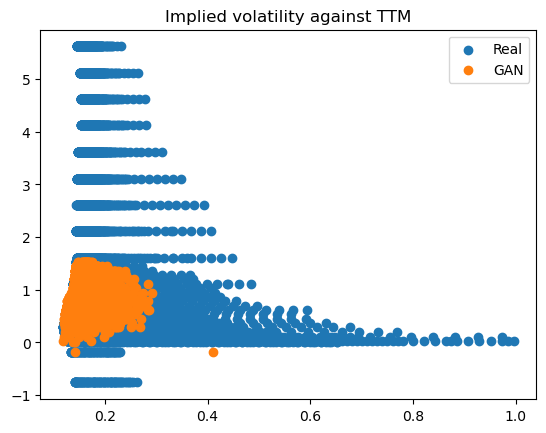

In [15]:
plt.scatter(data['iv'], data['TTM'], label = "Real")
plt.scatter(simulated_data_df['iv'], simulated_data_df['TTM'], label = "GAN")
plt.title("Implied volatility against TTM")
plt.legend()

In [16]:
data

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,delta,vega,gamma,theta,TTM
0,1483500000,1275000000,0.0,0.0,208600006.0,0.651953,0.651953,0,0,0.995230,1.864800e-02,0.000158,-0.191653,0.008214
7192,1520000000,1675000000,0.0,0.0,64300003.0,0.169054,0.169054,0,0,0.353290,6.596541e+06,0.001239,-0.102311,1.442847
7190,1520000000,1670000000,0.0,0.0,65300003.0,0.168484,0.168484,0,0,0.358061,6.627883e+06,0.001249,-0.102402,1.442847
7188,1520000000,1665000000,0.0,0.0,66300003.0,0.167886,0.167886,0,0,0.362869,6.658375e+06,0.001259,-0.102463,1.442847
7186,1520000000,1660000000,0.0,0.0,67300003.0,0.167254,0.167254,0,0,0.367712,6.687969e+06,0.001269,-0.102478,1.442847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,1500400024,1530000000,54200001.0,55099998.0,54700001.0,0.146148,0.146148,0,81,0.454861,4.602492e+06,0.002336,-0.147159,0.613279
3582,1500400024,1525000000,55700001.0,56599998.0,56200001.0,0.144951,0.144951,0,659,0.465559,4.614900e+06,0.002362,-0.146244,0.613279
3580,1500400024,1520000000,57299999.0,58200001.0,57799999.0,0.143859,0.143859,0,141,0.476550,4.624173e+06,0.002384,-0.145329,0.613279
3596,1500400024,1560000000,46000000.0,46900002.0,46599998.0,0.153054,0.153054,0,505,0.395529,4.472437e+06,0.002167,-0.150250,0.613279


In [17]:
simulated_data_df

,futures_close,strike,bid,ask,settlement,iv,iv_interpolated,volume,open_interest,delta,vega,gamma,theta,TTM,Moneyness
0,1.518081e+09,1.625000e+09,0.000000e+00,0.000000e+00,7.124671e+07,0.167521,0.165310,0.000000,4.627459,0.398164,6.535616e+06,0.001318,-0.010686,1.284052,1.070431
1,1.510178e+09,1.435000e+09,0.000000e+00,0.000000e+00,1.223743e+08,0.141471,0.140296,0.000000,7.891199,0.680581,5.082820e+06,0.001754,-0.010686,0.944559,0.950219
2,1.495230e+09,1.465000e+09,6.215162e+07,6.117091e+07,6.045340e+07,0.127502,0.128600,0.000000,391.228256,0.607202,3.763111e+06,0.002943,-0.010686,0.446270,0.979782
3,1.503190e+09,1.655000e+09,3.293402e+07,3.341790e+07,3.380956e+07,0.174353,0.176292,0.055509,35.924103,0.270312,4.096620e+06,0.001555,-0.010686,0.695414,1.100992
4,1.516501e+09,1.690000e+09,0.000000e+00,0.000000e+00,5.459985e+07,0.174908,0.173092,0.004049,21.349307,0.324868,6.004149e+06,0.001210,-0.010686,1.284052,1.114407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.518358e+09,1.550000e+09,0.000000e+00,0.000000e+00,9.208837e+07,0.158563,0.156789,0.000000,4.067278,0.491929,6.636696e+06,0.001403,-0.010686,1.360712,1.020839
9996,1.520495e+09,1.545000e+09,0.000000e+00,0.000000e+00,9.935102e+07,0.157488,0.155434,0.000000,3.695355,0.504778,7.085210e+06,0.001389,-0.010686,1.442847,1.016116
9997,1.498840e+09,1.580000e+09,3.794925e+07,3.801714e+07,3.826879e+07,0.153461,0.154497,0.000000,179.121862,0.358852,3.890697e+06,0.002158,-0.010686,0.533881,1.054149
9998,1.496923e+09,1.490000e+09,5.983050e+07,5.942298e+07,6.070458e+07,0.136630,0.137858,0.000000,36.905796,0.529592,4.449552e+06,0.002890,-0.010686,0.533881,0.995375


In [18]:
simulated_data_df['TTM'].value_counts()

 1.284052    1030
 0.944559     982
 1.204654     966
 1.111567     916
 1.034908     900
 1.360712     883
 0.865161     838
 0.785763     823
 0.695414     700
 0.613279     652
 1.442847     539
 0.533881     410
 0.446270     167
 0.364134      74
 0.287474      57
 1.533196      31
 0.197125      19
 0.112252       7
-0.177960       2
 0.008214       2
 0.035592       2
Name: TTM, dtype: int64

C:\Users\jesper\AppData\Local\Temp\ipykernel_11420\2170257330.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


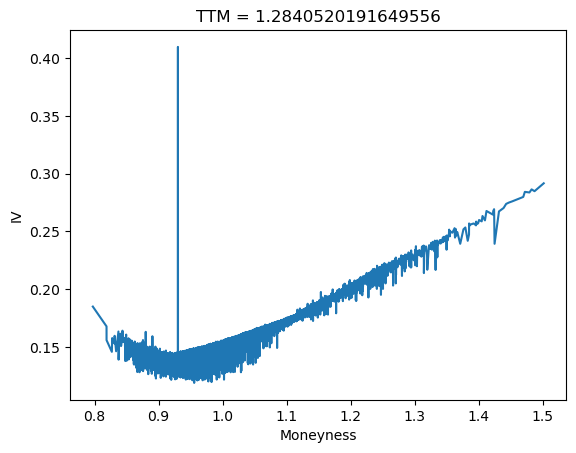

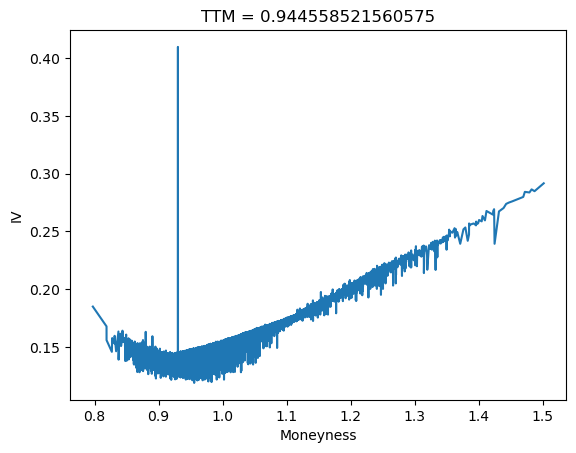

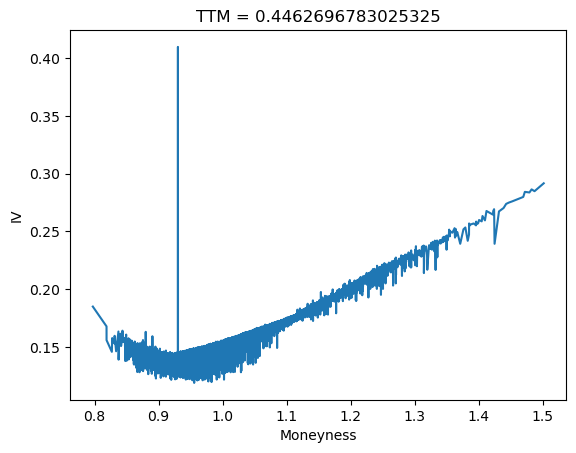

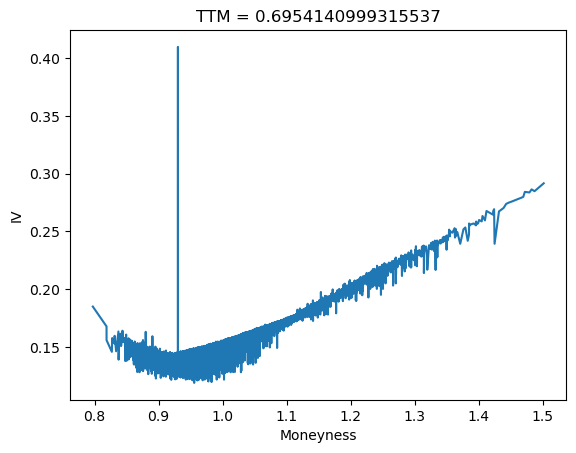

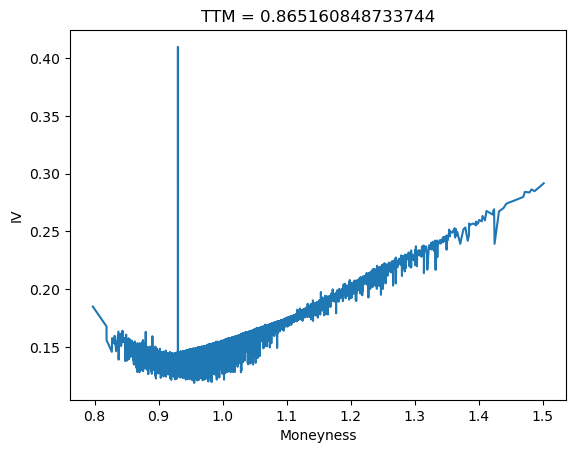

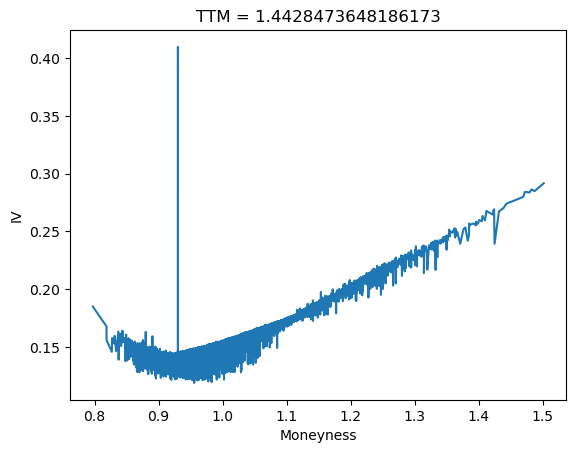

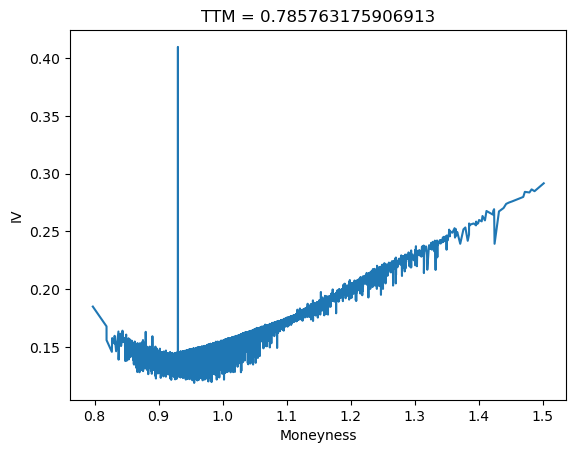

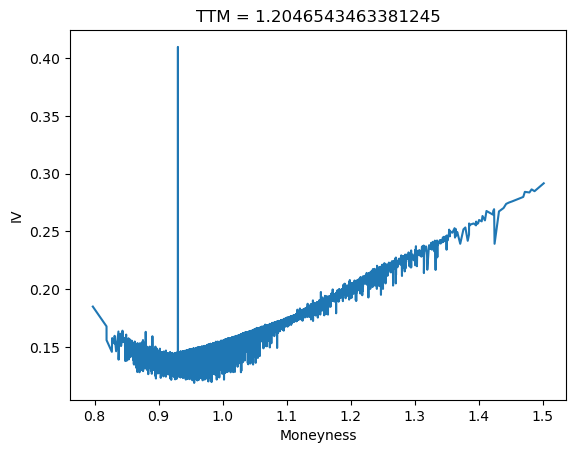

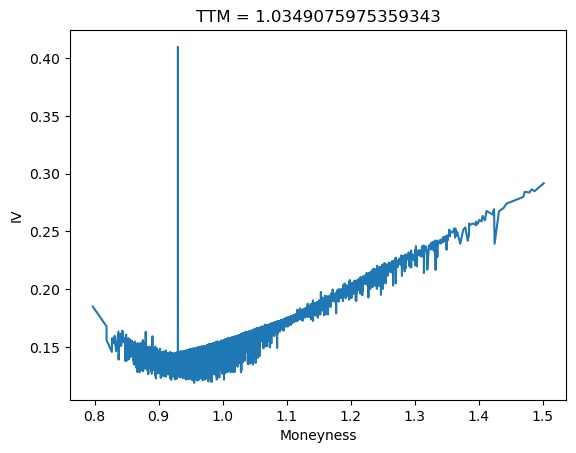

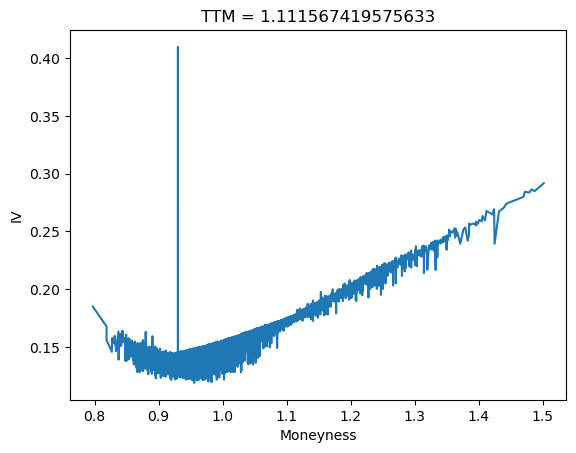

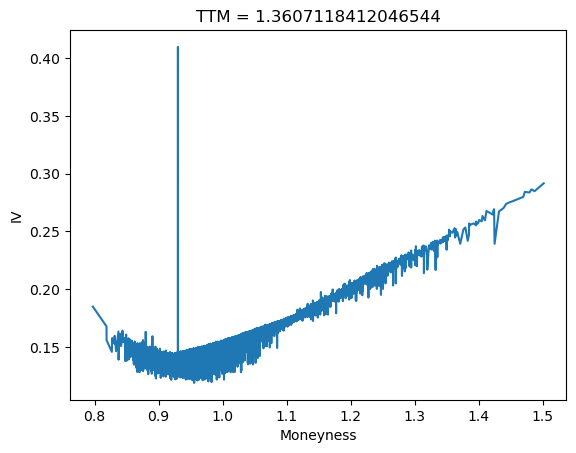

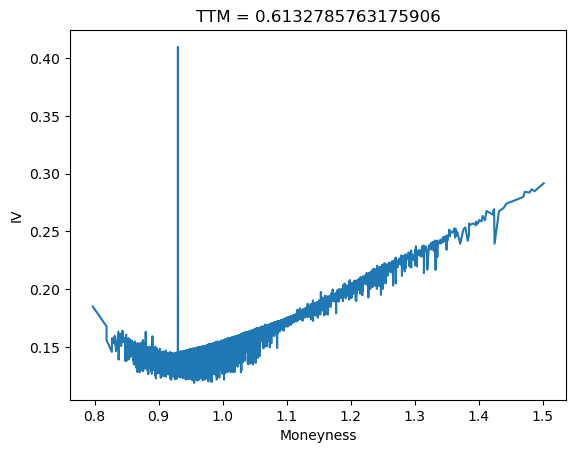

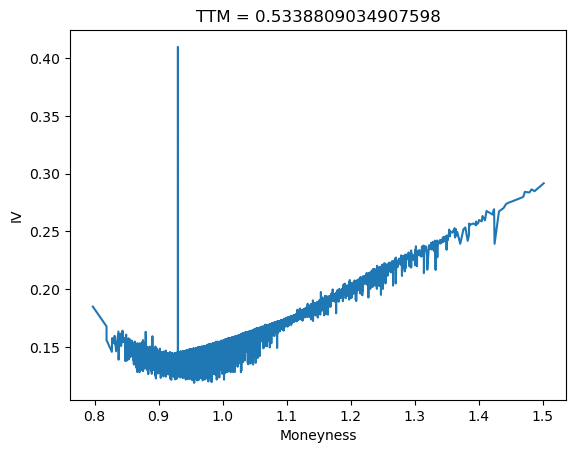

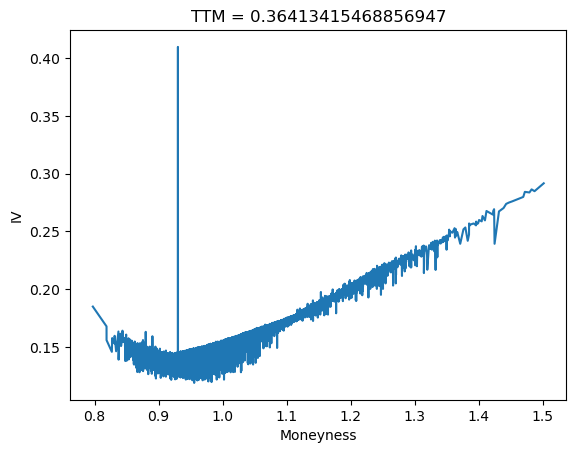

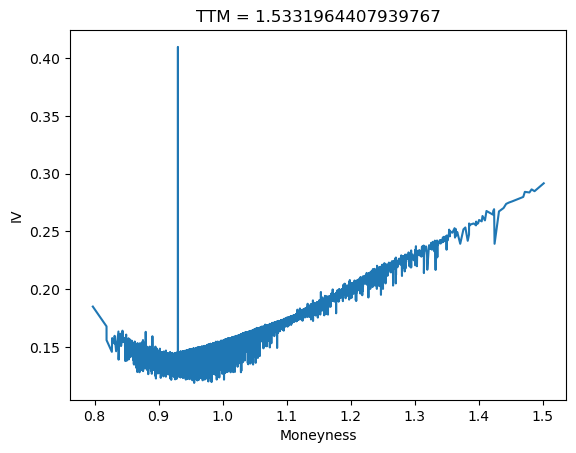

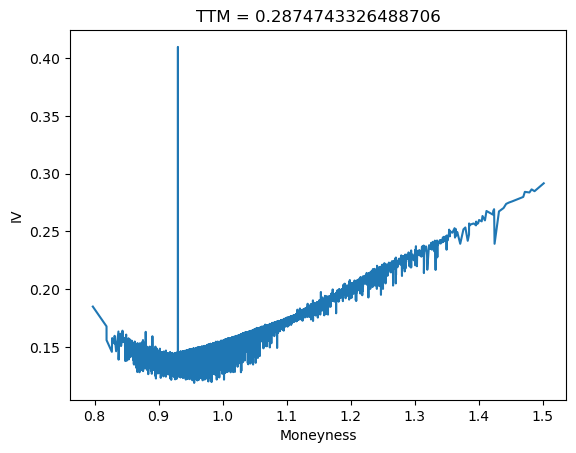

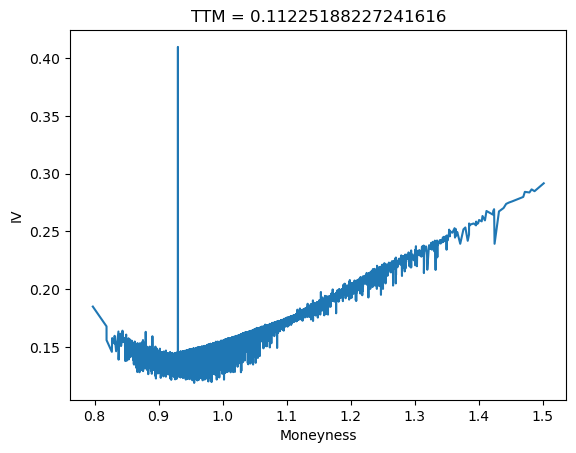

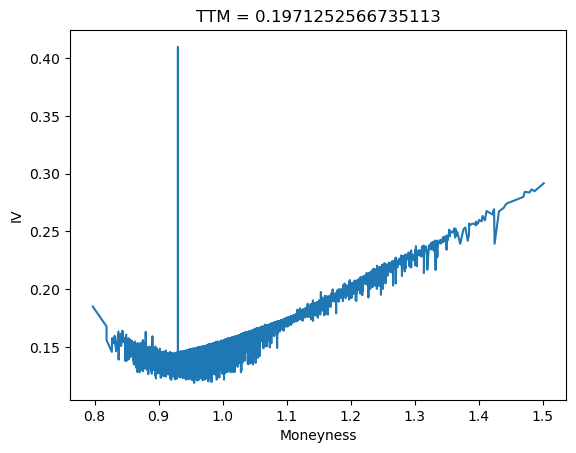

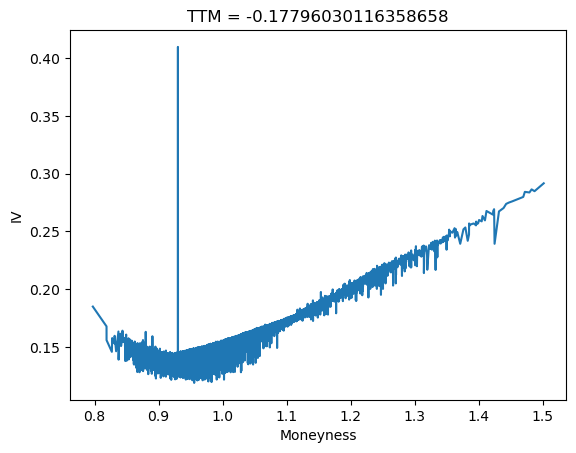

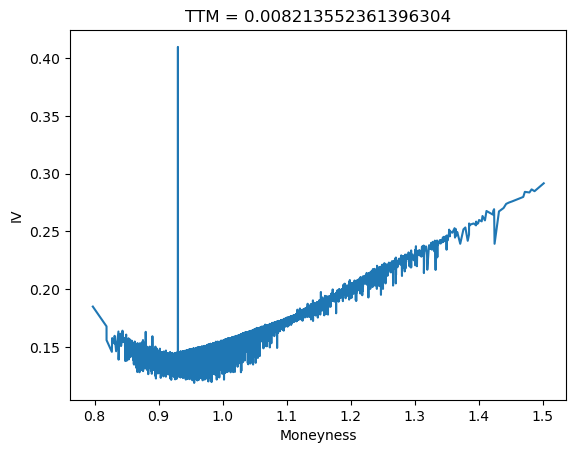

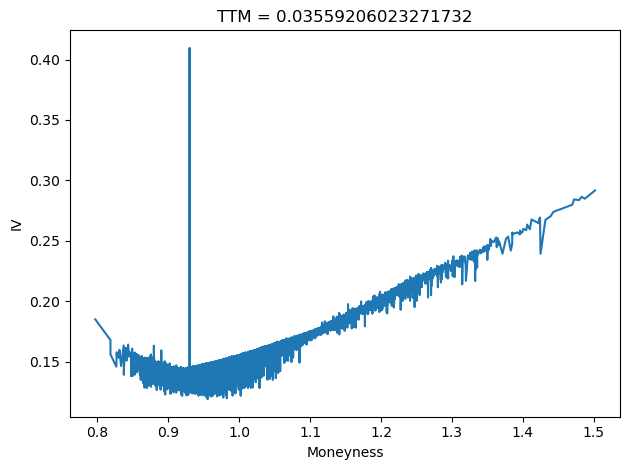

In [19]:
# Create subplots based on unique 'TTM' values
unique_ttms = simulated_data_df['TTM'].unique()


# Plot 'strike' against 'iv' for each 'TTM'
for ttm in unique_ttms:
    sorted_data = simulated_data_df.sort_values(by='Moneyness')
    subset = simulated_data_df[simulated_data_df['TTM'] == ttm]
    plt.figure()
    plt.plot(sorted_data['Moneyness'], sorted_data['iv'])
    plt.title(f'TTM = {ttm}')
    plt.xlabel('Moneyness')
    plt.ylabel('IV')

plt.tight_layout()
plt.show()

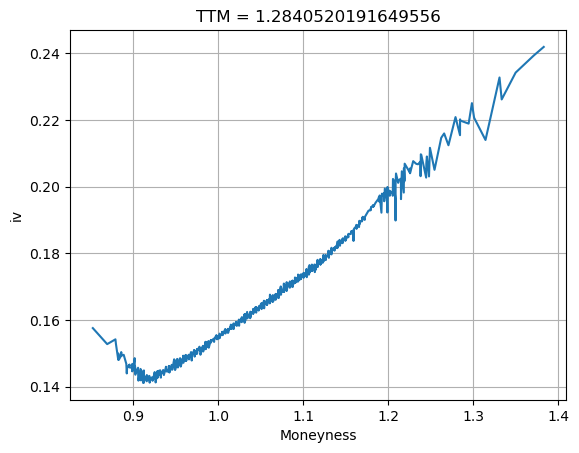

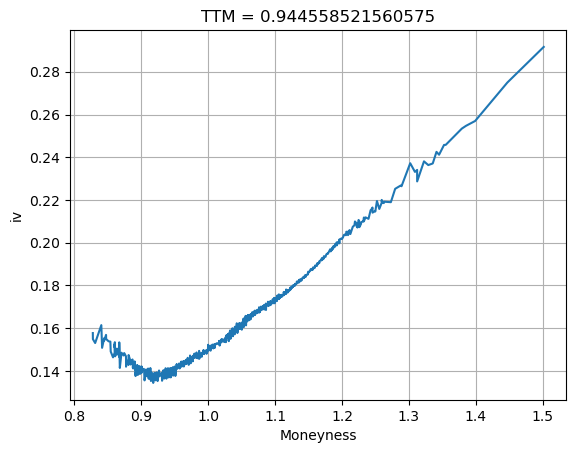

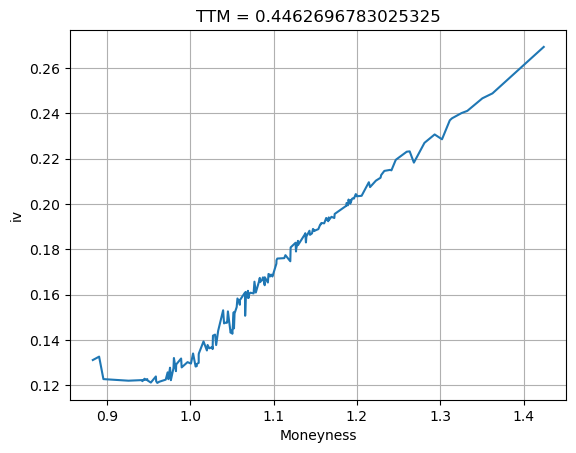

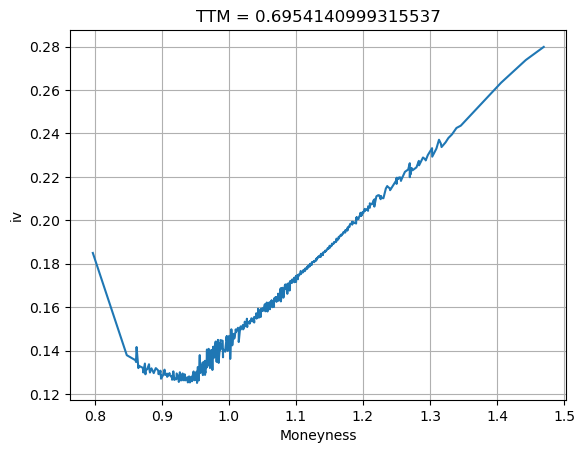

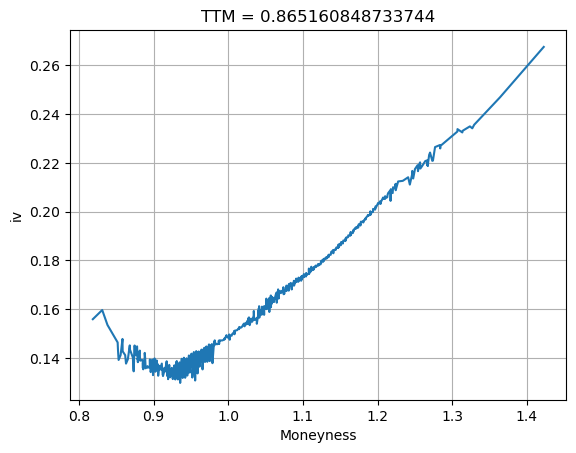

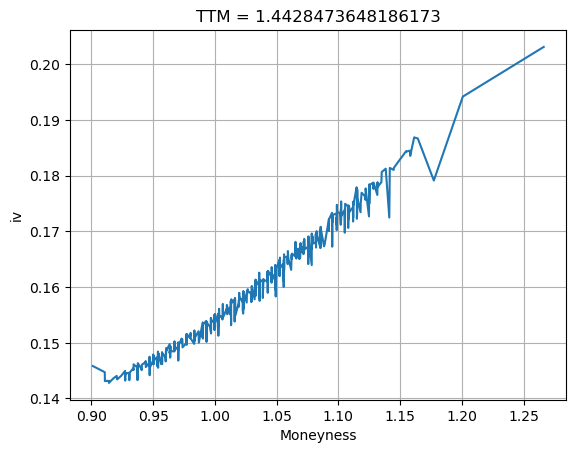

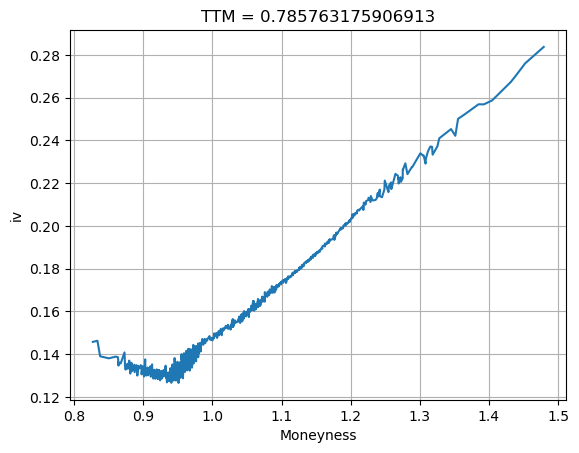

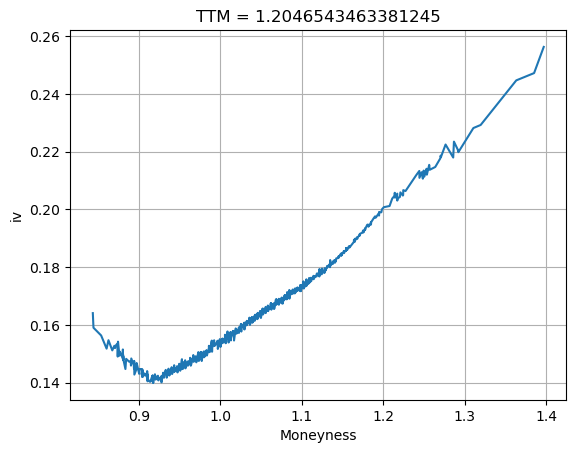

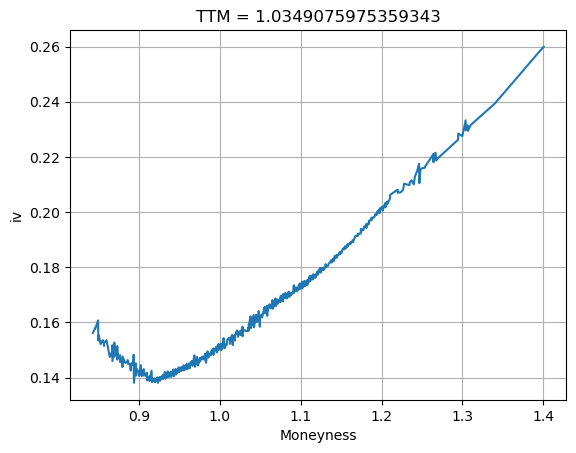

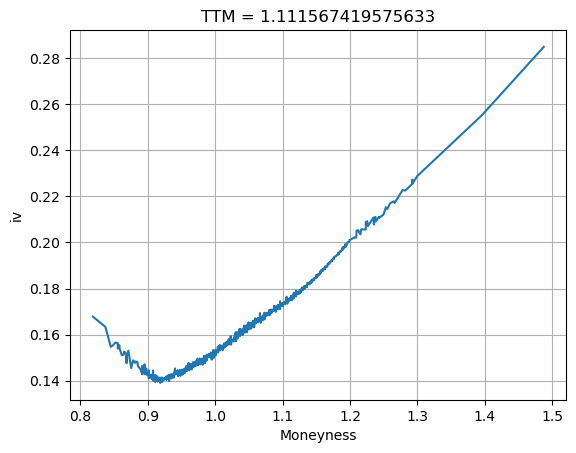

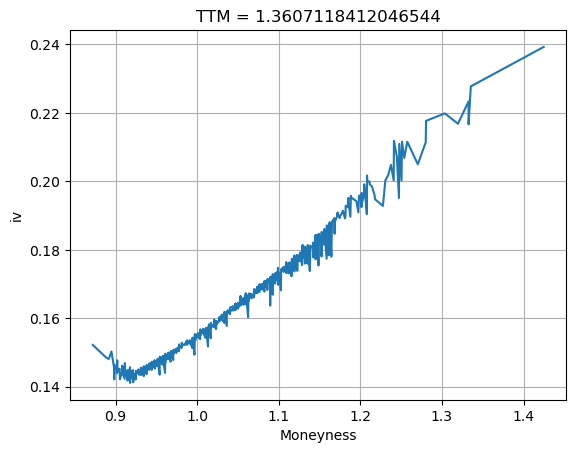

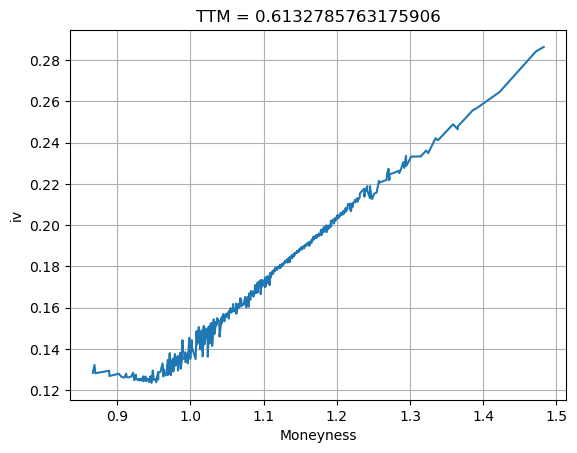

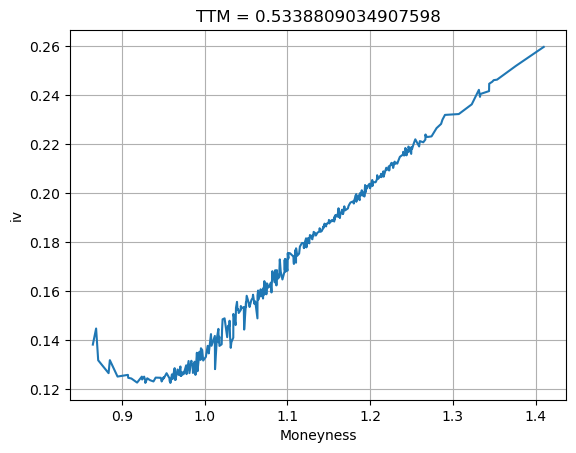

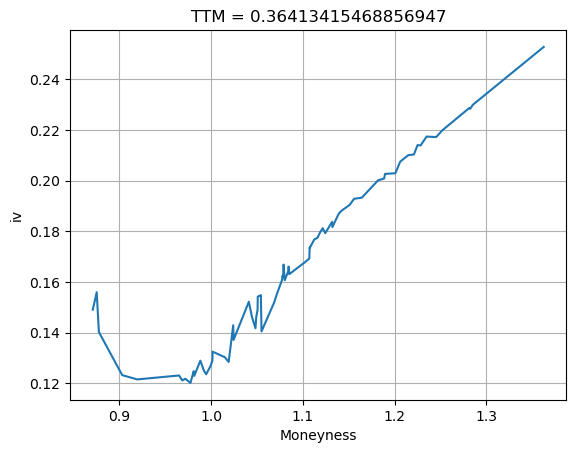

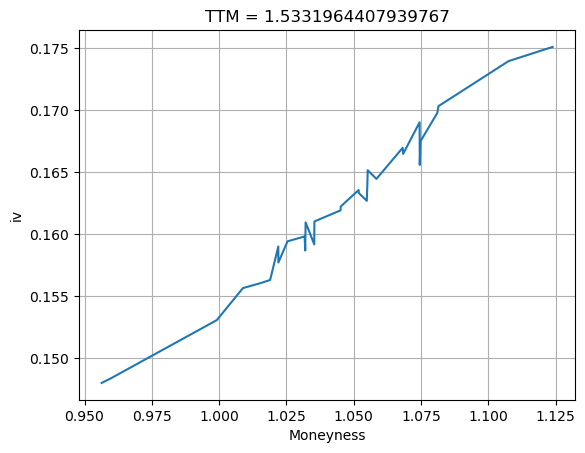

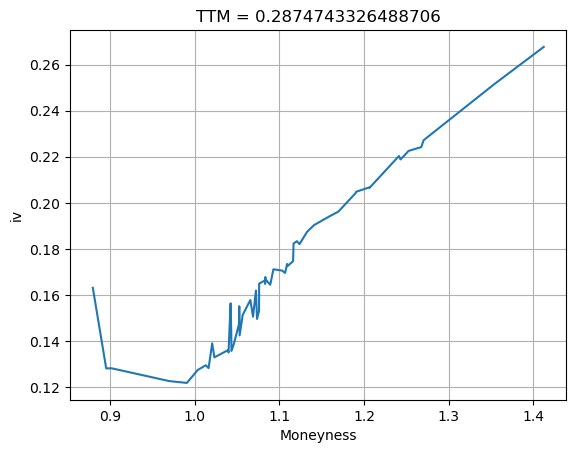

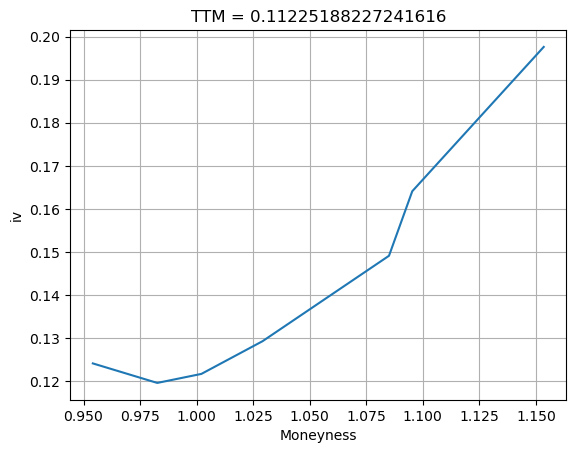

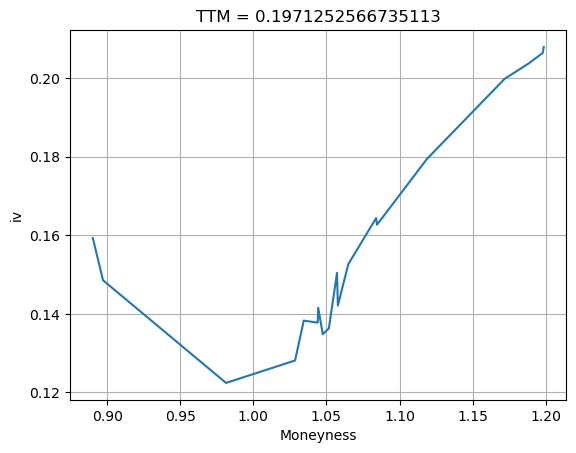

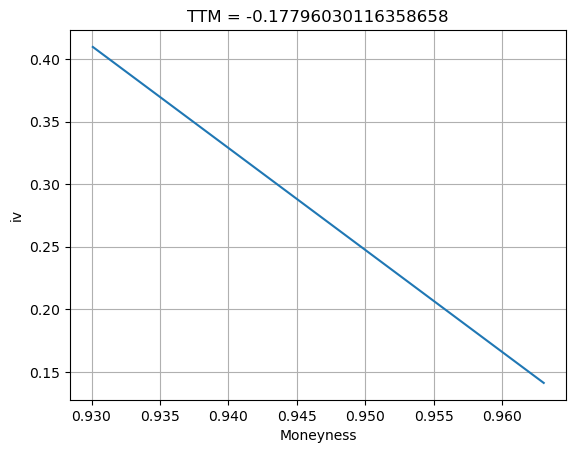

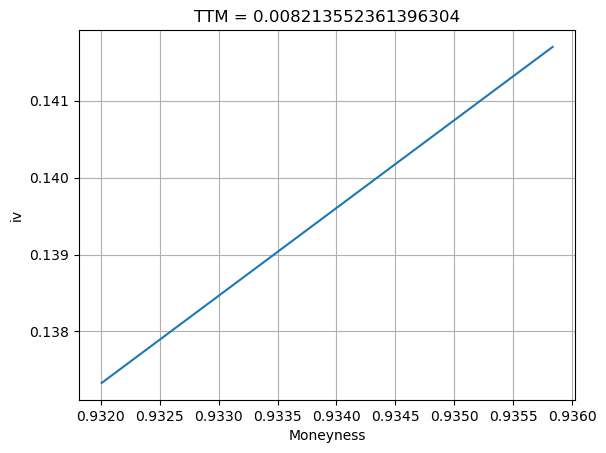

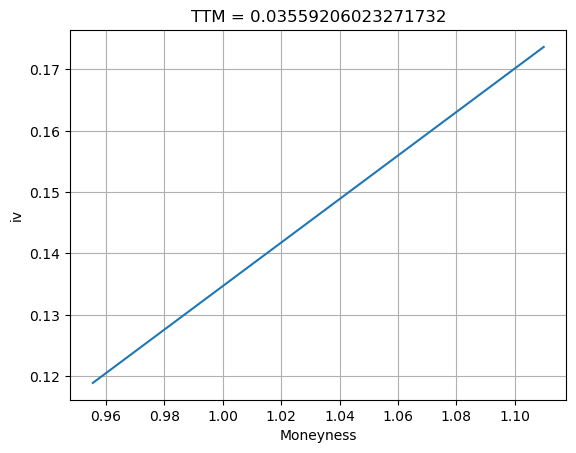

In [20]:
unique_ttms = simulated_data_df['TTM'].unique()

# Plot 'IV' against 'Moneyness' for each 'TTM'
for ttm in unique_ttms:
    subset = simulated_data_df[simulated_data_df['TTM'] == ttm]
    subset_sorted = subset.sort_values(by='Moneyness')  # Ensure sorting is done within the loop, for each subset
    plt.figure()
    plt.plot(subset_sorted['Moneyness'], subset_sorted['iv'])  # Add markers for clarity
    plt.title(f'TTM = {ttm}')
    plt.xlabel('Moneyness')
    plt.ylabel('iv')
    plt.grid(True)  # Optionally add a grid
    plt.show()  # Show plot for each TTM value

# Remove plt.tight_layout() as it is not needed when showing plots one by one

In [21]:
simulated_data_df['futures_close'].value_counts()

1.508600e+09    2
1.516844e+09    2
1.505109e+09    2
1.517596e+09    2
1.516258e+09    2
               ..
1.518189e+09    1
1.511963e+09    1
1.518903e+09    1
1.502129e+09    1
1.508815e+09    1
Name: futures_close, Length: 9992, dtype: int64

unique_combinations = simulated_data_df[['TTM', 'futures_close']].drop_duplicates()
kurtosis = []
skewness = []
labels = []
for index, row in unique_combinations.iterrows():
    specific_expiration_date = row['TTM']
    specific_future_close = row['futures_close']
    
    # Filter data for the specific combination
    specific_conditions = (simulated_data_df['TTM'] == specific_expiration_date) & (simulated_data_df['futures_close'] == specific_future_close)
    filtered_data = simulated_data_df[specific_conditions]
    
    sorted_data = filtered_data.sort_values(by='Moneyness')
    kurtosis_value = filtered_data['iv'].kurtosis()
    if kurtosis_value <20:
        kurtosis.append(kurtosis_value)
        labels.append(f'{specific_expiration_date} - {specific_future_close}')
        skewness.append(filtered_data['iv'].skew())
    plt.figure()
    plt.plot(sorted_data['Moneyness'], sorted_data['iv'])
    plt.title(f'Implied Volatility vs Moneyness\nExpiration Date: {specific_expiration_date}, Future Close: {specific_future_close}')
    plt.xlabel('Moneyness')
    plt.ylabel('Implied Volatility')
    plt.grid(True)